Tomamos viento nulo para que el ángulo azimutal sea constante y vemos como se desvía el ángulo polar respecto al de emisión (el de línea recta)

In [3]:
using LinearAlgebra
using DifferentialEquations


E_rel=  0.01
T = 23.
v_wind =[0.,0.,0.]
Source = [0.,0.,0.]
function phi(Point1::Array{Float64, 1}, Point2::Array{Float64, 1}, v_wind::Array{Float64, 1}, tau) 
        #tgphi= (Point2[2]-Point1[2]- v_wind[2]*tau)/(Point2[1]-Point1[1]- v_wind[1]*tau) #Cálculo phi primera iteración
        #phi=rad2deg(atan(tgphi))
        phi=rad2deg(atan((Point2[2]-Point1[2]- v_wind[2]*tau),(Point2[1]-Point1[1]- v_wind[1]*tau)))
        return phi
end
function Slowness_Spherical(Point1::Array{Float64, 1}, Point2::Array{Float64, 1}, v_wind::Array{Float64, 1}, phi, c_source)
    x1,y1,z1=Point2-Point1 #Obtención parámetros primera iteración
    r=norm(Point2-Point1)
    theta=rad2deg(acos(z1/r))
    q0=1/(c_source + (v_wind[1]*cosd(phi)+ v_wind[2]*sind(phi))*cosd(theta) )
    qx=q0*cosd(phi)*sind(theta)
    qy=q0*sind(phi)*sind(theta)
    qz=q0*cosd(theta)
    return q0,qx,qy,qz,theta
end
function c_z(T,z) 
    if z>0
        c_air=331*sqrt((T+273.15-z/200)/273.15) #Modelo termodinámico v_sonido.Introduzco T_Z0 en grados centígrados por comodidad
    else
        c_air=331*sqrt((T+273.15)/273.15)
    end
    return c_air
end
function g!(dg, g, p, t)
    qx,qy = p
    q_aux = sqrt(qx^2 + qy^2 + g[4]^2)
    c=c_z(T,g[3])
    dg[1] = c*qx/q_aux + v_wind[1] #Variación coordenada X
    dg[2] = c*qy/q_aux + v_wind[2]  #Variación coordenada Y
    dg[3] = c*g[4]/q_aux + v_wind[3] #Variación coordenada Z
    dg[4]=+q_aux*(331^2/(400*273.15))/c #Variación qz
end
#### Necesitamos una velocidad inicial, correspondiente a la fuente, y un ángulo azimutal para empezar a iterar.
c_source=c_z(T, Source[3])
####
angulo_recta=[]
angulo_real= []
errores_relativos=[]
@time begin
for n in 0:50
    Receiver = [1000.,0.,100*n]
    R=norm(Receiver-Source)
    t_min=R/c_z(T,min(Source[3],Receiver[3]))
    t_max=R/c_z(T, max(Source[3],Receiver[3]))
    phi1=phi(Source,Receiver,v_wind, t_max) #Acotación teórica phi
    phi2=phi(Source,Receiver,v_wind, t_min) #Acotación teórica phi
    phi_i=(phi1+phi2)/2 #La media de la cota de phi como phi para la primera iteración
    #######
    q0,q_x,q_y,q_z,theta_i=Slowness_Spherical(Source,Receiver,v_wind, phi_i, c_source) #Obtención parámetros
    push!(angulo_recta,theta_i)
    #######
    traveltime=[]
    detener = 0 # Variable de control
    for l in 1:10
        if detener==1
            break
        end     
        thetas= range(theta_i-25/(2^(l-1)), theta_i+25/(2^(l-1)), 50);
        if v_wind==[0.,0.,0.]
                phis=[deepcopy(phi_i)]
        else
            if l==1
                phis=(min(phi1,phi2):0.05:max(phi1,phi2))
            else
                phi_distance=max(phi1,phi2)-min(phi1,phi2)
                phis= range(phi_i-phi_distance/(2^(l)), theta_i-phi_distance/(2^(l)), 20);
            end
        end
        angulos_theta = []
        angulos_phi = []
        tiempos = []
        for i in 1:length(thetas)
            for j in 1:length(phis)
                if l>1
                    q0=1/(c_source + (v_wind[1]*cosd(phi_i)+ v_wind[2]*sind(phi_i))*cosd(theta_i) )
                end
                q_x=q0*cosd(phis[j])*sind(thetas[i])
                q_y=q0*sind(phis[j])*sind(thetas[i])
                q_z=q0*cosd(thetas[i])
                p = [q_x, q_y]
                u0 = [Source[1],Source[2],Source[3], q_z]
                tspan=[0,t_max]
                prob = ODEProblem(g!, u0, tspan, p)
                paso=1e-2*R/2000
                sol = solve(prob, RK4(), dt=paso, saveat=0:paso:t_max)
                for k in 1:length(sol.u)
                    if detener==0
                        if sqrt((sol.u[k][1] - Receiver[1])^2 +(sol.u[k][2] - Receiver[2])^2 + (sol.u[k][3] - Receiver[3])^2 ) < R/(20*2^(l-1))
                            push!(angulos_theta, thetas[i])
                            push!(angulos_phi, phis[j])
                            push!(tiempos, sol.t[k])
                            break
                        elseif sqrt((sol.u[k][1] - Receiver[1])^2 +(sol.u[k][2] - Receiver[2])^2 + (sol.u[k][3] - Receiver[3])^2 ) < R*E_rel/100
                            traveltime = sol.t[k] #Error relativo menor a 0.01% ya detenemos el barrido
                            theta_i = thetas[i]
                            phi_i = phis[j]
                            detener = 1 # Cambiamos el valor de la variable de control
                            println("Se alcanzó el error relativo objetivo.")
                            break
                        end
                    else
                        break
                    end
                end
            end
        end
        if length(tiempos)==0
            if l==1
                println("No se encontró ninguna trayectoria entre fuente y receptor. Valora si estás en una zona de sombra o ajusta el paso de tiempo ")
            end
            break
        elseif detener==0
            traveltime = findmin(tiempos)
            indice = argmin(tiempos)
            theta_i=angulos_theta[indice]
            phi_i=angulos_phi[indice]
        end
    end
    push!(angulo_real,theta_i)
    q_x=q0*cosd(phi_i)*sind(theta_i)
    q_y=q0*sind(phi_i)*sind(theta_i)
    q_z=q0*cosd(theta_i)
    # Definir los parámetros
    p = [q_x, q_y]
    u0 = [Source[1],Source[2], Source[3], q_z]
    tspan=[0,traveltime[1]]
    # Crear el problema ODE
    prob = ODEProblem(g!, u0, tspan, p)
    # Resolver el problema ODE
    paso=1e-2*R/2000
    sol = solve(prob, RK4(), dt=paso, saveat=0:paso:traveltime[1])
    error_relativo_n=(sqrt((sol.u[end][1] - Receiver[1])^2 +(sol.u[end][2] - Receiver[2])^2 + (sol.u[end][3] - Receiver[3])^2 )/R)*100
    push!(errores_relativos,error_relativo_n)
end
end

Se alcanzó el error relativo objetivo.
Se alcanzó el error relativo objetivo.
 40.730315 seconds (528.11 M allocations: 29.103 GiB, 13.05% gc time, 0.29% compilation time: 53% of which was recompilation)


In [7]:
angulo_recta

51-element Vector{Any}:
 90.0
 84.28940686250037
 78.69006752597979
 73.30075576600639
 68.19859051364818
 63.43494882292201
 59.03624346792647
 55.00797980144134
 51.34019174590991
 48.01278750418334
 45.00000000000001
 42.273689006093726
 39.80557109226519
  ⋮
 14.38139459109062
 14.036243467926484
 13.70696100407981
 13.392497753751098
 13.091893064346861
 12.80426606528674
 12.52880770915155
 12.2647737278924
 12.01147838636543
 11.768288932020628
 11.534620653644708
 11.309932474020227

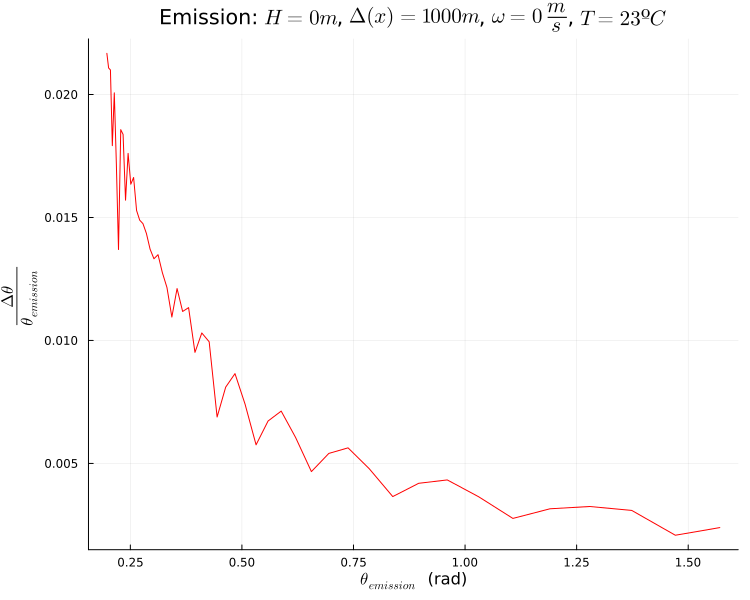

In [24]:
using Plots

x = deg2rad.(angulo_recta)
y = (angulo_real - angulo_recta)./angulo_recta

using Plots

p = plot(x, y, 
         xlabel=raw"$\theta_{emission}$  (rad)", 
         ylabel=raw"$\frac{\Delta \theta}{\theta_{emission}}$ ",
         title=raw"Emission: $H=0m$, $\Delta (x)=1000m$, $\omega=0 \frac{m}{s}$, $T=23ºC$",size=(750,600),color=:red,
         legend=false)

# Guardar la gráfica en un archivo
savefig(p, "C:\\Users\\Miguel\\Desktop\\TFM\\Ángulos_Probables_Theta\\altitud0.png")

q = plot(x, errores_relativos, 
         xlabel=raw"$\theta_{emission}$  ", 
         ylabel=raw"Relative Error (%)",
         title=raw"Emission: $H=0m$, $\Delta (x)=1000m$, $\omega=0 \frac{m}{s}$, $T=23ºC$",color=:green,
         legend=false)

# Guardar la gráfica en un archivo
savefig(q, "C:\\Users\\Miguel\\Desktop\\TFM\\Ángulos_Probables_Theta\\erroresaltitud0.png")

p

In [25]:
using LinearAlgebra
using DifferentialEquations


E_rel=  0.01
T = 23.
v_wind =[0.,0.,0.]
Source = [0.,0.,1000.]
function phi(Point1::Array{Float64, 1}, Point2::Array{Float64, 1}, v_wind::Array{Float64, 1}, tau) 
        #tgphi= (Point2[2]-Point1[2]- v_wind[2]*tau)/(Point2[1]-Point1[1]- v_wind[1]*tau) #Cálculo phi primera iteración
        #phi=rad2deg(atan(tgphi))
        phi=rad2deg(atan((Point2[2]-Point1[2]- v_wind[2]*tau),(Point2[1]-Point1[1]- v_wind[1]*tau)))
        return phi
end
function Slowness_Spherical(Point1::Array{Float64, 1}, Point2::Array{Float64, 1}, v_wind::Array{Float64, 1}, phi, c_source)
    x1,y1,z1=Point2-Point1 #Obtención parámetros primera iteración
    r=norm(Point2-Point1)
    theta=rad2deg(acos(z1/r))
    q0=1/(c_source + (v_wind[1]*cosd(phi)+ v_wind[2]*sind(phi))*cosd(theta) )
    qx=q0*cosd(phi)*sind(theta)
    qy=q0*sind(phi)*sind(theta)
    qz=q0*cosd(theta)
    return q0,qx,qy,qz,theta
end
function c_z(T,z) 
    if z>0
        c_air=331*sqrt((T+273.15-z/200)/273.15) #Modelo termodinámico v_sonido.Introduzco T_Z0 en grados centígrados por comodidad
    else
        c_air=331*sqrt((T+273.15)/273.15)
    end
    return c_air
end
function g!(dg, g, p, t)
    qx,qy = p
    q_aux = sqrt(qx^2 + qy^2 + g[4]^2)
    c=c_z(T,g[3])
    dg[1] = c*qx/q_aux + v_wind[1] #Variación coordenada X
    dg[2] = c*qy/q_aux + v_wind[2]  #Variación coordenada Y
    dg[3] = c*g[4]/q_aux + v_wind[3] #Variación coordenada Z
    dg[4]=+q_aux*(331^2/(400*273.15))/c #Variación qz
end
#### Necesitamos una velocidad inicial, correspondiente a la fuente, y un ángulo azimutal para empezar a iterar.
c_source=c_z(T, Source[3])
####
angulo_recta_1000=[]
angulo_real_1000= []
errores_relativos_1000=[]
@time begin
for n in 0:50
    Receiver = [1000.,0.,100*n]
    R=norm(Receiver-Source)
    t_min=R/c_z(T,min(Source[3],Receiver[3]))
    t_max=R/c_z(T, max(Source[3],Receiver[3]))
    phi1=phi(Source,Receiver,v_wind, t_max) #Acotación teórica phi
    phi2=phi(Source,Receiver,v_wind, t_min) #Acotación teórica phi
    phi_i=(phi1+phi2)/2 #La media de la cota de phi como phi para la primera iteración
    #######
    q0,q_x,q_y,q_z,theta_i=Slowness_Spherical(Source,Receiver,v_wind, phi_i, c_source) #Obtención parámetros
    push!(angulo_recta_1000,theta_i)
    #######
    traveltime=[]
    detener = 0 # Variable de control
    for l in 1:10
        if detener==1
            break
        end     
        thetas= range(theta_i-25/(2^(l-1)), theta_i+25/(2^(l-1)), 50);
        if v_wind==[0.,0.,0.]
                phis=[deepcopy(phi_i)]
        else
            if l==1
                phis=(min(phi1,phi2):0.05:max(phi1,phi2))
            else
                phi_distance=max(phi1,phi2)-min(phi1,phi2)
                phis= range(phi_i-phi_distance/(2^(l)), theta_i-phi_distance/(2^(l)), 20);
            end
        end
        angulos_theta = []
        angulos_phi = []
        tiempos = []
        for i in 1:length(thetas)
            for j in 1:length(phis)
                if l>1
                    q0=1/(c_source + (v_wind[1]*cosd(phi_i)+ v_wind[2]*sind(phi_i))*cosd(theta_i) )
                end
                q_x=q0*cosd(phis[j])*sind(thetas[i])
                q_y=q0*sind(phis[j])*sind(thetas[i])
                q_z=q0*cosd(thetas[i])
                p = [q_x, q_y]
                u0 = [Source[1],Source[2],Source[3], q_z]
                tspan=[0,t_max]
                prob = ODEProblem(g!, u0, tspan, p)
                paso=1e-2*R/2000
                sol = solve(prob, RK4(), dt=paso, saveat=0:paso:t_max)
                for k in 1:length(sol.u)
                    if detener==0
                        if sqrt((sol.u[k][1] - Receiver[1])^2 +(sol.u[k][2] - Receiver[2])^2 + (sol.u[k][3] - Receiver[3])^2 ) < R/(20*2^(l-1))
                            push!(angulos_theta, thetas[i])
                            push!(angulos_phi, phis[j])
                            push!(tiempos, sol.t[k])
                            break
                        elseif sqrt((sol.u[k][1] - Receiver[1])^2 +(sol.u[k][2] - Receiver[2])^2 + (sol.u[k][3] - Receiver[3])^2 ) < R*E_rel/100
                            traveltime = sol.t[k] #Error relativo menor a 0.01% ya detenemos el barrido
                            theta_i = thetas[i]
                            phi_i = phis[j]
                            detener = 1 # Cambiamos el valor de la variable de control
                            println("Se alcanzó el error relativo objetivo.")
                            break
                        end
                    else
                        break
                    end
                end
            end
        end
        if length(tiempos)==0
            if l==1
                println("No se encontró ninguna trayectoria entre fuente y receptor. Valora si estás en una zona de sombra o ajusta el paso de tiempo ")
            end
            break
        elseif detener==0
            traveltime = findmin(tiempos)
            indice = argmin(tiempos)
            theta_i=angulos_theta[indice]
            phi_i=angulos_phi[indice]
        end
    end
    push!(angulo_real_1000,theta_i)
    q_x=q0*cosd(phi_i)*sind(theta_i)
    q_y=q0*sind(phi_i)*sind(theta_i)
    q_z=q0*cosd(theta_i)
    # Definir los parámetros
    p = [q_x, q_y]
    u0 = [Source[1],Source[2], Source[3], q_z]
    tspan=[0,traveltime[1]]
    # Crear el problema ODE
    prob = ODEProblem(g!, u0, tspan, p)
    # Resolver el problema ODE
    paso=1e-2*R/2000
    sol = solve(prob, RK4(), dt=paso, saveat=0:paso:traveltime[1])
    error_relativo_n=(sqrt((sol.u[end][1] - Receiver[1])^2 +(sol.u[end][2] - Receiver[2])^2 + (sol.u[end][3] - Receiver[3])^2 )/R)*100
    push!(errores_relativos_1000,error_relativo_n)
end
end

Se alcanzó el error relativo objetivo.
Se alcanzó el error relativo objetivo.
 42.361074 seconds (528.06 M allocations: 29.129 GiB, 14.03% gc time, 0.25% compilation time: 67% of which was recompilation)


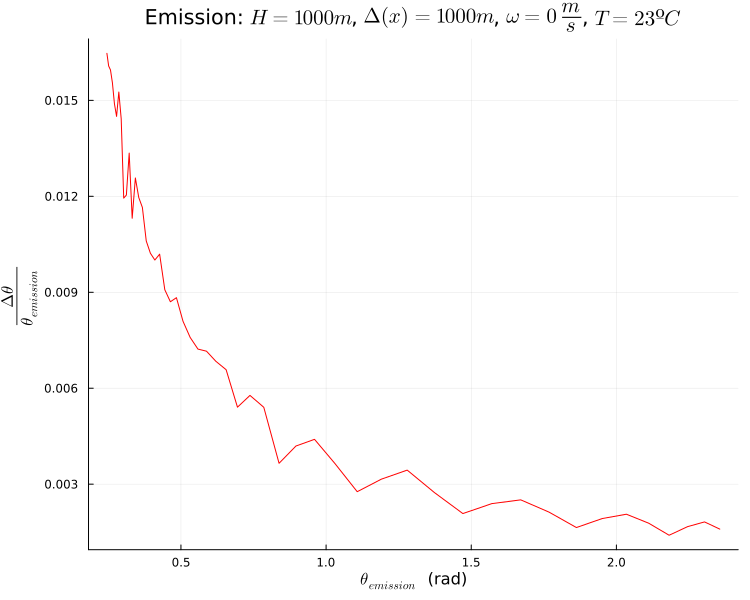

In [30]:
using Plots

x = deg2rad.(angulo_recta_1000)
y1 = (angulo_real_1000 - angulo_recta_1000)./angulo_recta_1000
y2=deepcopy(errores_relativos_1000)
using Plots

p = plot(x, y1, 
         xlabel=raw"$\theta_{emission}$  (rad)", 
         ylabel=raw"$\frac{\Delta \theta}{\theta_{emission}}$ ",
         title=raw"Emission: $H=1000m$, $\Delta (x)=1000m$, $\omega=0 \frac{m}{s}$, $T=23ºC$",size=(750,600),color=:red,
         legend=false)

# Guardar la gráfica en un archivo
savefig(p, "C:\\Users\\Miguel\\Desktop\\TFM\\Ángulos_Probables_Theta\\altitud1000.png")

q = plot(x, y2, 
         xlabel=raw"$\theta_{emission}$  ", 
         ylabel=raw"Relative Error (%)",
         title=raw"Emission: $H=1000m$, $\Delta (x)=1000m$, $\omega=0 \frac{m}{s}$, $T=23ºC$",color=:green,
         legend=false)

# Guardar la gráfica en un archivo
savefig(q, "C:\\Users\\Miguel\\Desktop\\TFM\\Ángulos_Probables_Theta\\erroresaltitud1000.png")

p

In [41]:
using LinearAlgebra
using DifferentialEquations


E_rel=  0.01
T = 23.
v_wind =[0.,0.,0.]
Source = [0.,0.,5000.]
function phi(Point1::Array{Float64, 1}, Point2::Array{Float64, 1}, v_wind::Array{Float64, 1}, tau) 
        #tgphi= (Point2[2]-Point1[2]- v_wind[2]*tau)/(Point2[1]-Point1[1]- v_wind[1]*tau) #Cálculo phi primera iteración
        #phi=rad2deg(atan(tgphi))
        phi=rad2deg(atan((Point2[2]-Point1[2]- v_wind[2]*tau),(Point2[1]-Point1[1]- v_wind[1]*tau)))
        return phi
end
function Slowness_Spherical(Point1::Array{Float64, 1}, Point2::Array{Float64, 1}, v_wind::Array{Float64, 1}, phi, c_source)
    x1,y1,z1=Point2-Point1 #Obtención parámetros primera iteración
    r=norm(Point2-Point1)
    theta=rad2deg(acos(z1/r))
    q0=1/(c_source + (v_wind[1]*cosd(phi)+ v_wind[2]*sind(phi))*cosd(theta) )
    qx=q0*cosd(phi)*sind(theta)
    qy=q0*sind(phi)*sind(theta)
    qz=q0*cosd(theta)
    return q0,qx,qy,qz,theta
end
function c_z(T,z) 
    if z>0
        c_air=331*sqrt((T+273.15-z/200)/273.15) #Modelo termodinámico v_sonido.Introduzco T_Z0 en grados centígrados por comodidad
    else
        c_air=331*sqrt((T+273.15)/273.15)
    end
    return c_air
end
function g!(dg, g, p, t)
    qx,qy = p
    q_aux = sqrt(qx^2 + qy^2 + g[4]^2)
    c=c_z(T,g[3])
    dg[1] = c*qx/q_aux + v_wind[1] #Variación coordenada X
    dg[2] = c*qy/q_aux + v_wind[2]  #Variación coordenada Y
    dg[3] = c*g[4]/q_aux + v_wind[3] #Variación coordenada Z
    dg[4]=+q_aux*(331^2/(400*273.15))/c #Variación qz
end
#### Necesitamos una velocidad inicial, correspondiente a la fuente, y un ángulo azimutal para empezar a iterar.
c_source=c_z(T, Source[3])
####
angulo_recta_5000=[]
angulo_real_5000= []
errores_relativos_5000=[]
@time begin
for n in 0:50
    Receiver = [1000.,0.,200*n]
    R=norm(Receiver-Source)
    t_min=R/c_z(T,min(Source[3],Receiver[3]))
    t_max=R/c_z(T, max(Source[3],Receiver[3]))
    phi1=phi(Source,Receiver,v_wind, t_max) #Acotación teórica phi
    phi2=phi(Source,Receiver,v_wind, t_min) #Acotación teórica phi
    phi_i=(phi1+phi2)/2 #La media de la cota de phi como phi para la primera iteración
    #######
    q0,q_x,q_y,q_z,theta_i=Slowness_Spherical(Source,Receiver,v_wind, phi_i, c_source) #Obtención parámetros
    push!(angulo_recta_5000,theta_i)
    #######
    traveltime=[]
    detener = 0 # Variable de control
    for l in 1:10
        if detener==1
            break
        end     
        thetas= range(theta_i-25/(2^(l-1)), theta_i+25/(2^(l-1)), 50);
        if v_wind==[0.,0.,0.]
                phis=[deepcopy(phi_i)]
        else
            if l==1
                phis=(min(phi1,phi2):0.05:max(phi1,phi2))
            else
                phi_distance=max(phi1,phi2)-min(phi1,phi2)
                phis= range(phi_i-phi_distance/(2^(l)), theta_i-phi_distance/(2^(l)), 20);
            end
        end
        angulos_theta = []
        angulos_phi = []
        tiempos = []
        for i in 1:length(thetas)
            for j in 1:length(phis)
                if l>1
                    q0=1/(c_source + (v_wind[1]*cosd(phi_i)+ v_wind[2]*sind(phi_i))*cosd(theta_i) )
                end
                q_x=q0*cosd(phis[j])*sind(thetas[i])
                q_y=q0*sind(phis[j])*sind(thetas[i])
                q_z=q0*cosd(thetas[i])
                p = [q_x, q_y]
                u0 = [Source[1],Source[2],Source[3], q_z]
                tspan=[0,t_max]
                prob = ODEProblem(g!, u0, tspan, p)
                paso=1e-2*R/2000
                sol = solve(prob, RK4(), dt=paso, saveat=0:paso:t_max)
                for k in 1:length(sol.u)
                    if detener==0
                        if sqrt((sol.u[k][1] - Receiver[1])^2 +(sol.u[k][2] - Receiver[2])^2 + (sol.u[k][3] - Receiver[3])^2 ) < R/(20*2^(l-1))
                            push!(angulos_theta, thetas[i])
                            push!(angulos_phi, phis[j])
                            push!(tiempos, sol.t[k])
                            break
                        elseif sqrt((sol.u[k][1] - Receiver[1])^2 +(sol.u[k][2] - Receiver[2])^2 + (sol.u[k][3] - Receiver[3])^2 ) < R*E_rel/100
                            traveltime = sol.t[k] #Error relativo menor a 0.01% ya detenemos el barrido
                            theta_i = thetas[i]
                            phi_i = phis[j]
                            detener = 1 # Cambiamos el valor de la variable de control
                            println("Se alcanzó el error relativo objetivo.")
                            break
                        end
                    else
                        break
                    end
                end
            end
        end
        if length(tiempos)==0
            if l==1
                println("No se encontró ninguna trayectoria entre fuente y receptor. Valora si estás en una zona de sombra o ajusta el paso de tiempo ")
            end
            break
        elseif detener==0
            traveltime = findmin(tiempos)
            indice = argmin(tiempos)
            theta_i=angulos_theta[indice]
            phi_i=angulos_phi[indice]
        end
    end
    push!(angulo_real_5000,theta_i)
    q_x=q0*cosd(phi_i)*sind(theta_i)
    q_y=q0*sind(phi_i)*sind(theta_i)
    q_z=q0*cosd(theta_i)
    # Definir los parámetros
    p = [q_x, q_y]
    u0 = [Source[1],Source[2], Source[3], q_z]
    tspan=[0,traveltime[1]]
    # Crear el problema ODE
    prob = ODEProblem(g!, u0, tspan, p)
    # Resolver el problema ODE
    paso=1e-2*R/2000
    sol = solve(prob, RK4(), dt=paso, saveat=0:paso:traveltime[1])
    error_relativo_n=(sqrt((sol.u[end][1] - Receiver[1])^2 +(sol.u[end][2] - Receiver[2])^2 + (sol.u[end][3] - Receiver[3])^2 )/R)*100
    push!(errores_relativos_5000,error_relativo_n)
end
end

Se alcanzó el error relativo objetivo.
 44.084722 seconds (556.26 M allocations: 30.629 GiB, 14.32% gc time, 0.24% compilation time: 67% of which was recompilation)


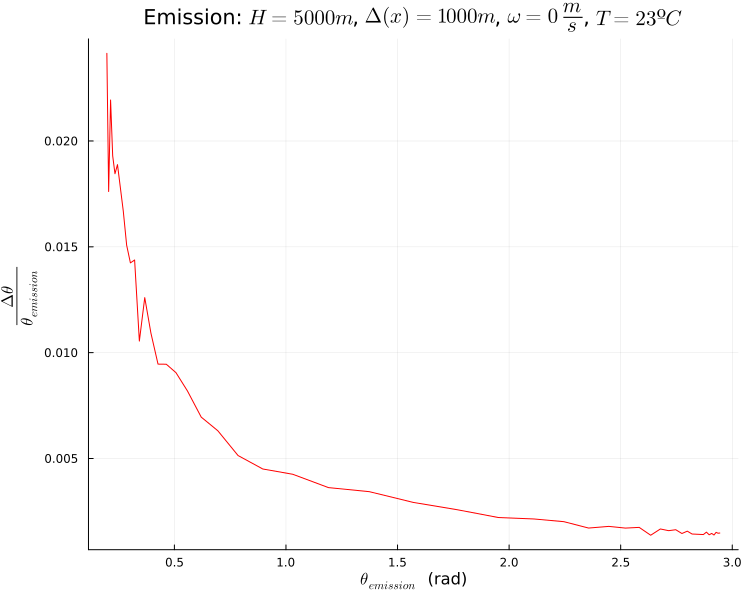

In [42]:
using Plots

x = deg2rad.(angulo_recta_5000)
y1 = (angulo_real_5000 - angulo_recta_5000)./angulo_recta_5000
y2=deepcopy(errores_relativos_5000)
using Plots

p = plot(x, y1, 
         xlabel=raw"$\theta_{emission}$  (rad)", 
         ylabel=raw"$\frac{\Delta \theta}{\theta_{emission}}$ ",
         title=raw"Emission: $H=5000m$, $\Delta (x)=1000m$, $\omega=0 \frac{m}{s}$, $T=23ºC$",size=(750,600),color=:red,
         legend=false)

# Guardar la gráfica en un archivo
savefig(p, "C:\\Users\\Miguel\\Desktop\\TFM\\Ángulos_Probables_Theta\\altitud5000.png")

q = plot(x, y2, 
         xlabel=raw"$\theta_{emission}$  ", 
         ylabel=raw"Relative Error (%)",
         title=raw"Emission: $H=5000m$, $\Delta (x)=1000m$, $\omega=0 \frac{m}{s}$, $T=23ºC$",color=:green,
         legend=false)

# Guardar la gráfica en un archivo
savefig(q, "C:\\Users\\Miguel\\Desktop\\TFM\\Ángulos_Probables_Theta\\erroresaltitud5000.png")
p

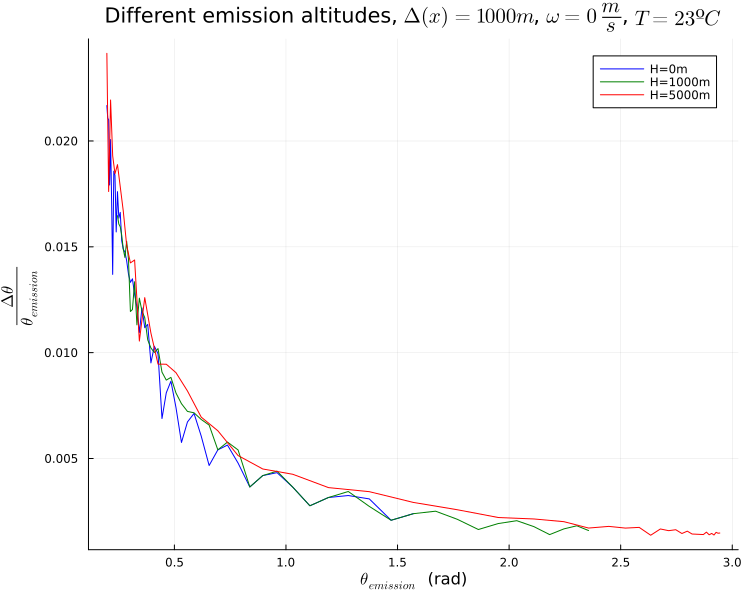

In [43]:
y1=(angulo_real - angulo_recta)./angulo_recta
p = plot(deg2rad.(angulo_recta), y1, 
         xlabel=raw"$\theta_{emission}$  (rad)", 
         ylabel=raw"$\frac{\Delta \theta}{\theta_{emission}}$ ",
         title=raw"Different emission altitudes, $\Delta (x)=1000m$, $\omega=0 \frac{m}{s}$, $T=23ºC$",size=(750,600),color=:blue,
         label=raw"H=0m")
y2=(angulo_real_1000 - angulo_recta_1000)./angulo_recta_1000
plot!(deg2rad.(angulo_recta_1000), y2, color=:green,
         label=raw"H=1000m")
y3 = (angulo_real_5000 - angulo_recta_5000)./angulo_recta_5000
plot!(deg2rad.(angulo_recta_5000), y3, color=:red,
         label=raw"H=5000m")
# Guardar la gráfica en un archivo
savefig(p, "C:\\Users\\Miguel\\Desktop\\TFM\\Ángulos_Probables_Theta\\DiferentesAltitudesEmisión.png")
p

Vemos que la variación en el ángulo polar aumenta un poco con la altitud. Pero son variaciones muy pequeñas. Veamos para distancias en X mayores.

In [44]:
using LinearAlgebra
using DifferentialEquations


E_rel=  0.01
T = 23.
v_wind =[0.,0.,0.]
Source = [0.,0.,5000.]
function phi(Point1::Array{Float64, 1}, Point2::Array{Float64, 1}, v_wind::Array{Float64, 1}, tau) 
        #tgphi= (Point2[2]-Point1[2]- v_wind[2]*tau)/(Point2[1]-Point1[1]- v_wind[1]*tau) #Cálculo phi primera iteración
        #phi=rad2deg(atan(tgphi))
        phi=rad2deg(atan((Point2[2]-Point1[2]- v_wind[2]*tau),(Point2[1]-Point1[1]- v_wind[1]*tau)))
        return phi
end
function Slowness_Spherical(Point1::Array{Float64, 1}, Point2::Array{Float64, 1}, v_wind::Array{Float64, 1}, phi, c_source)
    x1,y1,z1=Point2-Point1 #Obtención parámetros primera iteración
    r=norm(Point2-Point1)
    theta=rad2deg(acos(z1/r))
    q0=1/(c_source + (v_wind[1]*cosd(phi)+ v_wind[2]*sind(phi))*cosd(theta) )
    qx=q0*cosd(phi)*sind(theta)
    qy=q0*sind(phi)*sind(theta)
    qz=q0*cosd(theta)
    return q0,qx,qy,qz,theta
end
function c_z(T,z) 
    if z>0
        c_air=331*sqrt((T+273.15-z/200)/273.15) #Modelo termodinámico v_sonido.Introduzco T_Z0 en grados centígrados por comodidad
    else
        c_air=331*sqrt((T+273.15)/273.15)
    end
    return c_air
end
function g!(dg, g, p, t)
    qx,qy = p
    q_aux = sqrt(qx^2 + qy^2 + g[4]^2)
    c=c_z(T,g[3])
    dg[1] = c*qx/q_aux + v_wind[1] #Variación coordenada X
    dg[2] = c*qy/q_aux + v_wind[2]  #Variación coordenada Y
    dg[3] = c*g[4]/q_aux + v_wind[3] #Variación coordenada Z
    dg[4]=+q_aux*(331^2/(400*273.15))/c #Variación qz
end
#### Necesitamos una velocidad inicial, correspondiente a la fuente, y un ángulo azimutal para empezar a iterar.
c_source=c_z(T, Source[3])
####
angulo_recta_5000_3000=[]
angulo_real_5000_3000= []
errores_relativos_5000_3000=[]
@time begin
for n in 0:50
    Receiver = [3000.,0.,200*n]
    R=norm(Receiver-Source)
    t_min=R/c_z(T,min(Source[3],Receiver[3]))
    t_max=R/c_z(T, max(Source[3],Receiver[3]))
    phi1=phi(Source,Receiver,v_wind, t_max) #Acotación teórica phi
    phi2=phi(Source,Receiver,v_wind, t_min) #Acotación teórica phi
    phi_i=(phi1+phi2)/2 #La media de la cota de phi como phi para la primera iteración
    #######
    q0,q_x,q_y,q_z,theta_i=Slowness_Spherical(Source,Receiver,v_wind, phi_i, c_source) #Obtención parámetros
    push!(angulo_recta_5000_3000,theta_i)
    #######
    traveltime=[]
    detener = 0 # Variable de control
    for l in 1:10
        if detener==1
            break
        end     
        thetas= range(theta_i-25/(2^(l-1)), theta_i+25/(2^(l-1)), 50);
        if v_wind==[0.,0.,0.]
                phis=[deepcopy(phi_i)]
        else
            if l==1
                phis=(min(phi1,phi2):0.05:max(phi1,phi2))
            else
                phi_distance=max(phi1,phi2)-min(phi1,phi2)
                phis= range(phi_i-phi_distance/(2^(l)), theta_i-phi_distance/(2^(l)), 20);
            end
        end
        angulos_theta = []
        angulos_phi = []
        tiempos = []
        for i in 1:length(thetas)
            for j in 1:length(phis)
                if l>1
                    q0=1/(c_source + (v_wind[1]*cosd(phi_i)+ v_wind[2]*sind(phi_i))*cosd(theta_i) )
                end
                q_x=q0*cosd(phis[j])*sind(thetas[i])
                q_y=q0*sind(phis[j])*sind(thetas[i])
                q_z=q0*cosd(thetas[i])
                p = [q_x, q_y]
                u0 = [Source[1],Source[2],Source[3], q_z]
                tspan=[0,t_max]
                prob = ODEProblem(g!, u0, tspan, p)
                paso=1e-2*R/2000
                sol = solve(prob, RK4(), dt=paso, saveat=0:paso:t_max)
                for k in 1:length(sol.u)
                    if detener==0
                        if sqrt((sol.u[k][1] - Receiver[1])^2 +(sol.u[k][2] - Receiver[2])^2 + (sol.u[k][3] - Receiver[3])^2 ) < R/(20*2^(l-1))
                            push!(angulos_theta, thetas[i])
                            push!(angulos_phi, phis[j])
                            push!(tiempos, sol.t[k])
                            break
                        elseif sqrt((sol.u[k][1] - Receiver[1])^2 +(sol.u[k][2] - Receiver[2])^2 + (sol.u[k][3] - Receiver[3])^2 ) < R*E_rel/100
                            traveltime = sol.t[k] #Error relativo menor a 0.01% ya detenemos el barrido
                            theta_i = thetas[i]
                            phi_i = phis[j]
                            detener = 1 # Cambiamos el valor de la variable de control
                            println("Se alcanzó el error relativo objetivo.")
                            break
                        end
                    else
                        break
                    end
                end
            end
        end
        if length(tiempos)==0
            if l==1
                println("No se encontró ninguna trayectoria entre fuente y receptor. Valora si estás en una zona de sombra o ajusta el paso de tiempo ")
            end
            break
        elseif detener==0
            traveltime = findmin(tiempos)
            indice = argmin(tiempos)
            theta_i=angulos_theta[indice]
            phi_i=angulos_phi[indice]
        end
    end
    push!(angulo_real_5000_3000,theta_i)
    q_x=q0*cosd(phi_i)*sind(theta_i)
    q_y=q0*sind(phi_i)*sind(theta_i)
    q_z=q0*cosd(theta_i)
    # Definir los parámetros
    p = [q_x, q_y]
    u0 = [Source[1],Source[2], Source[3], q_z]
    tspan=[0,traveltime[1]]
    # Crear el problema ODE
    prob = ODEProblem(g!, u0, tspan, p)
    # Resolver el problema ODE
    paso=1e-2*R/2000
    sol = solve(prob, RK4(), dt=paso, saveat=0:paso:traveltime[1])
    error_relativo_n=(sqrt((sol.u[end][1] - Receiver[1])^2 +(sol.u[end][2] - Receiver[2])^2 + (sol.u[end][3] - Receiver[3])^2 )/R)*100
    push!(errores_relativos_5000_3000,error_relativo_n)
end
end

Se alcanzó el error relativo objetivo.
Se alcanzó el error relativo objetivo.
 43.446079 seconds (555.41 M allocations: 30.545 GiB, 14.33% gc time, 0.25% compilation time: 67% of which was recompilation)


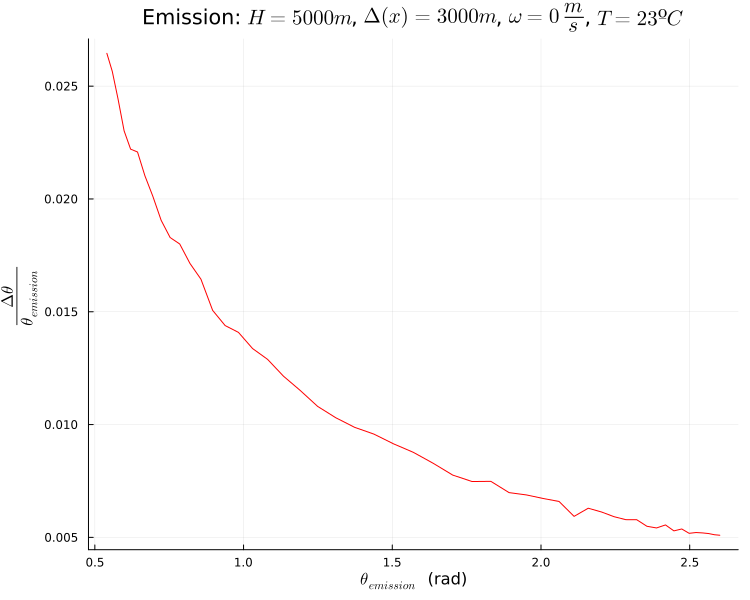

In [51]:
using Plots

x = deg2rad.(angulo_recta_5000_3000)
y1 = (angulo_real_5000_3000 - angulo_recta_5000_3000)./angulo_recta_5000_3000
y2=deepcopy(errores_relativos_5000_3000)
using Plots

p = plot(x, y1, 
         xlabel=raw"$\theta_{emission}$  (rad)", 
         ylabel=raw"$\frac{\Delta \theta}{\theta_{emission}}$ ",
         title=raw"Emission: $H=5000m$, $\Delta (x)=3000m$, $\omega=0 \frac{m}{s}$, $T=23ºC$",size=(750,600),color=:red,
         legend=false)

# Guardar la gráfica en un archivo
savefig(p, "C:\\Users\\Miguel\\Desktop\\TFM\\Ángulos_Probables_Theta\\altitud5000_x3000.png")

q = plot(x, y2, 
         xlabel=raw"$\theta_{emission}$  ", 
         ylabel=raw"Relative Error (%)",
         title=raw"Emission: $H=5000m$, $\Delta (x)=3000m$, $\omega=0 \frac{m}{s}$, $T=23ºC$",color=:green,
         legend=false)

# Guardar la gráfica en un archivo
savefig(q, "C:\\Users\\Miguel\\Desktop\\TFM\\Ángulos_Probables_Theta\\erroresaltitud5000_x3000.png")
p

In [52]:
using LinearAlgebra
using DifferentialEquations


E_rel=  0.01
T = 23.
v_wind =[0.,0.,0.]
Source = [0.,0.,5000.]
function phi(Point1::Array{Float64, 1}, Point2::Array{Float64, 1}, v_wind::Array{Float64, 1}, tau) 
        #tgphi= (Point2[2]-Point1[2]- v_wind[2]*tau)/(Point2[1]-Point1[1]- v_wind[1]*tau) #Cálculo phi primera iteración
        #phi=rad2deg(atan(tgphi))
        phi=rad2deg(atan((Point2[2]-Point1[2]- v_wind[2]*tau),(Point2[1]-Point1[1]- v_wind[1]*tau)))
        return phi
end
function Slowness_Spherical(Point1::Array{Float64, 1}, Point2::Array{Float64, 1}, v_wind::Array{Float64, 1}, phi, c_source)
    x1,y1,z1=Point2-Point1 #Obtención parámetros primera iteración
    r=norm(Point2-Point1)
    theta=rad2deg(acos(z1/r))
    q0=1/(c_source + (v_wind[1]*cosd(phi)+ v_wind[2]*sind(phi))*cosd(theta) )
    qx=q0*cosd(phi)*sind(theta)
    qy=q0*sind(phi)*sind(theta)
    qz=q0*cosd(theta)
    return q0,qx,qy,qz,theta
end
function c_z(T,z) 
    if z>0
        c_air=331*sqrt((T+273.15-z/200)/273.15) #Modelo termodinámico v_sonido.Introduzco T_Z0 en grados centígrados por comodidad
    else
        c_air=331*sqrt((T+273.15)/273.15)
    end
    return c_air
end
function g!(dg, g, p, t)
    qx,qy = p
    q_aux = sqrt(qx^2 + qy^2 + g[4]^2)
    c=c_z(T,g[3])
    dg[1] = c*qx/q_aux + v_wind[1] #Variación coordenada X
    dg[2] = c*qy/q_aux + v_wind[2]  #Variación coordenada Y
    dg[3] = c*g[4]/q_aux + v_wind[3] #Variación coordenada Z
    dg[4]=+q_aux*(331^2/(400*273.15))/c #Variación qz
end
#### Necesitamos una velocidad inicial, correspondiente a la fuente, y un ángulo azimutal para empezar a iterar.
c_source=c_z(T, Source[3])
####
angulo_recta_5000_5000=[]
angulo_real_5000_5000= []
errores_relativos_5000_5000=[]
@time begin
for n in 0:50
    Receiver = [5000.,0.,200*n]
    R=norm(Receiver-Source)
    t_min=R/c_z(T,min(Source[3],Receiver[3]))
    t_max=R/c_z(T, max(Source[3],Receiver[3]))
    phi1=phi(Source,Receiver,v_wind, t_max) #Acotación teórica phi
    phi2=phi(Source,Receiver,v_wind, t_min) #Acotación teórica phi
    phi_i=(phi1+phi2)/2 #La media de la cota de phi como phi para la primera iteración
    #######
    q0,q_x,q_y,q_z,theta_i=Slowness_Spherical(Source,Receiver,v_wind, phi_i, c_source) #Obtención parámetros
    push!(angulo_recta_5000_5000,theta_i)
    #######
    traveltime=[]
    detener = 0 # Variable de control
    for l in 1:10
        if detener==1
            break
        end     
        thetas= range(theta_i-25/(2^(l-1)), theta_i+25/(2^(l-1)), 50);
        if v_wind==[0.,0.,0.]
                phis=[deepcopy(phi_i)]
        else
            if l==1
                phis=(min(phi1,phi2):0.05:max(phi1,phi2))
            else
                phi_distance=max(phi1,phi2)-min(phi1,phi2)
                phis= range(phi_i-phi_distance/(2^(l)), theta_i-phi_distance/(2^(l)), 20);
            end
        end
        angulos_theta = []
        angulos_phi = []
        tiempos = []
        for i in 1:length(thetas)
            for j in 1:length(phis)
                if l>1
                    q0=1/(c_source + (v_wind[1]*cosd(phi_i)+ v_wind[2]*sind(phi_i))*cosd(theta_i) )
                end
                q_x=q0*cosd(phis[j])*sind(thetas[i])
                q_y=q0*sind(phis[j])*sind(thetas[i])
                q_z=q0*cosd(thetas[i])
                p = [q_x, q_y]
                u0 = [Source[1],Source[2],Source[3], q_z]
                tspan=[0,t_max]
                prob = ODEProblem(g!, u0, tspan, p)
                paso=1e-2*R/2000
                sol = solve(prob, RK4(), dt=paso, saveat=0:paso:t_max)
                for k in 1:length(sol.u)
                    if detener==0
                        if sqrt((sol.u[k][1] - Receiver[1])^2 +(sol.u[k][2] - Receiver[2])^2 + (sol.u[k][3] - Receiver[3])^2 ) < R/(20*2^(l-1))
                            push!(angulos_theta, thetas[i])
                            push!(angulos_phi, phis[j])
                            push!(tiempos, sol.t[k])
                            break
                        elseif sqrt((sol.u[k][1] - Receiver[1])^2 +(sol.u[k][2] - Receiver[2])^2 + (sol.u[k][3] - Receiver[3])^2 ) < R*E_rel/100
                            traveltime = sol.t[k] #Error relativo menor a 0.01% ya detenemos el barrido
                            theta_i = thetas[i]
                            phi_i = phis[j]
                            detener = 1 # Cambiamos el valor de la variable de control
                            println("Se alcanzó el error relativo objetivo.")
                            break
                        end
                    else
                        break
                    end
                end
            end
        end
        if length(tiempos)==0
            if l==1
                println("No se encontró ninguna trayectoria entre fuente y receptor. Valora si estás en una zona de sombra o ajusta el paso de tiempo ")
            end
            break
        elseif detener==0
            traveltime = findmin(tiempos)
            indice = argmin(tiempos)
            theta_i=angulos_theta[indice]
            phi_i=angulos_phi[indice]
        end
    end
    push!(angulo_real_5000_5000,theta_i)
    q_x=q0*cosd(phi_i)*sind(theta_i)
    q_y=q0*sind(phi_i)*sind(theta_i)
    q_z=q0*cosd(theta_i)
    # Definir los parámetros
    p = [q_x, q_y]
    u0 = [Source[1],Source[2], Source[3], q_z]
    tspan=[0,traveltime[1]]
    # Crear el problema ODE
    prob = ODEProblem(g!, u0, tspan, p)
    # Resolver el problema ODE
    paso=1e-2*R/2000
    sol = solve(prob, RK4(), dt=paso, saveat=0:paso:traveltime[1])
    error_relativo_n=(sqrt((sol.u[end][1] - Receiver[1])^2 +(sol.u[end][2] - Receiver[2])^2 + (sol.u[end][3] - Receiver[3])^2 )/R)*100
    push!(errores_relativos_5000_5000,error_relativo_n)
end
end

Se alcanzó el error relativo objetivo.
 57.436675 seconds (560.08 M allocations: 30.788 GiB, 12.76% gc time, 0.18% compilation time: 68% of which was recompilation)


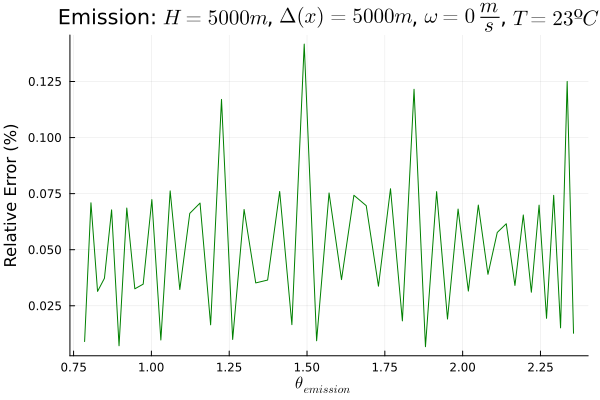

In [54]:
using Plots

x = deg2rad.(angulo_recta_5000_5000)
y1 = (angulo_real_5000_5000 - angulo_recta_5000_5000)./angulo_recta_5000_5000
y2=deepcopy(errores_relativos_5000_5000)
using Plots

p = plot(x, y1, 
         xlabel=raw"$\theta_{emission}$  (rad)", 
         ylabel=raw"$\frac{\Delta \theta}{\theta_{emission}}$ ",
         title=raw"Emission: $H=5000m$, $\Delta (x)=5000m$, $\omega=0 \frac{m}{s}$, $T=23ºC$",size=(750,600),color=:red,
         legend=false)

# Guardar la gráfica en un archivo
savefig(p, "C:\\Users\\Miguel\\Desktop\\TFM\\Ángulos_Probables_Theta\\altitud5000_x5000.png")

q = plot(x, y2, 
         xlabel=raw"$\theta_{emission}$  ", 
         ylabel=raw"Relative Error (%)",
         title=raw"Emission: $H=5000m$, $\Delta (x)=5000m$, $\omega=0 \frac{m}{s}$, $T=23ºC$",color=:green,
         legend=false)

# Guardar la gráfica en un archivo
savefig(q, "C:\\Users\\Miguel\\Desktop\\TFM\\Ángulos_Probables_Theta\\erroresaltitud5000_x5000.png")
q

In [55]:
using LinearAlgebra
using DifferentialEquations


E_rel=  0.01
T = 23.
v_wind =[0.,0.,0.]
Source = [0.,0.,5000.]
function phi(Point1::Array{Float64, 1}, Point2::Array{Float64, 1}, v_wind::Array{Float64, 1}, tau) 
        #tgphi= (Point2[2]-Point1[2]- v_wind[2]*tau)/(Point2[1]-Point1[1]- v_wind[1]*tau) #Cálculo phi primera iteración
        #phi=rad2deg(atan(tgphi))
        phi=rad2deg(atan((Point2[2]-Point1[2]- v_wind[2]*tau),(Point2[1]-Point1[1]- v_wind[1]*tau)))
        return phi
end
function Slowness_Spherical(Point1::Array{Float64, 1}, Point2::Array{Float64, 1}, v_wind::Array{Float64, 1}, phi, c_source)
    x1,y1,z1=Point2-Point1 #Obtención parámetros primera iteración
    r=norm(Point2-Point1)
    theta=rad2deg(acos(z1/r))
    q0=1/(c_source + (v_wind[1]*cosd(phi)+ v_wind[2]*sind(phi))*cosd(theta) )
    qx=q0*cosd(phi)*sind(theta)
    qy=q0*sind(phi)*sind(theta)
    qz=q0*cosd(theta)
    return q0,qx,qy,qz,theta
end
function c_z(T,z) 
    if z>0
        c_air=331*sqrt((T+273.15-z/200)/273.15) #Modelo termodinámico v_sonido.Introduzco T_Z0 en grados centígrados por comodidad
    else
        c_air=331*sqrt((T+273.15)/273.15)
    end
    return c_air
end
function g!(dg, g, p, t)
    qx,qy = p
    q_aux = sqrt(qx^2 + qy^2 + g[4]^2)
    c=c_z(T,g[3])
    dg[1] = c*qx/q_aux + v_wind[1] #Variación coordenada X
    dg[2] = c*qy/q_aux + v_wind[2]  #Variación coordenada Y
    dg[3] = c*g[4]/q_aux + v_wind[3] #Variación coordenada Z
    dg[4]=+q_aux*(331^2/(400*273.15))/c #Variación qz
end
#### Necesitamos una velocidad inicial, correspondiente a la fuente, y un ángulo azimutal para empezar a iterar.
c_source=c_z(T, Source[3])
####
angulo_recta_5000_10000=[]
angulo_real_5000_10000= []
errores_relativos_5000_10000=[]
@time begin
for n in 0:50
    Receiver = [10000.,0.,200*n]
    R=norm(Receiver-Source)
    t_min=R/c_z(T,min(Source[3],Receiver[3]))
    t_max=R/c_z(T, max(Source[3],Receiver[3]))
    phi1=phi(Source,Receiver,v_wind, t_max) #Acotación teórica phi
    phi2=phi(Source,Receiver,v_wind, t_min) #Acotación teórica phi
    phi_i=(phi1+phi2)/2 #La media de la cota de phi como phi para la primera iteración
    #######
    q0,q_x,q_y,q_z,theta_i=Slowness_Spherical(Source,Receiver,v_wind, phi_i, c_source) #Obtención parámetros
    push!(angulo_recta_5000_10000,theta_i)
    #######
    traveltime=[]
    detener = 0 # Variable de control
    for l in 1:10
        if detener==1
            break
        end     
        thetas= range(theta_i-25/(2^(l-1)), theta_i+25/(2^(l-1)), 50);
        if v_wind==[0.,0.,0.]
                phis=[deepcopy(phi_i)]
        else
            if l==1
                phis=(min(phi1,phi2):0.05:max(phi1,phi2))
            else
                phi_distance=max(phi1,phi2)-min(phi1,phi2)
                phis= range(phi_i-phi_distance/(2^(l)), theta_i-phi_distance/(2^(l)), 20);
            end
        end
        angulos_theta = []
        angulos_phi = []
        tiempos = []
        for i in 1:length(thetas)
            for j in 1:length(phis)
                if l>1
                    q0=1/(c_source + (v_wind[1]*cosd(phi_i)+ v_wind[2]*sind(phi_i))*cosd(theta_i) )
                end
                q_x=q0*cosd(phis[j])*sind(thetas[i])
                q_y=q0*sind(phis[j])*sind(thetas[i])
                q_z=q0*cosd(thetas[i])
                p = [q_x, q_y]
                u0 = [Source[1],Source[2],Source[3], q_z]
                tspan=[0,t_max]
                prob = ODEProblem(g!, u0, tspan, p)
                paso=1e-2*R/2000
                sol = solve(prob, RK4(), dt=paso, saveat=0:paso:t_max)
                for k in 1:length(sol.u)
                    if detener==0
                        if sqrt((sol.u[k][1] - Receiver[1])^2 +(sol.u[k][2] - Receiver[2])^2 + (sol.u[k][3] - Receiver[3])^2 ) < R/(20*2^(l-1))
                            push!(angulos_theta, thetas[i])
                            push!(angulos_phi, phis[j])
                            push!(tiempos, sol.t[k])
                            break
                        elseif sqrt((sol.u[k][1] - Receiver[1])^2 +(sol.u[k][2] - Receiver[2])^2 + (sol.u[k][3] - Receiver[3])^2 ) < R*E_rel/100
                            traveltime = sol.t[k] #Error relativo menor a 0.01% ya detenemos el barrido
                            theta_i = thetas[i]
                            phi_i = phis[j]
                            detener = 1 # Cambiamos el valor de la variable de control
                            println("Se alcanzó el error relativo objetivo.")
                            break
                        end
                    else
                        break
                    end
                end
            end
        end
        if length(tiempos)==0
            if l==1
                println("No se encontró ninguna trayectoria entre fuente y receptor. Valora si estás en una zona de sombra o ajusta el paso de tiempo ")
            end
            break
        elseif detener==0
            traveltime = findmin(tiempos)
            indice = argmin(tiempos)
            theta_i=angulos_theta[indice]
            phi_i=angulos_phi[indice]
        end
    end
    push!(angulo_real_5000_10000,theta_i)
    q_x=q0*cosd(phi_i)*sind(theta_i)
    q_y=q0*sind(phi_i)*sind(theta_i)
    q_z=q0*cosd(theta_i)
    # Definir los parámetros
    p = [q_x, q_y]
    u0 = [Source[1],Source[2], Source[3], q_z]
    tspan=[0,traveltime[1]]
    # Crear el problema ODE
    prob = ODEProblem(g!, u0, tspan, p)
    # Resolver el problema ODE
    paso=1e-2*R/2000
    sol = solve(prob, RK4(), dt=paso, saveat=0:paso:traveltime[1])
    error_relativo_n=(sqrt((sol.u[end][1] - Receiver[1])^2 +(sol.u[end][2] - Receiver[2])^2 + (sol.u[end][3] - Receiver[3])^2 )/R)*100
    push!(errores_relativos_5000_10000,error_relativo_n)
end
end

Se alcanzó el error relativo objetivo.
 68.265233 seconds (561.56 M allocations: 30.755 GiB, 12.00% gc time, 0.19% compilation time: 68% of which was recompilation)


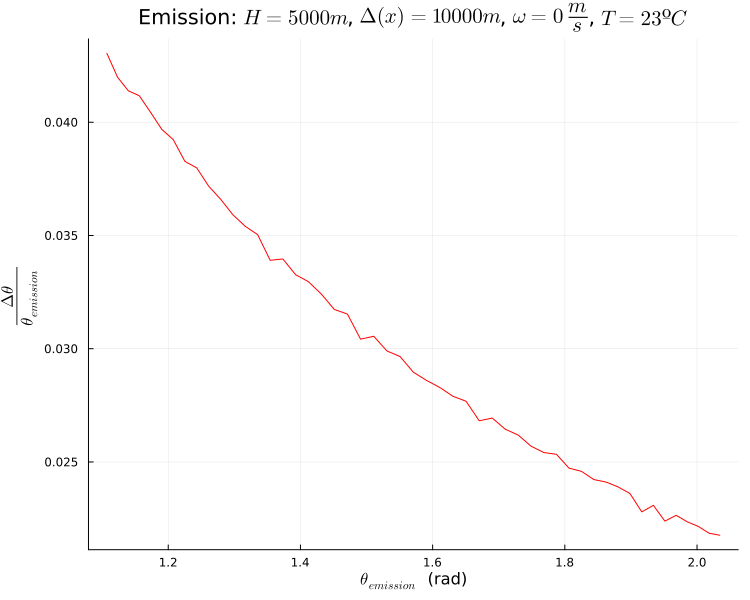

In [57]:
using Plots

x = deg2rad.(angulo_recta_5000_10000)
y1 = (angulo_real_5000_10000 - angulo_recta_5000_10000)./angulo_recta_5000_10000
y2=deepcopy(errores_relativos_5000_10000)
using Plots

p = plot(x, y1, 
         xlabel=raw"$\theta_{emission}$  (rad)", 
         ylabel=raw"$\frac{\Delta \theta}{\theta_{emission}}$ ",
         title=raw"Emission: $H=5000m$, $\Delta (x)=10000m$, $\omega=0 \frac{m}{s}$, $T=23ºC$",size=(750,600),color=:red,
         legend=false)

# Guardar la gráfica en un archivo
savefig(p, "C:\\Users\\Miguel\\Desktop\\TFM\\Ángulos_Probables_Theta\\altitud5000_x10000.png")

q = plot(x, y2, 
         xlabel=raw"$\theta_{emission}$  ", 
         ylabel=raw"Relative Error (%)",
         title=raw"Emission: $H=5000m$, $\Delta (x)=10000m$, $\omega=0 \frac{m}{s}$, $T=23ºC$",color=:green,
         legend=false)

# Guardar la gráfica en un archivo
savefig(q, "C:\\Users\\Miguel\\Desktop\\TFM\\Ángulos_Probables_Theta\\erroresaltitud5000_x10000.png")
p

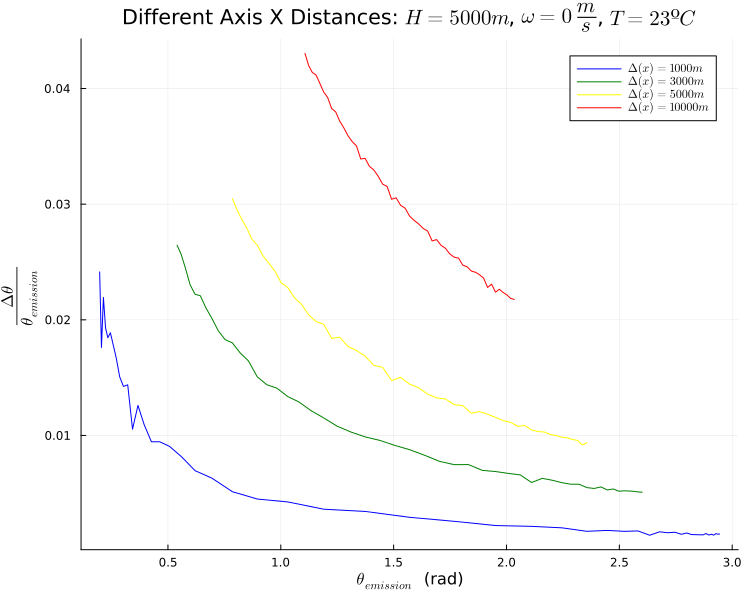

In [59]:
y4=(angulo_real_5000 - angulo_recta_5000)./angulo_recta_5000
p = plot(deg2rad.(angulo_recta_5000), y4, 
         xlabel=raw"$\theta_{emission}$  (rad)", 
         ylabel=raw"$\frac{\Delta \theta}{\theta_{emission}}$ ",
         title=raw"Different Axis X Distances: $H=5000m$, $\omega=0 \frac{m}{s}$, $T=23ºC$",size=(750,600),color=:blue,
         label=raw"$\Delta (x)=1000m$")
y5=(angulo_real_5000_3000 - angulo_recta_5000_3000)./angulo_recta_5000_3000
plot!(deg2rad.(angulo_recta_5000_3000), y5, color=:green,
         label=raw"$\Delta (x)=3000m$")
y6=(angulo_real_5000_5000 - angulo_recta_5000_5000)./angulo_recta_5000_5000
plot!(deg2rad.(angulo_recta_5000_5000), y6, color=:yellow,
         label=raw"$\Delta (x)=5000m$")
y7=(angulo_real_5000_10000 - angulo_recta_5000_10000)./angulo_recta_5000_10000
plot!(deg2rad.(angulo_recta_5000_10000), y7, color=:red,
         label=raw"$\Delta (x)=10000m$")
# Guardar la gráfica en un archivo
savefig(p, "C:\\Users\\Miguel\\Desktop\\TFM\\Ángulos_Probables_Theta\\ComparativaDistancias.png")
p

Sin viento parece que podemos acotar bastante más el ángulo polar. 

# Variación Viento

In [60]:
using LinearAlgebra
using DifferentialEquations


E_rel=  0.01
T = 23.
v_wind =[0.,0.,1.]
Source = [0.,0.,5000.]
function phi(Point1::Array{Float64, 1}, Point2::Array{Float64, 1}, v_wind::Array{Float64, 1}, tau) 
        #tgphi= (Point2[2]-Point1[2]- v_wind[2]*tau)/(Point2[1]-Point1[1]- v_wind[1]*tau) #Cálculo phi primera iteración
        #phi=rad2deg(atan(tgphi))
        phi=rad2deg(atan((Point2[2]-Point1[2]- v_wind[2]*tau),(Point2[1]-Point1[1]- v_wind[1]*tau)))
        return phi
end
function Slowness_Spherical(Point1::Array{Float64, 1}, Point2::Array{Float64, 1}, v_wind::Array{Float64, 1}, phi, c_source)
    x1,y1,z1=Point2-Point1 #Obtención parámetros primera iteración
    r=norm(Point2-Point1)
    theta=rad2deg(acos(z1/r))
    q0=1/(c_source + (v_wind[1]*cosd(phi)+ v_wind[2]*sind(phi))*cosd(theta) )
    qx=q0*cosd(phi)*sind(theta)
    qy=q0*sind(phi)*sind(theta)
    qz=q0*cosd(theta)
    return q0,qx,qy,qz,theta
end
function c_z(T,z) 
    if z>0
        c_air=331*sqrt((T+273.15-z/200)/273.15) #Modelo termodinámico v_sonido.Introduzco T_Z0 en grados centígrados por comodidad
    else
        c_air=331*sqrt((T+273.15)/273.15)
    end
    return c_air
end
function g!(dg, g, p, t)
    qx,qy = p
    q_aux = sqrt(qx^2 + qy^2 + g[4]^2)
    c=c_z(T,g[3])
    dg[1] = c*qx/q_aux + v_wind[1] #Variación coordenada X
    dg[2] = c*qy/q_aux + v_wind[2]  #Variación coordenada Y
    dg[3] = c*g[4]/q_aux + v_wind[3] #Variación coordenada Z
    dg[4]=+q_aux*(331^2/(400*273.15))/c #Variación qz
end
#### Necesitamos una velocidad inicial, correspondiente a la fuente, y un ángulo azimutal para empezar a iterar.
c_source=c_z(T, Source[3])
####
angulo_recta_5000_5000_1=[]
angulo_real_5000_5000_1= []
errores_relativos_5000_5000_1=[]
@time begin
for n in 0:50
    Receiver = [5000.,0.,200*n]
    R=norm(Receiver-Source)
    t_min=R/c_z(T,min(Source[3],Receiver[3]))
    t_max=R/c_z(T, max(Source[3],Receiver[3]))
    phi1=phi(Source,Receiver,v_wind, t_max) #Acotación teórica phi
    phi2=phi(Source,Receiver,v_wind, t_min) #Acotación teórica phi
    phi_i=(phi1+phi2)/2 #La media de la cota de phi como phi para la primera iteración
    #######
    q0,q_x,q_y,q_z,theta_i=Slowness_Spherical(Source,Receiver,v_wind, phi_i, c_source) #Obtención parámetros
    push!(angulo_recta_5000_5000_1,theta_i)
    #######
    traveltime=[]
    detener = 0 # Variable de control
    for l in 1:10
        if detener==1
            break
        end     
        thetas= range(theta_i-25/(2^(l-1)), theta_i+25/(2^(l-1)), 50);
        if v_wind==[0.,0.,0.]
                phis=[deepcopy(phi_i)]
        else
            if l==1
                phis=(min(phi1,phi2):0.05:max(phi1,phi2))
            else
                phi_distance=max(phi1,phi2)-min(phi1,phi2)
                phis= range(phi_i-phi_distance/(2^(l)), theta_i-phi_distance/(2^(l)), 20);
            end
        end
        angulos_theta = []
        angulos_phi = []
        tiempos = []
        for i in 1:length(thetas)
            for j in 1:length(phis)
                if l>1
                    q0=1/(c_source + (v_wind[1]*cosd(phi_i)+ v_wind[2]*sind(phi_i))*cosd(theta_i) )
                end
                q_x=q0*cosd(phis[j])*sind(thetas[i])
                q_y=q0*sind(phis[j])*sind(thetas[i])
                q_z=q0*cosd(thetas[i])
                p = [q_x, q_y]
                u0 = [Source[1],Source[2],Source[3], q_z]
                tspan=[0,t_max]
                prob = ODEProblem(g!, u0, tspan, p)
                paso=1e-2*R/2000
                sol = solve(prob, RK4(), dt=paso, saveat=0:paso:t_max)
                for k in 1:length(sol.u)
                    if detener==0
                        if sqrt((sol.u[k][1] - Receiver[1])^2 +(sol.u[k][2] - Receiver[2])^2 + (sol.u[k][3] - Receiver[3])^2 ) < R/(20*2^(l-1))
                            push!(angulos_theta, thetas[i])
                            push!(angulos_phi, phis[j])
                            push!(tiempos, sol.t[k])
                            break
                        elseif sqrt((sol.u[k][1] - Receiver[1])^2 +(sol.u[k][2] - Receiver[2])^2 + (sol.u[k][3] - Receiver[3])^2 ) < R*E_rel/100
                            traveltime = sol.t[k] #Error relativo menor a 0.01% ya detenemos el barrido
                            theta_i = thetas[i]
                            phi_i = phis[j]
                            detener = 1 # Cambiamos el valor de la variable de control
                            println("Se alcanzó el error relativo objetivo.")
                            break
                        end
                    else
                        break
                    end
                end
            end
        end
        if length(tiempos)==0
            if l==1
                println("No se encontró ninguna trayectoria entre fuente y receptor. Valora si estás en una zona de sombra o ajusta el paso de tiempo ")
            end
            break
        elseif detener==0
            traveltime = findmin(tiempos)
            indice = argmin(tiempos)
            theta_i=angulos_theta[indice]
            phi_i=angulos_phi[indice]
        end
    end
    push!(angulo_real_5000_5000_1,theta_i)
    q_x=q0*cosd(phi_i)*sind(theta_i)
    q_y=q0*sind(phi_i)*sind(theta_i)
    q_z=q0*cosd(theta_i)
    # Definir los parámetros
    p = [q_x, q_y]
    u0 = [Source[1],Source[2], Source[3], q_z]
    tspan=[0,traveltime[1]]
    # Crear el problema ODE
    prob = ODEProblem(g!, u0, tspan, p)
    # Resolver el problema ODE
    paso=1e-2*R/2000
    sol = solve(prob, RK4(), dt=paso, saveat=0:paso:traveltime[1])
    error_relativo_n=(sqrt((sol.u[end][1] - Receiver[1])^2 +(sol.u[end][2] - Receiver[2])^2 + (sol.u[end][3] - Receiver[3])^2 )/R)*100
    push!(errores_relativos_5000_5000_1,error_relativo_n)
end
end

Se alcanzó el error relativo objetivo.
Se alcanzó el error relativo objetivo.
Se alcanzó el error relativo objetivo.
669.060214 seconds (9.92 G allocations: 544.196 GiB, 14.73% gc time, 0.01% compilation time: 66% of which was recompilation)


In [ ]:
using Plots

x = deg2rad.(angulo_recta_5000_5000)
y1 = (angulo_real_5000_5000 - angulo_recta_5000_5000)./angulo_recta_5000_5000
y2=deepcopy(errores_relativos_5000_5000)
using Plots

p = plot(x, y1, 
         xlabel=raw"$\theta_{emission}$  (rad)", 
         ylabel=raw"$\frac{\Delta \theta}{\theta_{emission}}$ ",
         title=raw"Emission: $H=5000m$, $\Delta (x)=5000m$, $\omega_{z}=1 \frac{m}{s}$, $T=23ºC$",size=(750,600),color=:red,
         legend=false)

# Guardar la gráfica en un archivo
savefig(p, "C:\\Users\\Miguel\\Desktop\\TFM\\Ángulos_Probables_Theta\\w1.png")

q = plot(x, y2, 
         xlabel=raw"$\theta_{emission}$  ", 
         ylabel=raw"Relative Error (%)",
         title=raw"Emission: $H=5000m$, $\Delta (x)=5000m$, $\omega_{z}=1 \frac{m}{s}$, $T=23ºC$",color=:green,
         legend=false)

# Guardar la gráfica en un archivo
savefig(q, "C:\\Users\\Miguel\\Desktop\\TFM\\Ángulos_Probables_Theta\\erroresw1.png")
q

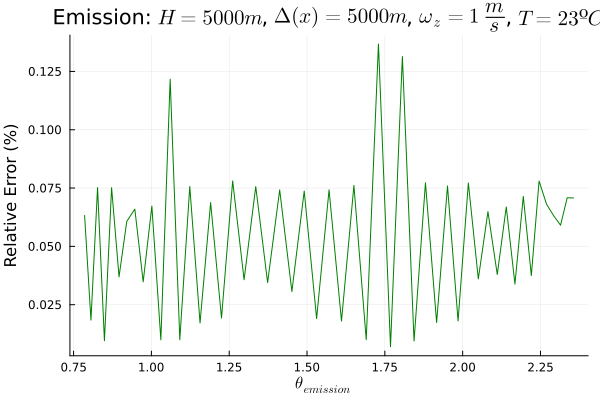

In [62]:
using Plots

x = deg2rad.(angulo_recta_5000_5000_1)
y1 = (angulo_real_5000_5000_1 - angulo_recta_5000_5000_1)./angulo_recta_5000_5000_1
y2=deepcopy(errores_relativos_5000_5000_1)
using Plots

p = plot(x, y1, 
         xlabel=raw"$\theta_{emission}$  (rad)", 
         ylabel=raw"$\frac{\Delta \theta}{\theta_{emission}}$ ",
         title=raw"Emission: $H=5000m$, $\Delta (x)=5000m$, $\omega_{z}=1 \frac{m}{s}$, $T=23ºC$",size=(750,600),color=:red,
         legend=false)

# Guardar la gráfica en un archivo
savefig(p, "C:\\Users\\Miguel\\Desktop\\TFM\\Ángulos_Probables_Theta\\w1.png")

q = plot(x, y2, 
         xlabel=raw"$\theta_{emission}$  ", 
         ylabel=raw"Relative Error (%)",
         title=raw"Emission: $H=5000m$, $\Delta (x)=5000m$, $\omega_{z}=1 \frac{m}{s}$, $T=23ºC$",color=:green,
         legend=false)

# Guardar la gráfica en un archivo
savefig(q, "C:\\Users\\Miguel\\Desktop\\TFM\\Ángulos_Probables_Theta\\erroresw1.png")
q

In [68]:
using LinearAlgebra
using DifferentialEquations


E_rel=  0.01
T = 23.
v_wind =[0.,0.,5.]
Source = [0.,0.,5000.]
function phi(Point1::Array{Float64, 1}, Point2::Array{Float64, 1}, v_wind::Array{Float64, 1}, tau) 
        #tgphi= (Point2[2]-Point1[2]- v_wind[2]*tau)/(Point2[1]-Point1[1]- v_wind[1]*tau) #Cálculo phi primera iteración
        #phi=rad2deg(atan(tgphi))
        phi=rad2deg(atan((Point2[2]-Point1[2]- v_wind[2]*tau),(Point2[1]-Point1[1]- v_wind[1]*tau)))
        return phi
end
function Slowness_Spherical(Point1::Array{Float64, 1}, Point2::Array{Float64, 1}, v_wind::Array{Float64, 1}, phi, c_source)
    x1,y1,z1=Point2-Point1 #Obtención parámetros primera iteración
    r=norm(Point2-Point1)
    theta=rad2deg(acos(z1/r))
    q0=1/(c_source + (v_wind[1]*cosd(phi)+ v_wind[2]*sind(phi))*cosd(theta) )
    qx=q0*cosd(phi)*sind(theta)
    qy=q0*sind(phi)*sind(theta)
    qz=q0*cosd(theta)
    return q0,qx,qy,qz,theta
end
function c_z(T,z) 
    if z>0
        c_air=331*sqrt((T+273.15-z/200)/273.15) #Modelo termodinámico v_sonido.Introduzco T_Z0 en grados centígrados por comodidad
    else
        c_air=331*sqrt((T+273.15)/273.15)
    end
    return c_air
end
function g!(dg, g, p, t)
    qx,qy = p
    q_aux = sqrt(qx^2 + qy^2 + g[4]^2)
    c=c_z(T,g[3])
    dg[1] = c*qx/q_aux + v_wind[1] #Variación coordenada X
    dg[2] = c*qy/q_aux + v_wind[2]  #Variación coordenada Y
    dg[3] = c*g[4]/q_aux + v_wind[3] #Variación coordenada Z
    dg[4]=+q_aux*(331^2/(400*273.15))/c #Variación qz
end
#### Necesitamos una velocidad inicial, correspondiente a la fuente, y un ángulo azimutal para empezar a iterar.
c_source=c_z(T, Source[3])
####
angulo_recta_5000_5000_5=[]
angulo_real_5000_5000_5= []
errores_relativos_5000_5000_5=[]
@time begin
for n in 0:50
    Receiver = [5000.,0.,200*n]
    R=norm(Receiver-Source)
    t_min=R/c_z(T,min(Source[3],Receiver[3]))
    t_max=R/c_z(T, max(Source[3],Receiver[3]))
    phi1=phi(Source,Receiver,v_wind, t_max) #Acotación teórica phi
    phi2=phi(Source,Receiver,v_wind, t_min) #Acotación teórica phi
    phi_i=(phi1+phi2)/2 #La media de la cota de phi como phi para la primera iteración
    #######
    q0,q_x,q_y,q_z,theta_i=Slowness_Spherical(Source,Receiver,v_wind, phi_i, c_source) #Obtención parámetros
    push!(angulo_recta_5000_5000_5,theta_i)
    #######
    traveltime=[]
    detener = 0 # Variable de control
    for l in 1:10
        if detener==1
            break
        end     
        thetas= range(theta_i-25/(2^(l-1)), theta_i+25/(2^(l-1)), 50);
        if v_wind==[0.,0.,0.]
                phis=[deepcopy(phi_i)]
        else
            if l==1
                phis=(min(phi1,phi2):0.05:max(phi1,phi2))
            else
                phi_distance=max(phi1,phi2)-min(phi1,phi2)
                phis= range(phi_i-phi_distance/(2^(l)), theta_i-phi_distance/(2^(l)), 20);
            end
        end
        angulos_theta = []
        angulos_phi = []
        tiempos = []
        for i in 1:length(thetas)
            for j in 1:length(phis)
                if l>1
                    q0=1/(c_source + (v_wind[1]*cosd(phi_i)+ v_wind[2]*sind(phi_i))*cosd(theta_i) )
                end
                q_x=q0*cosd(phis[j])*sind(thetas[i])
                q_y=q0*sind(phis[j])*sind(thetas[i])
                q_z=q0*cosd(thetas[i])
                p = [q_x, q_y]
                u0 = [Source[1],Source[2],Source[3], q_z]
                tspan=[0,t_max]
                prob = ODEProblem(g!, u0, tspan, p)
                paso=1e-2*R/2000
                sol = solve(prob, RK4(), dt=paso, saveat=0:paso:t_max)
                for k in 1:length(sol.u)
                    if detener==0
                        if sqrt((sol.u[k][1] - Receiver[1])^2 +(sol.u[k][2] - Receiver[2])^2 + (sol.u[k][3] - Receiver[3])^2 ) < R/(20*2^(l-1))
                            push!(angulos_theta, thetas[i])
                            push!(angulos_phi, phis[j])
                            push!(tiempos, sol.t[k])
                            break
                        elseif sqrt((sol.u[k][1] - Receiver[1])^2 +(sol.u[k][2] - Receiver[2])^2 + (sol.u[k][3] - Receiver[3])^2 ) < R*E_rel/100
                            traveltime = sol.t[k] #Error relativo menor a 0.01% ya detenemos el barrido
                            theta_i = thetas[i]
                            phi_i = phis[j]
                            detener = 1 # Cambiamos el valor de la variable de control
                            println("Se alcanzó el error relativo objetivo.")
                            break
                        end
                    else
                        break
                    end
                end
            end
        end
        if length(tiempos)==0
            if l==1
                println("No se encontró ninguna trayectoria entre fuente y receptor. Valora si estás en una zona de sombra o ajusta el paso de tiempo ")
            end
            break
        elseif detener==0
            traveltime = findmin(tiempos)
            indice = argmin(tiempos)
            theta_i=angulos_theta[indice]
            phi_i=angulos_phi[indice]
        end
    end
    push!(angulo_real_5000_5000_5,theta_i)
    q_x=q0*cosd(phi_i)*sind(theta_i)
    q_y=q0*sind(phi_i)*sind(theta_i)
    q_z=q0*cosd(theta_i)
    # Definir los parámetros
    p = [q_x, q_y]
    u0 = [Source[1],Source[2], Source[3], q_z]
    tspan=[0,traveltime[1]]
    # Crear el problema ODE
    prob = ODEProblem(g!, u0, tspan, p)
    # Resolver el problema ODE
    paso=1e-2*R/2000
    sol = solve(prob, RK4(), dt=paso, saveat=0:paso:traveltime[1])
    error_relativo_n=(sqrt((sol.u[end][1] - Receiver[1])^2 +(sol.u[end][2] - Receiver[2])^2 + (sol.u[end][3] - Receiver[3])^2 )/R)*100
    push!(errores_relativos_5000_5000_5,error_relativo_n)
end
end

Se alcanzó el error relativo objetivo.
Se alcanzó el error relativo objetivo.
632.053939 seconds (9.88 G allocations: 542.026 GiB, 15.44% gc time, 0.01% compilation time: 68% of which was recompilation)


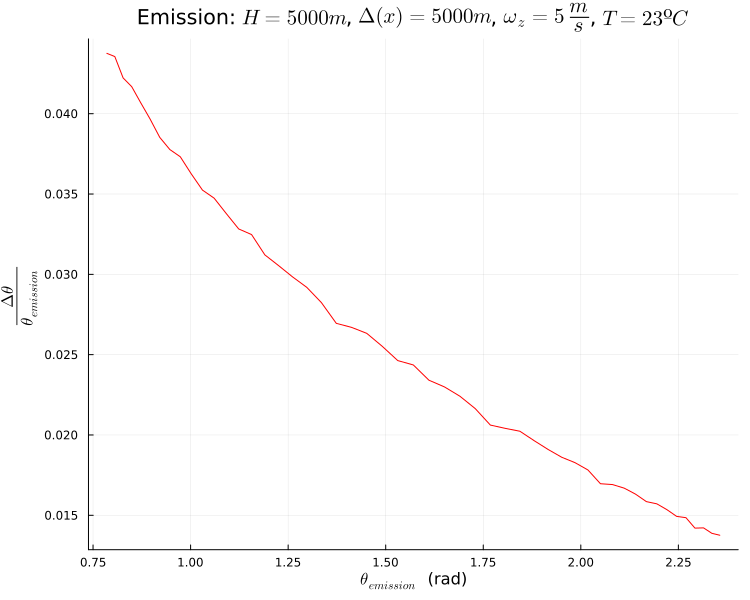

In [69]:
using Plots

x = deg2rad.(angulo_recta_5000_5000_5)
y1 = (angulo_real_5000_5000_5 - angulo_recta_5000_5000_5)./angulo_recta_5000_5000_5
y2=deepcopy(errores_relativos_5000_5000_5)
using Plots

p = plot(x, y1, 
         xlabel=raw"$\theta_{emission}$  (rad)", 
         ylabel=raw"$\frac{\Delta \theta}{\theta_{emission}}$ ",
         title=raw"Emission: $H=5000m$, $\Delta (x)=5000m$, $\omega_{z}=5 \frac{m}{s}$, $T=23ºC$",size=(750,600),color=:red,
         legend=false)

# Guardar la gráfica en un archivo
savefig(p, "C:\\Users\\Miguel\\Desktop\\TFM\\Ángulos_Probables_Theta\\w5.png")

q = plot(x, y2, 
         xlabel=raw"$\theta_{emission}$  ", 
         ylabel=raw"Relative Error (%)",
         title=raw"Emission: $H=5000m$, $\Delta (x)=5000m$, $\omega_{z}=5 \frac{m}{s}$, $T=23ºC$",color=:green,
         legend=false)

# Guardar la gráfica en un archivo
savefig(q, "C:\\Users\\Miguel\\Desktop\\TFM\\Ángulos_Probables_Theta\\erroresw5.png")
p

In [66]:
using LinearAlgebra
using DifferentialEquations


E_rel=  0.01
T = 23.
v_wind =[0.,0.,10.]
Source = [0.,0.,5000.]
function phi(Point1::Array{Float64, 1}, Point2::Array{Float64, 1}, v_wind::Array{Float64, 1}, tau) 
        #tgphi= (Point2[2]-Point1[2]- v_wind[2]*tau)/(Point2[1]-Point1[1]- v_wind[1]*tau) #Cálculo phi primera iteración
        #phi=rad2deg(atan(tgphi))
        phi=rad2deg(atan((Point2[2]-Point1[2]- v_wind[2]*tau),(Point2[1]-Point1[1]- v_wind[1]*tau)))
        return phi
end
function Slowness_Spherical(Point1::Array{Float64, 1}, Point2::Array{Float64, 1}, v_wind::Array{Float64, 1}, phi, c_source)
    x1,y1,z1=Point2-Point1 #Obtención parámetros primera iteración
    r=norm(Point2-Point1)
    theta=rad2deg(acos(z1/r))
    q0=1/(c_source + (v_wind[1]*cosd(phi)+ v_wind[2]*sind(phi))*cosd(theta) )
    qx=q0*cosd(phi)*sind(theta)
    qy=q0*sind(phi)*sind(theta)
    qz=q0*cosd(theta)
    return q0,qx,qy,qz,theta
end
function c_z(T,z) 
    if z>0
        c_air=331*sqrt((T+273.15-z/200)/273.15) #Modelo termodinámico v_sonido.Introduzco T_Z0 en grados centígrados por comodidad
    else
        c_air=331*sqrt((T+273.15)/273.15)
    end
    return c_air
end
function g!(dg, g, p, t)
    qx,qy = p
    q_aux = sqrt(qx^2 + qy^2 + g[4]^2)
    c=c_z(T,g[3])
    dg[1] = c*qx/q_aux + v_wind[1] #Variación coordenada X
    dg[2] = c*qy/q_aux + v_wind[2]  #Variación coordenada Y
    dg[3] = c*g[4]/q_aux + v_wind[3] #Variación coordenada Z
    dg[4]=+q_aux*(331^2/(400*273.15))/c #Variación qz
end
#### Necesitamos una velocidad inicial, correspondiente a la fuente, y un ángulo azimutal para empezar a iterar.
c_source=c_z(T, Source[3])
####
angulo_recta_5000_5000_10=[]
angulo_real_5000_5000_10= []
errores_relativos_5000_5000_10=[]
@time begin
for n in 0:50
    Receiver = [5000.,0.,200*n]
    R=norm(Receiver-Source)
    t_min=R/c_z(T,min(Source[3],Receiver[3]))
    t_max=R/c_z(T, max(Source[3],Receiver[3]))
    phi1=phi(Source,Receiver,v_wind, t_max) #Acotación teórica phi
    phi2=phi(Source,Receiver,v_wind, t_min) #Acotación teórica phi
    phi_i=(phi1+phi2)/2 #La media de la cota de phi como phi para la primera iteración
    #######
    q0,q_x,q_y,q_z,theta_i=Slowness_Spherical(Source,Receiver,v_wind, phi_i, c_source) #Obtención parámetros
    push!(angulo_recta_5000_5000_10,theta_i)
    #######
    traveltime=[]
    detener = 0 # Variable de control
    for l in 1:10
        if detener==1
            break
        end     
        thetas= range(theta_i-25/(2^(l-1)), theta_i+25/(2^(l-1)), 50);
        if v_wind==[0.,0.,0.]
                phis=[deepcopy(phi_i)]
        else
            if l==1
                phis=(min(phi1,phi2):0.05:max(phi1,phi2))
            else
                phi_distance=max(phi1,phi2)-min(phi1,phi2)
                phis= range(phi_i-phi_distance/(2^(l)), theta_i-phi_distance/(2^(l)), 20);
            end
        end
        angulos_theta = []
        angulos_phi = []
        tiempos = []
        for i in 1:length(thetas)
            for j in 1:length(phis)
                if l>1
                    q0=1/(c_source + (v_wind[1]*cosd(phi_i)+ v_wind[2]*sind(phi_i))*cosd(theta_i) )
                end
                q_x=q0*cosd(phis[j])*sind(thetas[i])
                q_y=q0*sind(phis[j])*sind(thetas[i])
                q_z=q0*cosd(thetas[i])
                p = [q_x, q_y]
                u0 = [Source[1],Source[2],Source[3], q_z]
                tspan=[0,t_max]
                prob = ODEProblem(g!, u0, tspan, p)
                paso=1e-2*R/2000
                sol = solve(prob, RK4(), dt=paso, saveat=0:paso:t_max)
                for k in 1:length(sol.u)
                    if detener==0
                        if sqrt((sol.u[k][1] - Receiver[1])^2 +(sol.u[k][2] - Receiver[2])^2 + (sol.u[k][3] - Receiver[3])^2 ) < R/(20*2^(l-1))
                            push!(angulos_theta, thetas[i])
                            push!(angulos_phi, phis[j])
                            push!(tiempos, sol.t[k])
                            break
                        elseif sqrt((sol.u[k][1] - Receiver[1])^2 +(sol.u[k][2] - Receiver[2])^2 + (sol.u[k][3] - Receiver[3])^2 ) < R*E_rel/100
                            traveltime = sol.t[k] #Error relativo menor a 0.01% ya detenemos el barrido
                            theta_i = thetas[i]
                            phi_i = phis[j]
                            detener = 1 # Cambiamos el valor de la variable de control
                            println("Se alcanzó el error relativo objetivo.")
                            break
                        end
                    else
                        break
                    end
                end
            end
        end
        if length(tiempos)==0
            if l==1
                println("No se encontró ninguna trayectoria entre fuente y receptor. Valora si estás en una zona de sombra o ajusta el paso de tiempo ")
            end
            break
        elseif detener==0
            traveltime = findmin(tiempos)
            indice = argmin(tiempos)
            theta_i=angulos_theta[indice]
            phi_i=angulos_phi[indice]
        end
    end
    push!(angulo_real_5000_5000_10,theta_i)
    q_x=q0*cosd(phi_i)*sind(theta_i)
    q_y=q0*sind(phi_i)*sind(theta_i)
    q_z=q0*cosd(theta_i)
    # Definir los parámetros
    p = [q_x, q_y]
    u0 = [Source[1],Source[2], Source[3], q_z]
    tspan=[0,traveltime[1]]
    # Crear el problema ODE
    prob = ODEProblem(g!, u0, tspan, p)
    # Resolver el problema ODE
    paso=1e-2*R/2000
    sol = solve(prob, RK4(), dt=paso, saveat=0:paso:traveltime[1])
    error_relativo_n=(sqrt((sol.u[end][1] - Receiver[1])^2 +(sol.u[end][2] - Receiver[2])^2 + (sol.u[end][3] - Receiver[3])^2 )/R)*100
    push!(errores_relativos_5000_5000_10,error_relativo_n)
end
end

723.572335 seconds (8.22 G allocations: 451.769 GiB, 39.05% gc time, 0.01% compilation time: 65% of which was recompilation)


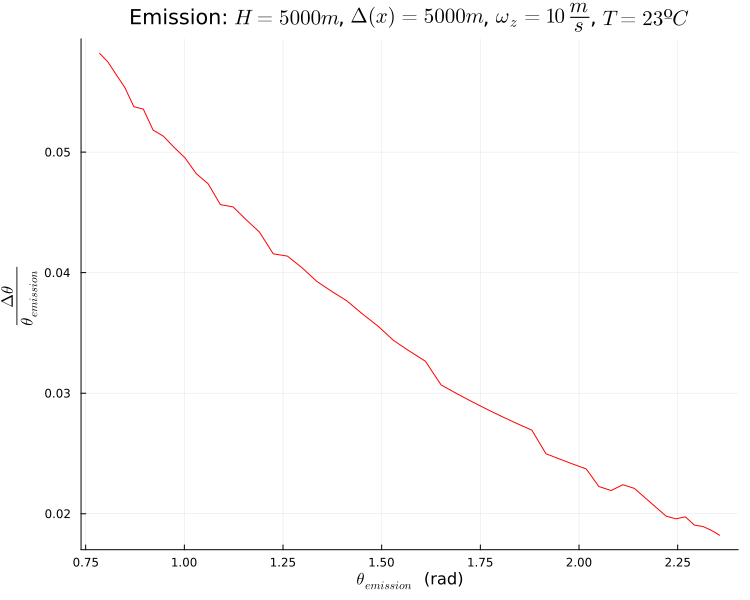

In [67]:
using Plots

x = deg2rad.(angulo_recta_5000_5000_10)
y1 = (angulo_real_5000_5000_10 - angulo_recta_5000_5000_10)./angulo_recta_5000_5000_10
y2=deepcopy(errores_relativos_5000_5000_10)
using Plots

p = plot(x, y1, 
         xlabel=raw"$\theta_{emission}$  (rad)", 
         ylabel=raw"$\frac{\Delta \theta}{\theta_{emission}}$ ",
         title=raw"Emission: $H=5000m$, $\Delta (x)=5000m$, $\omega_{z}=10 \frac{m}{s}$, $T=23ºC$",size=(750,600),color=:red,
         legend=false)

# Guardar la gráfica en un archivo
savefig(p, "C:\\Users\\Miguel\\Desktop\\TFM\\Ángulos_Probables_Theta\\w10.png")

q = plot(x, y2, 
         xlabel=raw"$\theta_{emission}$  ", 
         ylabel=raw"Relative Error (%)",
         title=raw"Emission: $H=5000m$, $\Delta (x)=5000m$, $\omega_{z}=10 \frac{m}{s}$, $T=23ºC$",color=:green,
         legend=false)

# Guardar la gráfica en un archivo
savefig(q, "C:\\Users\\Miguel\\Desktop\\TFM\\Ángulos_Probables_Theta\\erroresw10.png")
p

In [70]:
using LinearAlgebra
using DifferentialEquations


E_rel=  0.01
T = 23.
v_wind =[0.,0.,20.]
Source = [0.,0.,5000.]
function phi(Point1::Array{Float64, 1}, Point2::Array{Float64, 1}, v_wind::Array{Float64, 1}, tau) 
        #tgphi= (Point2[2]-Point1[2]- v_wind[2]*tau)/(Point2[1]-Point1[1]- v_wind[1]*tau) #Cálculo phi primera iteración
        #phi=rad2deg(atan(tgphi))
        phi=rad2deg(atan((Point2[2]-Point1[2]- v_wind[2]*tau),(Point2[1]-Point1[1]- v_wind[1]*tau)))
        return phi
end
function Slowness_Spherical(Point1::Array{Float64, 1}, Point2::Array{Float64, 1}, v_wind::Array{Float64, 1}, phi, c_source)
    x1,y1,z1=Point2-Point1 #Obtención parámetros primera iteración
    r=norm(Point2-Point1)
    theta=rad2deg(acos(z1/r))
    q0=1/(c_source + (v_wind[1]*cosd(phi)+ v_wind[2]*sind(phi))*cosd(theta) )
    qx=q0*cosd(phi)*sind(theta)
    qy=q0*sind(phi)*sind(theta)
    qz=q0*cosd(theta)
    return q0,qx,qy,qz,theta
end
function c_z(T,z) 
    if z>0
        c_air=331*sqrt((T+273.15-z/200)/273.15) #Modelo termodinámico v_sonido.Introduzco T_Z0 en grados centígrados por comodidad
    else
        c_air=331*sqrt((T+273.15)/273.15)
    end
    return c_air
end
function g!(dg, g, p, t)
    qx,qy = p
    q_aux = sqrt(qx^2 + qy^2 + g[4]^2)
    c=c_z(T,g[3])
    dg[1] = c*qx/q_aux + v_wind[1] #Variación coordenada X
    dg[2] = c*qy/q_aux + v_wind[2]  #Variación coordenada Y
    dg[3] = c*g[4]/q_aux + v_wind[3] #Variación coordenada Z
    dg[4]=+q_aux*(331^2/(400*273.15))/c #Variación qz
end
#### Necesitamos una velocidad inicial, correspondiente a la fuente, y un ángulo azimutal para empezar a iterar.
c_source=c_z(T, Source[3])
####
angulo_recta_5000_5000_20=[]
angulo_real_5000_5000_20= []
errores_relativos_5000_5000_20=[]
@time begin
for n in 0:50
    Receiver = [5000.,0.,200*n]
    R=norm(Receiver-Source)
    t_min=R/c_z(T,min(Source[3],Receiver[3]))
    t_max=R/c_z(T, max(Source[3],Receiver[3]))
    phi1=phi(Source,Receiver,v_wind, t_max) #Acotación teórica phi
    phi2=phi(Source,Receiver,v_wind, t_min) #Acotación teórica phi
    phi_i=(phi1+phi2)/2 #La media de la cota de phi como phi para la primera iteración
    #######
    q0,q_x,q_y,q_z,theta_i=Slowness_Spherical(Source,Receiver,v_wind, phi_i, c_source) #Obtención parámetros
    push!(angulo_recta_5000_5000_20,theta_i)
    #######
    traveltime=[]
    detener = 0 # Variable de control
    for l in 1:10
        if detener==1
            break
        end     
        thetas= range(theta_i-25/(2^(l-1)), theta_i+25/(2^(l-1)), 50);
        if v_wind==[0.,0.,0.]
                phis=[deepcopy(phi_i)]
        else
            if l==1
                phis=(min(phi1,phi2):0.05:max(phi1,phi2))
            else
                phi_distance=max(phi1,phi2)-min(phi1,phi2)
                phis= range(phi_i-phi_distance/(2^(l)), theta_i-phi_distance/(2^(l)), 20);
            end
        end
        angulos_theta = []
        angulos_phi = []
        tiempos = []
        for i in 1:length(thetas)
            for j in 1:length(phis)
                if l>1
                    q0=1/(c_source + (v_wind[1]*cosd(phi_i)+ v_wind[2]*sind(phi_i))*cosd(theta_i) )
                end
                q_x=q0*cosd(phis[j])*sind(thetas[i])
                q_y=q0*sind(phis[j])*sind(thetas[i])
                q_z=q0*cosd(thetas[i])
                p = [q_x, q_y]
                u0 = [Source[1],Source[2],Source[3], q_z]
                tspan=[0,t_max]
                prob = ODEProblem(g!, u0, tspan, p)
                paso=1e-2*R/2000
                sol = solve(prob, RK4(), dt=paso, saveat=0:paso:t_max)
                for k in 1:length(sol.u)
                    if detener==0
                        if sqrt((sol.u[k][1] - Receiver[1])^2 +(sol.u[k][2] - Receiver[2])^2 + (sol.u[k][3] - Receiver[3])^2 ) < R/(20*2^(l-1))
                            push!(angulos_theta, thetas[i])
                            push!(angulos_phi, phis[j])
                            push!(tiempos, sol.t[k])
                            break
                        elseif sqrt((sol.u[k][1] - Receiver[1])^2 +(sol.u[k][2] - Receiver[2])^2 + (sol.u[k][3] - Receiver[3])^2 ) < R*E_rel/100
                            traveltime = sol.t[k] #Error relativo menor a 0.01% ya detenemos el barrido
                            theta_i = thetas[i]
                            phi_i = phis[j]
                            detener = 1 # Cambiamos el valor de la variable de control
                            println("Se alcanzó el error relativo objetivo.")
                            break
                        end
                    else
                        break
                    end
                end
            end
        end
        if length(tiempos)==0
            if l==1
                println("No se encontró ninguna trayectoria entre fuente y receptor. Valora si estás en una zona de sombra o ajusta el paso de tiempo ")
            end
            break
        elseif detener==0
            traveltime = findmin(tiempos)
            indice = argmin(tiempos)
            theta_i=angulos_theta[indice]
            phi_i=angulos_phi[indice]
        end
    end
    push!(angulo_real_5000_5000_20,theta_i)
    q_x=q0*cosd(phi_i)*sind(theta_i)
    q_y=q0*sind(phi_i)*sind(theta_i)
    q_z=q0*cosd(theta_i)
    # Definir los parámetros
    p = [q_x, q_y]
    u0 = [Source[1],Source[2], Source[3], q_z]
    tspan=[0,traveltime[1]]
    # Crear el problema ODE
    prob = ODEProblem(g!, u0, tspan, p)
    # Resolver el problema ODE
    paso=1e-2*R/2000
    sol = solve(prob, RK4(), dt=paso, saveat=0:paso:traveltime[1])
    error_relativo_n=(sqrt((sol.u[end][1] - Receiver[1])^2 +(sol.u[end][2] - Receiver[2])^2 + (sol.u[end][3] - Receiver[3])^2 )/R)*100
    push!(errores_relativos_5000_5000_20,error_relativo_n)
end
end

Se alcanzó el error relativo objetivo.
420.558973 seconds (6.45 G allocations: 354.596 GiB, 15.24% gc time, 0.02% compilation time: 70% of which was recompilation)


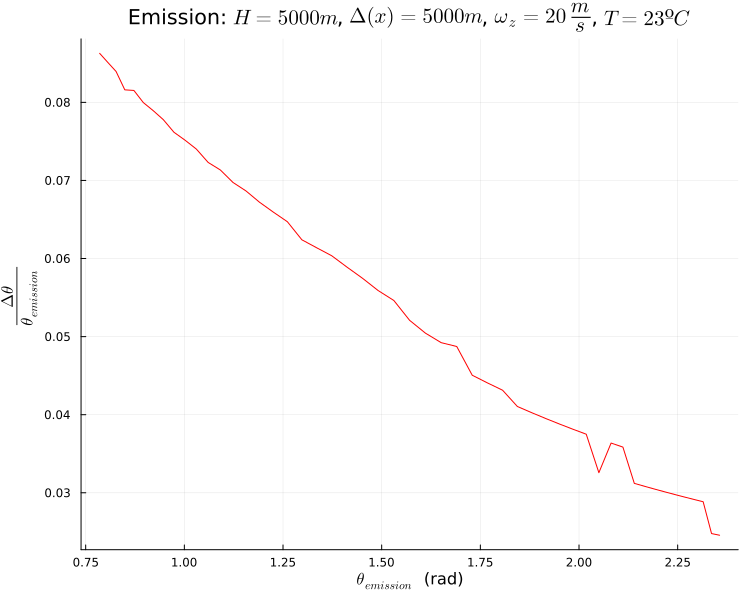

In [71]:
using Plots

x = deg2rad.(angulo_recta_5000_5000_20)
y1 = (angulo_real_5000_5000_20 - angulo_recta_5000_5000_20)./angulo_recta_5000_5000_20
y2=deepcopy(errores_relativos_5000_5000_20)
using Plots

p = plot(x, y1, 
         xlabel=raw"$\theta_{emission}$  (rad)", 
         ylabel=raw"$\frac{\Delta \theta}{\theta_{emission}}$ ",
         title=raw"Emission: $H=5000m$, $\Delta (x)=5000m$, $\omega_{z}=20 \frac{m}{s}$, $T=23ºC$",size=(750,600),color=:red,
         legend=false)

# Guardar la gráfica en un archivo
savefig(p, "C:\\Users\\Miguel\\Desktop\\TFM\\Ángulos_Probables_Theta\\w20.png")

q = plot(x, y2, 
         xlabel=raw"$\theta_{emission}$  ", 
         ylabel=raw"Relative Error (%)",
         title=raw"Emission: $H=5000m$, $\Delta (x)=5000m$, $\omega_{z}=20 \frac{m}{s}$, $T=23ºC$",color=:green,
         legend=false)

# Guardar la gráfica en un archivo
savefig(q, "C:\\Users\\Miguel\\Desktop\\TFM\\Ángulos_Probables_Theta\\erroresw20.png")
p

In [72]:
using LinearAlgebra
using DifferentialEquations


E_rel=  0.01
T = 23.
v_wind =[0.,0.,-20.]
Source = [0.,0.,5000.]
function phi(Point1::Array{Float64, 1}, Point2::Array{Float64, 1}, v_wind::Array{Float64, 1}, tau) 
        #tgphi= (Point2[2]-Point1[2]- v_wind[2]*tau)/(Point2[1]-Point1[1]- v_wind[1]*tau) #Cálculo phi primera iteración
        #phi=rad2deg(atan(tgphi))
        phi=rad2deg(atan((Point2[2]-Point1[2]- v_wind[2]*tau),(Point2[1]-Point1[1]- v_wind[1]*tau)))
        return phi
end
function Slowness_Spherical(Point1::Array{Float64, 1}, Point2::Array{Float64, 1}, v_wind::Array{Float64, 1}, phi, c_source)
    x1,y1,z1=Point2-Point1 #Obtención parámetros primera iteración
    r=norm(Point2-Point1)
    theta=rad2deg(acos(z1/r))
    q0=1/(c_source + (v_wind[1]*cosd(phi)+ v_wind[2]*sind(phi))*cosd(theta) )
    qx=q0*cosd(phi)*sind(theta)
    qy=q0*sind(phi)*sind(theta)
    qz=q0*cosd(theta)
    return q0,qx,qy,qz,theta
end
function c_z(T,z) 
    if z>0
        c_air=331*sqrt((T+273.15-z/200)/273.15) #Modelo termodinámico v_sonido.Introduzco T_Z0 en grados centígrados por comodidad
    else
        c_air=331*sqrt((T+273.15)/273.15)
    end
    return c_air
end
function g!(dg, g, p, t)
    qx,qy = p
    q_aux = sqrt(qx^2 + qy^2 + g[4]^2)
    c=c_z(T,g[3])
    dg[1] = c*qx/q_aux + v_wind[1] #Variación coordenada X
    dg[2] = c*qy/q_aux + v_wind[2]  #Variación coordenada Y
    dg[3] = c*g[4]/q_aux + v_wind[3] #Variación coordenada Z
    dg[4]=+q_aux*(331^2/(400*273.15))/c #Variación qz
end
#### Necesitamos una velocidad inicial, correspondiente a la fuente, y un ángulo azimutal para empezar a iterar.
c_source=c_z(T, Source[3])
####
angulo_recta_5000_5000_l20=[]
angulo_real_5000_5000_l20= []
errores_relativos_5000_5000_l20=[]
@time begin
for n in 0:50
    Receiver = [5000.,0.,200*n]
    R=norm(Receiver-Source)
    t_min=R/c_z(T,min(Source[3],Receiver[3]))
    t_max=R/c_z(T, max(Source[3],Receiver[3]))
    phi1=phi(Source,Receiver,v_wind, t_max) #Acotación teórica phi
    phi2=phi(Source,Receiver,v_wind, t_min) #Acotación teórica phi
    phi_i=(phi1+phi2)/2 #La media de la cota de phi como phi para la primera iteración
    #######
    q0,q_x,q_y,q_z,theta_i=Slowness_Spherical(Source,Receiver,v_wind, phi_i, c_source) #Obtención parámetros
    push!(angulo_recta_5000_5000_l20,theta_i)
    #######
    traveltime=[]
    detener = 0 # Variable de control
    for l in 1:10
        if detener==1
            break
        end     
        thetas= range(theta_i-25/(2^(l-1)), theta_i+25/(2^(l-1)), 50);
        if v_wind==[0.,0.,0.]
                phis=[deepcopy(phi_i)]
        else
            if l==1
                phis=(min(phi1,phi2):0.05:max(phi1,phi2))
            else
                phi_distance=max(phi1,phi2)-min(phi1,phi2)
                phis= range(phi_i-phi_distance/(2^(l)), theta_i-phi_distance/(2^(l)), 20);
            end
        end
        angulos_theta = []
        angulos_phi = []
        tiempos = []
        for i in 1:length(thetas)
            for j in 1:length(phis)
                if l>1
                    q0=1/(c_source + (v_wind[1]*cosd(phi_i)+ v_wind[2]*sind(phi_i))*cosd(theta_i) )
                end
                q_x=q0*cosd(phis[j])*sind(thetas[i])
                q_y=q0*sind(phis[j])*sind(thetas[i])
                q_z=q0*cosd(thetas[i])
                p = [q_x, q_y]
                u0 = [Source[1],Source[2],Source[3], q_z]
                tspan=[0,t_max]
                prob = ODEProblem(g!, u0, tspan, p)
                paso=1e-2*R/2000
                sol = solve(prob, RK4(), dt=paso, saveat=0:paso:t_max)
                for k in 1:length(sol.u)
                    if detener==0
                        if sqrt((sol.u[k][1] - Receiver[1])^2 +(sol.u[k][2] - Receiver[2])^2 + (sol.u[k][3] - Receiver[3])^2 ) < R/(20*2^(l-1))
                            push!(angulos_theta, thetas[i])
                            push!(angulos_phi, phis[j])
                            push!(tiempos, sol.t[k])
                            break
                        elseif sqrt((sol.u[k][1] - Receiver[1])^2 +(sol.u[k][2] - Receiver[2])^2 + (sol.u[k][3] - Receiver[3])^2 ) < R*E_rel/100
                            traveltime = sol.t[k] #Error relativo menor a 0.01% ya detenemos el barrido
                            theta_i = thetas[i]
                            phi_i = phis[j]
                            detener = 1 # Cambiamos el valor de la variable de control
                            println("Se alcanzó el error relativo objetivo.")
                            break
                        end
                    else
                        break
                    end
                end
            end
        end
        if length(tiempos)==0
            if l==1
                println("No se encontró ninguna trayectoria entre fuente y receptor. Valora si estás en una zona de sombra o ajusta el paso de tiempo ")
            end
            break
        elseif detener==0
            traveltime = findmin(tiempos)
            indice = argmin(tiempos)
            theta_i=angulos_theta[indice]
            phi_i=angulos_phi[indice]
        end
    end
    push!(angulo_real_5000_5000_l20,theta_i)
    q_x=q0*cosd(phi_i)*sind(theta_i)
    q_y=q0*sind(phi_i)*sind(theta_i)
    q_z=q0*cosd(theta_i)
    # Definir los parámetros
    p = [q_x, q_y]
    u0 = [Source[1],Source[2], Source[3], q_z]
    tspan=[0,traveltime[1]]
    # Crear el problema ODE
    prob = ODEProblem(g!, u0, tspan, p)
    # Resolver el problema ODE
    paso=1e-2*R/2000
    sol = solve(prob, RK4(), dt=paso, saveat=0:paso:traveltime[1])
    error_relativo_n=(sqrt((sol.u[end][1] - Receiver[1])^2 +(sol.u[end][2] - Receiver[2])^2 + (sol.u[end][3] - Receiver[3])^2 )/R)*100
    push!(errores_relativos_5000_5000_l20,error_relativo_n)
end
end

428.936119 seconds (6.22 G allocations: 342.404 GiB, 15.09% gc time, 0.01% compilation time: 67% of which was recompilation)


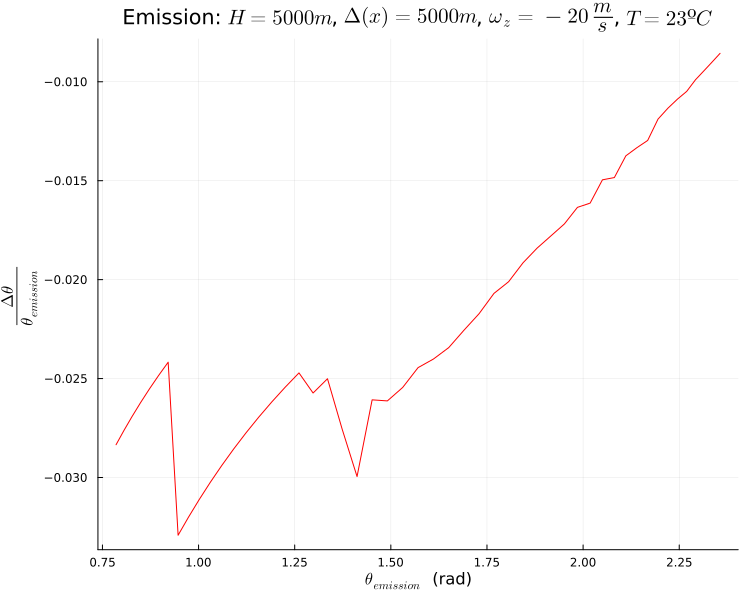

In [73]:
using Plots

x = deg2rad.(angulo_recta_5000_5000_l20)
y1 = (angulo_real_5000_5000_l20 - angulo_recta_5000_5000_l20)./angulo_recta_5000_5000_l20
y2=deepcopy(errores_relativos_5000_5000_l20)
using Plots

p = plot(x, y1, 
         xlabel=raw"$\theta_{emission}$  (rad)", 
         ylabel=raw"$\frac{\Delta \theta}{\theta_{emission}}$ ",
         title=raw"Emission: $H=5000m$, $\Delta (x)=5000m$, $\omega_{z}=-20 \frac{m}{s}$, $T=23ºC$",size=(750,600),color=:red,
         legend=false)

# Guardar la gráfica en un archivo
savefig(p, "C:\\Users\\Miguel\\Desktop\\TFM\\Ángulos_Probables_Theta\\wl20.png")

q = plot(x, y2, 
         xlabel=raw"$\theta_{emission}$  ", 
         ylabel=raw"Relative Error (%)",
         title=raw"Emission: $H=5000m$, $\Delta (x)=5000m$, $\omega_{z}=-20 \frac{m}{s}$, $T=23ºC$",color=:green,
         legend=false)

# Guardar la gráfica en un archivo
savefig(q, "C:\\Users\\Miguel\\Desktop\\TFM\\Ángulos_Probables_Theta\\erroreswl20.png")
p

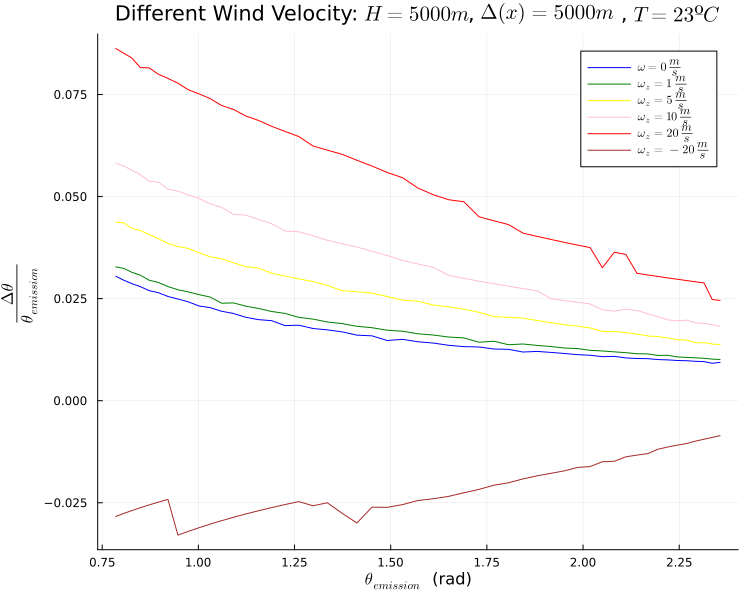

In [75]:
y8=(angulo_real_5000_5000 - angulo_recta_5000_5000)./angulo_recta_5000_5000
p = plot(deg2rad.(angulo_recta_5000_5000), y8, 
         xlabel=raw"$\theta_{emission}$  (rad)", 
         ylabel=raw"$\frac{\Delta \theta}{\theta_{emission}}$ ",
         title=raw"Different Wind Velocity: $H=5000m$, $\Delta (x)=5000m$ , $T=23ºC$",size=(750,600),color=:blue,
         label=raw"$\omega=0 \frac{m}{s}$")
y9=(angulo_real_5000_5000_1 - angulo_recta_5000_5000_1)./angulo_recta_5000_5000_1
plot!(deg2rad.(angulo_recta_5000_5000_1), y9, color=:green,
         label=raw"$\omega_{z}=1 \frac{m}{s}$")
y10=(angulo_real_5000_5000_5 - angulo_recta_5000_5000_5)./angulo_recta_5000_5000_5
plot!(deg2rad.(angulo_recta_5000_5000_5), y10, color=:yellow,
         label=raw"$\omega_{z}=5 \frac{m}{s}$")
y11=(angulo_real_5000_5000_10 - angulo_recta_5000_5000_10)./angulo_recta_5000_5000_10
plot!(deg2rad.(angulo_recta_5000_5000_10), y11, color=:pink,
         label=raw"$\omega_{z}=10 \frac{m}{s}$")
y12=(angulo_real_5000_5000_20 - angulo_recta_5000_5000_20)./angulo_recta_5000_5000_20
plot!(deg2rad.(angulo_recta_5000_5000_20), y12, color=:red,
         label=raw"$\omega_{z}=20 \frac{m}{s}$")
y13=(angulo_real_5000_5000_l20 - angulo_recta_5000_5000_l20)./angulo_recta_5000_5000_l20
plot!(deg2rad.(angulo_recta_5000_5000_l20), y13, color=:brown,
         label=raw"$\omega_{z}=-20 \frac{m}{s}$")
# Guardar la gráfica en un archivo
savefig(p, "C:\\Users\\Miguel\\Desktop\\TFM\\Ángulos_Probables_Theta\\ComparativaVientos.png")
p

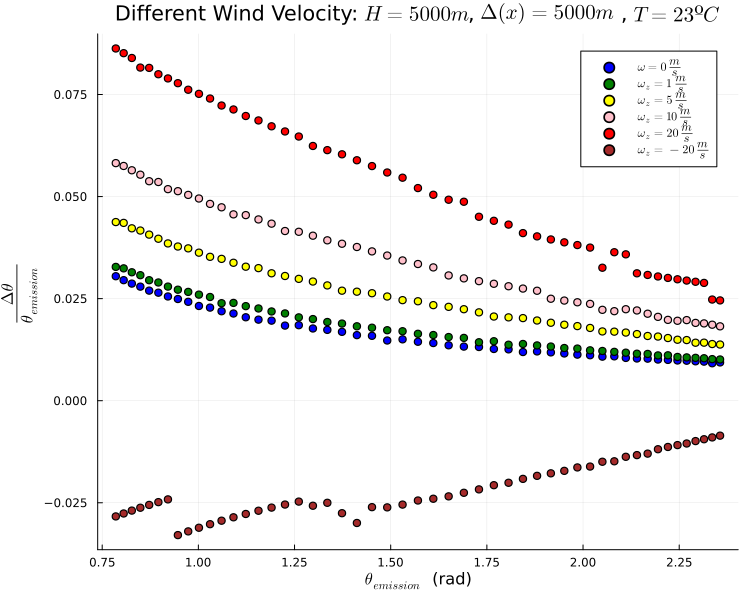

In [76]:
y8=(angulo_real_5000_5000 - angulo_recta_5000_5000)./angulo_recta_5000_5000
p = scatter(deg2rad.(angulo_recta_5000_5000), y8, 
         xlabel=raw"$\theta_{emission}$  (rad)", 
         ylabel=raw"$\frac{\Delta \theta}{\theta_{emission}}$ ",
         title=raw"Different Wind Velocity: $H=5000m$, $\Delta (x)=5000m$ , $T=23ºC$",size=(750,600),color=:blue,
         label=raw"$\omega=0 \frac{m}{s}$")
y9=(angulo_real_5000_5000_1 - angulo_recta_5000_5000_1)./angulo_recta_5000_5000_1
scatter!(deg2rad.(angulo_recta_5000_5000_1), y9, color=:green,
         label=raw"$\omega_{z}=1 \frac{m}{s}$")
y10=(angulo_real_5000_5000_5 - angulo_recta_5000_5000_5)./angulo_recta_5000_5000_5
scatter!(deg2rad.(angulo_recta_5000_5000_5), y10, color=:yellow,
         label=raw"$\omega_{z}=5 \frac{m}{s}$")
y11=(angulo_real_5000_5000_10 - angulo_recta_5000_5000_10)./angulo_recta_5000_5000_10
scatter!(deg2rad.(angulo_recta_5000_5000_10), y11, color=:pink,
         label=raw"$\omega_{z}=10 \frac{m}{s}$")
y12=(angulo_real_5000_5000_20 - angulo_recta_5000_5000_20)./angulo_recta_5000_5000_20
scatter!(deg2rad.(angulo_recta_5000_5000_20), y12, color=:red,
         label=raw"$\omega_{z}=20 \frac{m}{s}$")
y13=(angulo_real_5000_5000_l20 - angulo_recta_5000_5000_l20)./angulo_recta_5000_5000_l20
scatter!(deg2rad.(angulo_recta_5000_5000_l20), y13, color=:brown,
         label=raw"$\omega_{z}=-20 \frac{m}{s}$")
# Guardar la gráfica en un archivo
savefig(p, "C:\\Users\\Miguel\\Desktop\\TFM\\Ángulos_Probables_Theta\\ComparativaVientos(scatter).png")
p


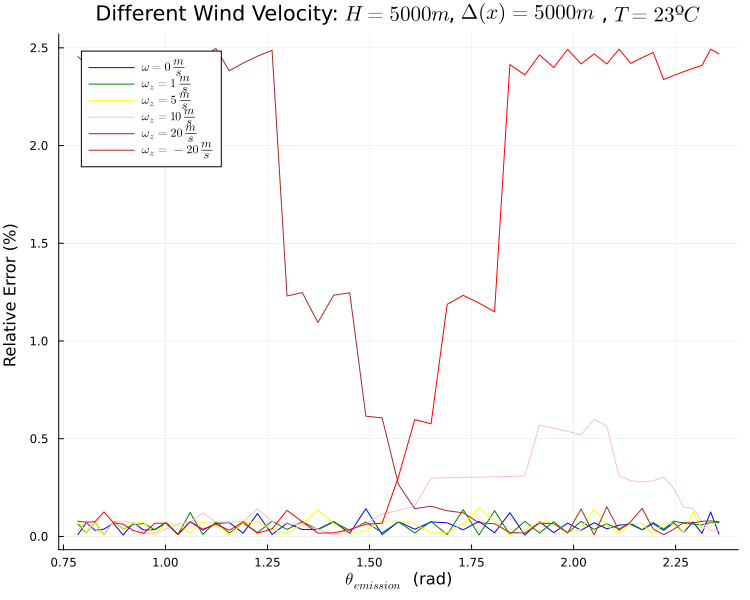

In [103]:
p = plot(deg2rad.(angulo_recta_5000_5000), errores_relativos_5000_5000, 
         xlabel=raw"$\theta_{emission}$  (rad)", 
         ylabel=raw"Relative Error (%) ",
         title=raw"Different Wind Velocity: $H=5000m$, $\Delta (x)=5000m$ , $T=23ºC$",size=(750,600),color=:blue,
         label=raw"$\omega=0 \frac{m}{s}$")

plot!(deg2rad.(angulo_recta_5000_5000_1), errores_relativos_5000_5000_1, color=:green,
         label=raw"$\omega_{z}=1 \frac{m}{s}$")

plot!(deg2rad.(angulo_recta_5000_5000_5), errores_relativos_5000_5000_5, color=:yellow,
         label=raw"$\omega_{z}=5 \frac{m}{s}$")

plot!(deg2rad.(angulo_recta_5000_5000_10), errores_relativos_5000_5000_10, color=:pink,
         label=raw"$\omega_{z}=10 \frac{m}{s}$")

plot!(deg2rad.(angulo_recta_5000_5000_20), errores_relativos_5000_5000_20, color=:red,
         label=raw"$\omega_{z}=20 \frac{m}{s}$")

plot!(deg2rad.(angulo_recta_5000_5000_l20), errores_relativos_5000_5000_l20, color=:brown,
         label=raw"$\omega_{z}=-20 \frac{m}{s}$")
# Guardar la gráfica en un archivo
savefig(p, "C:\\Users\\Miguel\\Desktop\\TFM\\Ángulos_Probables_Theta\\Errores_ComparativaVientos.png")
p

# Otras direcciones viento

In [77]:
using LinearAlgebra
using DifferentialEquations


E_rel=  0.01
T = 23.
v_wind =[10.,0.,0.]
Source = [0.,0.,5000.]
function phi(Point1::Array{Float64, 1}, Point2::Array{Float64, 1}, v_wind::Array{Float64, 1}, tau) 
        #tgphi= (Point2[2]-Point1[2]- v_wind[2]*tau)/(Point2[1]-Point1[1]- v_wind[1]*tau) #Cálculo phi primera iteración
        #phi=rad2deg(atan(tgphi))
        phi=rad2deg(atan((Point2[2]-Point1[2]- v_wind[2]*tau),(Point2[1]-Point1[1]- v_wind[1]*tau)))
        return phi
end
function Slowness_Spherical(Point1::Array{Float64, 1}, Point2::Array{Float64, 1}, v_wind::Array{Float64, 1}, phi, c_source)
    x1,y1,z1=Point2-Point1 #Obtención parámetros primera iteración
    r=norm(Point2-Point1)
    theta=rad2deg(acos(z1/r))
    q0=1/(c_source + (v_wind[1]*cosd(phi)+ v_wind[2]*sind(phi))*cosd(theta) )
    qx=q0*cosd(phi)*sind(theta)
    qy=q0*sind(phi)*sind(theta)
    qz=q0*cosd(theta)
    return q0,qx,qy,qz,theta
end
function c_z(T,z) 
    if z>0
        c_air=331*sqrt((T+273.15-z/200)/273.15) #Modelo termodinámico v_sonido.Introduzco T_Z0 en grados centígrados por comodidad
    else
        c_air=331*sqrt((T+273.15)/273.15)
    end
    return c_air
end
function g!(dg, g, p, t)
    qx,qy = p
    q_aux = sqrt(qx^2 + qy^2 + g[4]^2)
    c=c_z(T,g[3])
    dg[1] = c*qx/q_aux + v_wind[1] #Variación coordenada X
    dg[2] = c*qy/q_aux + v_wind[2]  #Variación coordenada Y
    dg[3] = c*g[4]/q_aux + v_wind[3] #Variación coordenada Z
    dg[4]=+q_aux*(331^2/(400*273.15))/c #Variación qz
end
#### Necesitamos una velocidad inicial, correspondiente a la fuente, y un ángulo azimutal para empezar a iterar.
c_source=c_z(T, Source[3])
####
angulo_recta_5000_5000_X10=[]
angulo_real_5000_5000_X10= []
errores_relativos_5000_5000_X10=[]
@time begin
for n in 0:50
    Receiver = [5000.,0.,200*n]
    R=norm(Receiver-Source)
    t_min=R/c_z(T,min(Source[3],Receiver[3]))
    t_max=R/c_z(T, max(Source[3],Receiver[3]))
    phi1=phi(Source,Receiver,v_wind, t_max) #Acotación teórica phi
    phi2=phi(Source,Receiver,v_wind, t_min) #Acotación teórica phi
    phi_i=(phi1+phi2)/2 #La media de la cota de phi como phi para la primera iteración
    #######
    q0,q_x,q_y,q_z,theta_i=Slowness_Spherical(Source,Receiver,v_wind, phi_i, c_source) #Obtención parámetros
    push!(angulo_recta_5000_5000_X10,theta_i)
    #######
    traveltime=[]
    detener = 0 # Variable de control
    for l in 1:10
        if detener==1
            break
        end     
        thetas= range(theta_i-25/(2^(l-1)), theta_i+25/(2^(l-1)), 50);
        if v_wind==[0.,0.,0.]
                phis=[deepcopy(phi_i)]
        else
            if l==1
                phis=(min(phi1,phi2):0.05:max(phi1,phi2))
            else
                phi_distance=max(phi1,phi2)-min(phi1,phi2)
                phis= range(phi_i-phi_distance/(2^(l)), theta_i-phi_distance/(2^(l)), 20);
            end
        end
        angulos_theta = []
        angulos_phi = []
        tiempos = []
        for i in 1:length(thetas)
            for j in 1:length(phis)
                if l>1
                    q0=1/(c_source + (v_wind[1]*cosd(phi_i)+ v_wind[2]*sind(phi_i))*cosd(theta_i) )
                end
                q_x=q0*cosd(phis[j])*sind(thetas[i])
                q_y=q0*sind(phis[j])*sind(thetas[i])
                q_z=q0*cosd(thetas[i])
                p = [q_x, q_y]
                u0 = [Source[1],Source[2],Source[3], q_z]
                tspan=[0,t_max]
                prob = ODEProblem(g!, u0, tspan, p)
                paso=1e-2*R/2000
                sol = solve(prob, RK4(), dt=paso, saveat=0:paso:t_max)
                for k in 1:length(sol.u)
                    if detener==0
                        if sqrt((sol.u[k][1] - Receiver[1])^2 +(sol.u[k][2] - Receiver[2])^2 + (sol.u[k][3] - Receiver[3])^2 ) < R/(20*2^(l-1))
                            push!(angulos_theta, thetas[i])
                            push!(angulos_phi, phis[j])
                            push!(tiempos, sol.t[k])
                            break
                        elseif sqrt((sol.u[k][1] - Receiver[1])^2 +(sol.u[k][2] - Receiver[2])^2 + (sol.u[k][3] - Receiver[3])^2 ) < R*E_rel/100
                            traveltime = sol.t[k] #Error relativo menor a 0.01% ya detenemos el barrido
                            theta_i = thetas[i]
                            phi_i = phis[j]
                            detener = 1 # Cambiamos el valor de la variable de control
                            println("Se alcanzó el error relativo objetivo.")
                            break
                        end
                    else
                        break
                    end
                end
            end
        end
        if length(tiempos)==0
            if l==1
                println("No se encontró ninguna trayectoria entre fuente y receptor. Valora si estás en una zona de sombra o ajusta el paso de tiempo ")
            end
            break
        elseif detener==0
            traveltime = findmin(tiempos)
            indice = argmin(tiempos)
            theta_i=angulos_theta[indice]
            phi_i=angulos_phi[indice]
        end
    end
    push!(angulo_real_5000_5000_X10,theta_i)
    q_x=q0*cosd(phi_i)*sind(theta_i)
    q_y=q0*sind(phi_i)*sind(theta_i)
    q_z=q0*cosd(theta_i)
    # Definir los parámetros
    p = [q_x, q_y]
    u0 = [Source[1],Source[2], Source[3], q_z]
    tspan=[0,traveltime[1]]
    # Crear el problema ODE
    prob = ODEProblem(g!, u0, tspan, p)
    # Resolver el problema ODE
    paso=1e-2*R/2000
    sol = solve(prob, RK4(), dt=paso, saveat=0:paso:traveltime[1])
    error_relativo_n=(sqrt((sol.u[end][1] - Receiver[1])^2 +(sol.u[end][2] - Receiver[2])^2 + (sol.u[end][3] - Receiver[3])^2 )/R)*100
    push!(errores_relativos_5000_5000_X10,error_relativo_n)
end
end

Se alcanzó el error relativo objetivo.
Se alcanzó el error relativo objetivo.
Se alcanzó el error relativo objetivo.
750.102366 seconds (9.99 G allocations: 548.324 GiB, 14.35% gc time, 0.02% compilation time: 67% of which was recompilation)


In [102]:
using LinearAlgebra
using DifferentialEquations


E_rel=  0.01
T = 23.
v_wind =[-10.,0.,0.]
Source = [0.,0.,5000.]
function phi(Point1::Array{Float64, 1}, Point2::Array{Float64, 1}, v_wind::Array{Float64, 1}, tau) 
        #tgphi= (Point2[2]-Point1[2]- v_wind[2]*tau)/(Point2[1]-Point1[1]- v_wind[1]*tau) #Cálculo phi primera iteración
        #phi=rad2deg(atan(tgphi))
        phi=rad2deg(atan((Point2[2]-Point1[2]- v_wind[2]*tau),(Point2[1]-Point1[1]- v_wind[1]*tau)))
        return phi
end
function Slowness_Spherical(Point1::Array{Float64, 1}, Point2::Array{Float64, 1}, v_wind::Array{Float64, 1}, phi, c_source)
    x1,y1,z1=Point2-Point1 #Obtención parámetros primera iteración
    r=norm(Point2-Point1)
    theta=rad2deg(acos(z1/r))
    q0=1/(c_source + (v_wind[1]*cosd(phi)+ v_wind[2]*sind(phi))*cosd(theta) )
    qx=q0*cosd(phi)*sind(theta)
    qy=q0*sind(phi)*sind(theta)
    qz=q0*cosd(theta)
    return q0,qx,qy,qz,theta
end
function c_z(T,z) 
    if z>0
        c_air=331*sqrt((T+273.15-z/200)/273.15) #Modelo termodinámico v_sonido.Introduzco T_Z0 en grados centígrados por comodidad
    else
        c_air=331*sqrt((T+273.15)/273.15)
    end
    return c_air
end
function g!(dg, g, p, t)
    qx,qy = p
    q_aux = sqrt(qx^2 + qy^2 + g[4]^2)
    c=c_z(T,g[3])
    dg[1] = c*qx/q_aux + v_wind[1] #Variación coordenada X
    dg[2] = c*qy/q_aux + v_wind[2]  #Variación coordenada Y
    dg[3] = c*g[4]/q_aux + v_wind[3] #Variación coordenada Z
    dg[4]=+q_aux*(331^2/(400*273.15))/c #Variación qz
end
#### Necesitamos una velocidad inicial, correspondiente a la fuente, y un ángulo azimutal para empezar a iterar.
c_source=c_z(T, Source[3])
####
angulo_recta_5000_5000_Xl10=[]
angulo_real_5000_5000_Xl10= []
errores_relativos_5000_5000_Xl10=[]
@time begin
for n in 0:50
    Receiver = [5000.,0.,200*n]
    R=norm(Receiver-Source)
    t_min=R/c_z(T,min(Source[3],Receiver[3]))
    t_max=R/c_z(T, max(Source[3],Receiver[3]))
    phi1=phi(Source,Receiver,v_wind, t_max) #Acotación teórica phi
    phi2=phi(Source,Receiver,v_wind, t_min) #Acotación teórica phi
    phi_i=(phi1+phi2)/2 #La media de la cota de phi como phi para la primera iteración
    #######
    q0,q_x,q_y,q_z,theta_i=Slowness_Spherical(Source,Receiver,v_wind, phi_i, c_source) #Obtención parámetros
    push!(angulo_recta_5000_5000_Xl10,theta_i)
    #######
    traveltime=[]
    detener = 0 # Variable de control
    for l in 1:10
        if detener==1
            break
        end     
        thetas= range(theta_i-25/(2^(l-1)), theta_i+25/(2^(l-1)), 50);
        if v_wind==[0.,0.,0.]
                phis=[deepcopy(phi_i)]
        else
            if l==1
                phis=(min(phi1,phi2):0.05:max(phi1,phi2))
            else
                phi_distance=max(phi1,phi2)-min(phi1,phi2)
                phis= range(phi_i-phi_distance/(2^(l)), theta_i-phi_distance/(2^(l)), 20);
            end
        end
        angulos_theta = []
        angulos_phi = []
        tiempos = []
        for i in 1:length(thetas)
            for j in 1:length(phis)
                if l>1
                    q0=1/(c_source + (v_wind[1]*cosd(phi_i)+ v_wind[2]*sind(phi_i))*cosd(theta_i) )
                end
                q_x=q0*cosd(phis[j])*sind(thetas[i])
                q_y=q0*sind(phis[j])*sind(thetas[i])
                q_z=q0*cosd(thetas[i])
                p = [q_x, q_y]
                u0 = [Source[1],Source[2],Source[3], q_z]
                tspan=[0,t_max]
                prob = ODEProblem(g!, u0, tspan, p)
                paso=1e-2*R/2000
                sol = solve(prob, RK4(), dt=paso, saveat=0:paso:t_max)
                for k in 1:length(sol.u)
                    if detener==0
                        if sqrt((sol.u[k][1] - Receiver[1])^2 +(sol.u[k][2] - Receiver[2])^2 + (sol.u[k][3] - Receiver[3])^2 ) < R/(20*2^(l-1))
                            push!(angulos_theta, thetas[i])
                            push!(angulos_phi, phis[j])
                            push!(tiempos, sol.t[k])
                            break
                        elseif sqrt((sol.u[k][1] - Receiver[1])^2 +(sol.u[k][2] - Receiver[2])^2 + (sol.u[k][3] - Receiver[3])^2 ) < R*E_rel/100
                            traveltime = sol.t[k] #Error relativo menor a 0.01% ya detenemos el barrido
                            theta_i = thetas[i]
                            phi_i = phis[j]
                            detener = 1 # Cambiamos el valor de la variable de control
                            println("Se alcanzó el error relativo objetivo.")
                            break
                        end
                    else
                        break
                    end
                end
            end
        end
        if length(tiempos)==0
            if l==1
                println("No se encontró ninguna trayectoria entre fuente y receptor. Valora si estás en una zona de sombra o ajusta el paso de tiempo ")
            end
            break
        elseif detener==0
            traveltime = findmin(tiempos)
            indice = argmin(tiempos)
            theta_i=angulos_theta[indice]
            phi_i=angulos_phi[indice]
        end
    end
    push!(angulo_real_5000_5000_Xl10,theta_i)
    q_x=q0*cosd(phi_i)*sind(theta_i)
    q_y=q0*sind(phi_i)*sind(theta_i)
    q_z=q0*cosd(theta_i)
    # Definir los parámetros
    p = [q_x, q_y]
    u0 = [Source[1],Source[2], Source[3], q_z]
    tspan=[0,traveltime[1]]
    # Crear el problema ODE
    prob = ODEProblem(g!, u0, tspan, p)
    # Resolver el problema ODE
    paso=1e-2*R/2000
    sol = solve(prob, RK4(), dt=paso, saveat=0:paso:traveltime[1])
    error_relativo_n=(sqrt((sol.u[end][1] - Receiver[1])^2 +(sol.u[end][2] - Receiver[2])^2 + (sol.u[end][3] - Receiver[3])^2 )/R)*100
    push!(errores_relativos_5000_5000_Xl10,error_relativo_n)
end
end

296.530396 seconds (3.54 G allocations: 195.033 GiB, 13.62% gc time, 0.05% compilation time: 68% of which was recompilation)


In [79]:
using LinearAlgebra
using DifferentialEquations


E_rel=  0.01
T = 23.
v_wind =[0.,10.,0.]
Source = [0.,0.,5000.]
function phi(Point1::Array{Float64, 1}, Point2::Array{Float64, 1}, v_wind::Array{Float64, 1}, tau) 
        #tgphi= (Point2[2]-Point1[2]- v_wind[2]*tau)/(Point2[1]-Point1[1]- v_wind[1]*tau) #Cálculo phi primera iteración
        #phi=rad2deg(atan(tgphi))
        phi=rad2deg(atan((Point2[2]-Point1[2]- v_wind[2]*tau),(Point2[1]-Point1[1]- v_wind[1]*tau)))
        return phi
end
function Slowness_Spherical(Point1::Array{Float64, 1}, Point2::Array{Float64, 1}, v_wind::Array{Float64, 1}, phi, c_source)
    x1,y1,z1=Point2-Point1 #Obtención parámetros primera iteración
    r=norm(Point2-Point1)
    theta=rad2deg(acos(z1/r))
    q0=1/(c_source + (v_wind[1]*cosd(phi)+ v_wind[2]*sind(phi))*cosd(theta) )
    qx=q0*cosd(phi)*sind(theta)
    qy=q0*sind(phi)*sind(theta)
    qz=q0*cosd(theta)
    return q0,qx,qy,qz,theta
end
function c_z(T,z) 
    if z>0
        c_air=331*sqrt((T+273.15-z/200)/273.15) #Modelo termodinámico v_sonido.Introduzco T_Z0 en grados centígrados por comodidad
    else
        c_air=331*sqrt((T+273.15)/273.15)
    end
    return c_air
end
function g!(dg, g, p, t)
    qx,qy = p
    q_aux = sqrt(qx^2 + qy^2 + g[4]^2)
    c=c_z(T,g[3])
    dg[1] = c*qx/q_aux + v_wind[1] #Variación coordenada X
    dg[2] = c*qy/q_aux + v_wind[2]  #Variación coordenada Y
    dg[3] = c*g[4]/q_aux + v_wind[3] #Variación coordenada Z
    dg[4]=+q_aux*(331^2/(400*273.15))/c #Variación qz
end
#### Necesitamos una velocidad inicial, correspondiente a la fuente, y un ángulo azimutal para empezar a iterar.
c_source=c_z(T, Source[3])
####
angulo_recta_5000_5000_Y10=[]
angulo_real_5000_5000_Y10= []
errores_relativos_5000_5000_Y10=[]
@time begin
for n in 0:50
    Receiver = [5000.,0.,200*n]
    R=norm(Receiver-Source)
    t_min=R/c_z(T,min(Source[3],Receiver[3]))
    t_max=R/c_z(T, max(Source[3],Receiver[3]))
    phi1=phi(Source,Receiver,v_wind, t_max) #Acotación teórica phi
    phi2=phi(Source,Receiver,v_wind, t_min) #Acotación teórica phi
    phi_i=(phi1+phi2)/2 #La media de la cota de phi como phi para la primera iteración
    #######
    q0,q_x,q_y,q_z,theta_i=Slowness_Spherical(Source,Receiver,v_wind, phi_i, c_source) #Obtención parámetros
    push!(angulo_recta_5000_5000_Y10,theta_i)
    #######
    traveltime=[]
    detener = 0 # Variable de control
    for l in 1:10
        if detener==1
            break
        end     
        thetas= range(theta_i-25/(2^(l-1)), theta_i+25/(2^(l-1)), 50);
        if v_wind==[0.,0.,0.]
                phis=[deepcopy(phi_i)]
        else
            if l==1
                phis=(min(phi1,phi2):0.05:max(phi1,phi2))
            else
                phi_distance=max(phi1,phi2)-min(phi1,phi2)
                phis= range(phi_i-phi_distance/(2^(l)), theta_i-phi_distance/(2^(l)), 20);
            end
        end
        angulos_theta = []
        angulos_phi = []
        tiempos = []
        for i in 1:length(thetas)
            for j in 1:length(phis)
                if l>1
                    q0=1/(c_source + (v_wind[1]*cosd(phi_i)+ v_wind[2]*sind(phi_i))*cosd(theta_i) )
                end
                q_x=q0*cosd(phis[j])*sind(thetas[i])
                q_y=q0*sind(phis[j])*sind(thetas[i])
                q_z=q0*cosd(thetas[i])
                p = [q_x, q_y]
                u0 = [Source[1],Source[2],Source[3], q_z]
                tspan=[0,t_max]
                prob = ODEProblem(g!, u0, tspan, p)
                paso=1e-2*R/2000
                sol = solve(prob, RK4(), dt=paso, saveat=0:paso:t_max)
                for k in 1:length(sol.u)
                    if detener==0
                        if sqrt((sol.u[k][1] - Receiver[1])^2 +(sol.u[k][2] - Receiver[2])^2 + (sol.u[k][3] - Receiver[3])^2 ) < R/(20*2^(l-1))
                            push!(angulos_theta, thetas[i])
                            push!(angulos_phi, phis[j])
                            push!(tiempos, sol.t[k])
                            break
                        elseif sqrt((sol.u[k][1] - Receiver[1])^2 +(sol.u[k][2] - Receiver[2])^2 + (sol.u[k][3] - Receiver[3])^2 ) < R*E_rel/100
                            traveltime = sol.t[k] #Error relativo menor a 0.01% ya detenemos el barrido
                            theta_i = thetas[i]
                            phi_i = phis[j]
                            detener = 1 # Cambiamos el valor de la variable de control
                            println("Se alcanzó el error relativo objetivo.")
                            break
                        end
                    else
                        break
                    end
                end
            end
        end
        if length(tiempos)==0
            if l==1
                println("No se encontró ninguna trayectoria entre fuente y receptor. Valora si estás en una zona de sombra o ajusta el paso de tiempo ")
            end
            break
        elseif detener==0
            traveltime = findmin(tiempos)
            indice = argmin(tiempos)
            theta_i=angulos_theta[indice]
            phi_i=angulos_phi[indice]
        end
    end
    push!(angulo_real_5000_5000_Y10,theta_i)
    q_x=q0*cosd(phi_i)*sind(theta_i)
    q_y=q0*sind(phi_i)*sind(theta_i)
    q_z=q0*cosd(theta_i)
    # Definir los parámetros
    p = [q_x, q_y]
    u0 = [Source[1],Source[2], Source[3], q_z]
    tspan=[0,traveltime[1]]
    # Crear el problema ODE
    prob = ODEProblem(g!, u0, tspan, p)
    # Resolver el problema ODE
    paso=1e-2*R/2000
    sol = solve(prob, RK4(), dt=paso, saveat=0:paso:traveltime[1])
    error_relativo_n=(sqrt((sol.u[end][1] - Receiver[1])^2 +(sol.u[end][2] - Receiver[2])^2 + (sol.u[end][3] - Receiver[3])^2 )/R)*100
    push!(errores_relativos_5000_5000_Y10,error_relativo_n)
end
end

761.337624 seconds (8.54 G allocations: 469.086 GiB, 14.89% gc time, 0.01% compilation time: 64% of which was recompilation)


In [80]:
using LinearAlgebra
using DifferentialEquations


E_rel=  0.01
T = 23.
v_wind =[0.,-10.,0.]
Source = [0.,0.,5000.]
function phi(Point1::Array{Float64, 1}, Point2::Array{Float64, 1}, v_wind::Array{Float64, 1}, tau) 
        #tgphi= (Point2[2]-Point1[2]- v_wind[2]*tau)/(Point2[1]-Point1[1]- v_wind[1]*tau) #Cálculo phi primera iteración
        #phi=rad2deg(atan(tgphi))
        phi=rad2deg(atan((Point2[2]-Point1[2]- v_wind[2]*tau),(Point2[1]-Point1[1]- v_wind[1]*tau)))
        return phi
end
function Slowness_Spherical(Point1::Array{Float64, 1}, Point2::Array{Float64, 1}, v_wind::Array{Float64, 1}, phi, c_source)
    x1,y1,z1=Point2-Point1 #Obtención parámetros primera iteración
    r=norm(Point2-Point1)
    theta=rad2deg(acos(z1/r))
    q0=1/(c_source + (v_wind[1]*cosd(phi)+ v_wind[2]*sind(phi))*cosd(theta) )
    qx=q0*cosd(phi)*sind(theta)
    qy=q0*sind(phi)*sind(theta)
    qz=q0*cosd(theta)
    return q0,qx,qy,qz,theta
end
function c_z(T,z) 
    if z>0
        c_air=331*sqrt((T+273.15-z/200)/273.15) #Modelo termodinámico v_sonido.Introduzco T_Z0 en grados centígrados por comodidad
    else
        c_air=331*sqrt((T+273.15)/273.15)
    end
    return c_air
end
function g!(dg, g, p, t)
    qx,qy = p
    q_aux = sqrt(qx^2 + qy^2 + g[4]^2)
    c=c_z(T,g[3])
    dg[1] = c*qx/q_aux + v_wind[1] #Variación coordenada X
    dg[2] = c*qy/q_aux + v_wind[2]  #Variación coordenada Y
    dg[3] = c*g[4]/q_aux + v_wind[3] #Variación coordenada Z
    dg[4]=+q_aux*(331^2/(400*273.15))/c #Variación qz
end
#### Necesitamos una velocidad inicial, correspondiente a la fuente, y un ángulo azimutal para empezar a iterar.
c_source=c_z(T, Source[3])
####
angulo_recta_5000_5000_Yl10=[]
angulo_real_5000_5000_Yl10= []
errores_relativos_5000_5000_Yl10=[]
@time begin
for n in 0:50
    Receiver = [5000.,0.,200*n]
    R=norm(Receiver-Source)
    t_min=R/c_z(T,min(Source[3],Receiver[3]))
    t_max=R/c_z(T, max(Source[3],Receiver[3]))
    phi1=phi(Source,Receiver,v_wind, t_max) #Acotación teórica phi
    phi2=phi(Source,Receiver,v_wind, t_min) #Acotación teórica phi
    phi_i=(phi1+phi2)/2 #La media de la cota de phi como phi para la primera iteración
    #######
    q0,q_x,q_y,q_z,theta_i=Slowness_Spherical(Source,Receiver,v_wind, phi_i, c_source) #Obtención parámetros
    push!(angulo_recta_5000_5000_Yl10,theta_i)
    #######
    traveltime=[]
    detener = 0 # Variable de control
    for l in 1:10
        if detener==1
            break
        end     
        thetas= range(theta_i-25/(2^(l-1)), theta_i+25/(2^(l-1)), 50);
        if v_wind==[0.,0.,0.]
                phis=[deepcopy(phi_i)]
        else
            if l==1
                phis=(min(phi1,phi2):0.05:max(phi1,phi2))
            else
                phi_distance=max(phi1,phi2)-min(phi1,phi2)
                phis= range(phi_i-phi_distance/(2^(l)), theta_i-phi_distance/(2^(l)), 20);
            end
        end
        angulos_theta = []
        angulos_phi = []
        tiempos = []
        for i in 1:length(thetas)
            for j in 1:length(phis)
                if l>1
                    q0=1/(c_source + (v_wind[1]*cosd(phi_i)+ v_wind[2]*sind(phi_i))*cosd(theta_i) )
                end
                q_x=q0*cosd(phis[j])*sind(thetas[i])
                q_y=q0*sind(phis[j])*sind(thetas[i])
                q_z=q0*cosd(thetas[i])
                p = [q_x, q_y]
                u0 = [Source[1],Source[2],Source[3], q_z]
                tspan=[0,t_max]
                prob = ODEProblem(g!, u0, tspan, p)
                paso=1e-2*R/2000
                sol = solve(prob, RK4(), dt=paso, saveat=0:paso:t_max)
                for k in 1:length(sol.u)
                    if detener==0
                        if sqrt((sol.u[k][1] - Receiver[1])^2 +(sol.u[k][2] - Receiver[2])^2 + (sol.u[k][3] - Receiver[3])^2 ) < R/(20*2^(l-1))
                            push!(angulos_theta, thetas[i])
                            push!(angulos_phi, phis[j])
                            push!(tiempos, sol.t[k])
                            break
                        elseif sqrt((sol.u[k][1] - Receiver[1])^2 +(sol.u[k][2] - Receiver[2])^2 + (sol.u[k][3] - Receiver[3])^2 ) < R*E_rel/100
                            traveltime = sol.t[k] #Error relativo menor a 0.01% ya detenemos el barrido
                            theta_i = thetas[i]
                            phi_i = phis[j]
                            detener = 1 # Cambiamos el valor de la variable de control
                            println("Se alcanzó el error relativo objetivo.")
                            break
                        end
                    else
                        break
                    end
                end
            end
        end
        if length(tiempos)==0
            if l==1
                println("No se encontró ninguna trayectoria entre fuente y receptor. Valora si estás en una zona de sombra o ajusta el paso de tiempo ")
            end
            break
        elseif detener==0
            traveltime = findmin(tiempos)
            indice = argmin(tiempos)
            theta_i=angulos_theta[indice]
            phi_i=angulos_phi[indice]
        end
    end
    push!(angulo_real_5000_5000_Yl10,theta_i)
    q_x=q0*cosd(phi_i)*sind(theta_i)
    q_y=q0*sind(phi_i)*sind(theta_i)
    q_z=q0*cosd(theta_i)
    # Definir los parámetros
    p = [q_x, q_y]
    u0 = [Source[1],Source[2], Source[3], q_z]
    tspan=[0,traveltime[1]]
    # Crear el problema ODE
    prob = ODEProblem(g!, u0, tspan, p)
    # Resolver el problema ODE
    paso=1e-2*R/2000
    sol = solve(prob, RK4(), dt=paso, saveat=0:paso:traveltime[1])
    error_relativo_n=(sqrt((sol.u[end][1] - Receiver[1])^2 +(sol.u[end][2] - Receiver[2])^2 + (sol.u[end][3] - Receiver[3])^2 )/R)*100
    push!(errores_relativos_5000_5000_Yl10,error_relativo_n)
end
end

725.571994 seconds (8.54 G allocations: 469.120 GiB, 14.82% gc time, 0.01% compilation time: 62% of which was recompilation)


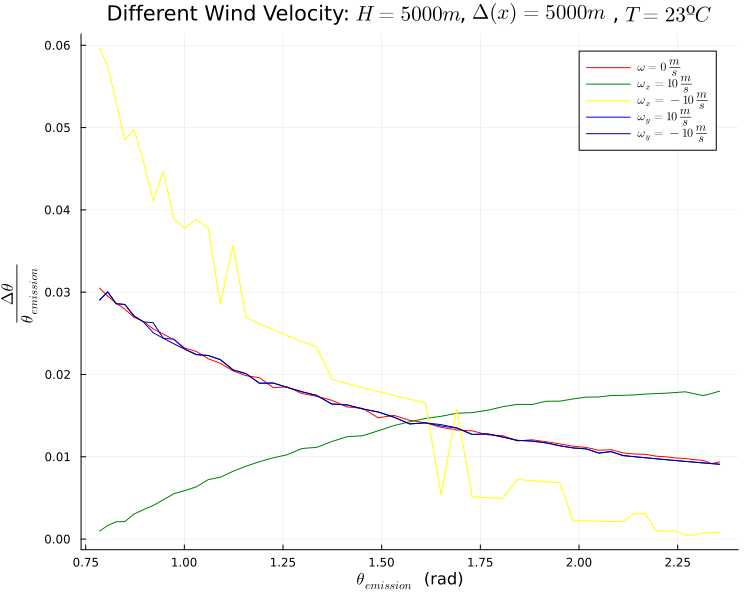

In [104]:
y8=(angulo_real_5000_5000 - angulo_recta_5000_5000)./angulo_recta_5000_5000
p = plot(deg2rad.(angulo_recta_5000_5000), y8, 
         xlabel=raw"$\theta_{emission}$  (rad)", 
         ylabel=raw"$\frac{\Delta \theta}{\theta_{emission}}$ ",
         title=raw"Different Wind Velocity: $H=5000m$, $\Delta (x)=5000m$ , $T=23ºC$",size=(750,600),color=:red,
         label=raw"$\omega=0 \frac{m}{s}$")
y14=(angulo_real_5000_5000_X10 - angulo_recta_5000_5000_X10)./angulo_recta_5000_5000_X10
plot!(deg2rad.(angulo_recta_5000_5000_X10), y14, color=:green,
         label=raw"$\omega_{x}=10 \frac{m}{s}$")
y15=(angulo_real_5000_5000_Xl10 - angulo_recta_5000_5000_Xl10)./angulo_recta_5000_5000_Xl10
plot!(deg2rad.(angulo_recta_5000_5000_Xl10), y15, color=:yellow,
         label=raw"$\omega_{x}=-10 \frac{m}{s}$")
y16=(angulo_real_5000_5000_Y10 - angulo_recta_5000_5000_Y10)./angulo_recta_5000_5000_Y10
plot!(deg2rad.(angulo_recta_5000_5000_Y10), y16, color=:blue,
         label=raw"$\omega_{y}=10 \frac{m}{s}$")

y17=(angulo_real_5000_5000_Yl10 - angulo_recta_5000_5000_Yl10)./angulo_recta_5000_5000_Yl10
plot!(deg2rad.(angulo_recta_5000_5000_Yl10), y17, color=:darkblue,
         label=raw"$\omega_{y}=-10 \frac{m}{s}$")


# Guardar la gráfica en un archivo
savefig(p, "C:\\Users\\Miguel\\Desktop\\TFM\\Ángulos_Probables_Theta\\ComparativaVientoXYPositivoNegativo.png")
p

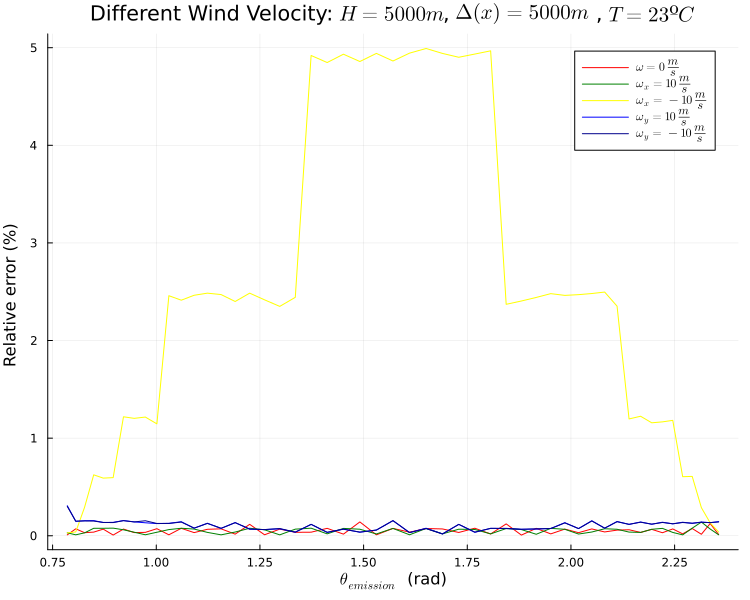

In [105]:

p = plot(deg2rad.(angulo_recta_5000_5000), errores_relativos_5000_5000, 
         xlabel=raw"$\theta_{emission}$  (rad)", 
         ylabel=raw"Relative error (%) ",
         title=raw"Different Wind Velocity: $H=5000m$, $\Delta (x)=5000m$ , $T=23ºC$",size=(750,600),color=:red,
         label=raw"$\omega=0 \frac{m}{s}$")

plot!(deg2rad.(angulo_recta_5000_5000_X10), errores_relativos_5000_5000_X10, color=:green,
         label=raw"$\omega_{x}=10 \frac{m}{s}$")

plot!(deg2rad.(angulo_recta_5000_5000_Xl10), errores_relativos_5000_5000_Xl10, color=:yellow,
         label=raw"$\omega_{x}=-10 \frac{m}{s}$")

plot!(deg2rad.(angulo_recta_5000_5000_Y10), errores_relativos_5000_5000_Y10, color=:blue,
         label=raw"$\omega_{y}=10 \frac{m}{s}$")


plot!(deg2rad.(angulo_recta_5000_5000_Yl10), errores_relativos_5000_5000_Yl10, color=:darkblue,
         label=raw"$\omega_{y}=-10 \frac{m}{s}$")


# Guardar la gráfica en un archivo
savefig(p, "C:\\Users\\Miguel\\Desktop\\TFM\\Ángulos_Probables_Theta\\ErroresComparativaVientoXYPositivoNegativo.png")
p

# Variamos Temperatura

In [83]:
using LinearAlgebra
using DifferentialEquations


E_rel=  0.01
T = -20.
v_wind =[0.,0.,0.]
Source = [0.,0.,5000.]
function phi(Point1::Array{Float64, 1}, Point2::Array{Float64, 1}, v_wind::Array{Float64, 1}, tau) 
        #tgphi= (Point2[2]-Point1[2]- v_wind[2]*tau)/(Point2[1]-Point1[1]- v_wind[1]*tau) #Cálculo phi primera iteración
        #phi=rad2deg(atan(tgphi))
        phi=rad2deg(atan((Point2[2]-Point1[2]- v_wind[2]*tau),(Point2[1]-Point1[1]- v_wind[1]*tau)))
        return phi
end
function Slowness_Spherical(Point1::Array{Float64, 1}, Point2::Array{Float64, 1}, v_wind::Array{Float64, 1}, phi, c_source)
    x1,y1,z1=Point2-Point1 #Obtención parámetros primera iteración
    r=norm(Point2-Point1)
    theta=rad2deg(acos(z1/r))
    q0=1/(c_source + (v_wind[1]*cosd(phi)+ v_wind[2]*sind(phi))*cosd(theta) )
    qx=q0*cosd(phi)*sind(theta)
    qy=q0*sind(phi)*sind(theta)
    qz=q0*cosd(theta)
    return q0,qx,qy,qz,theta
end
function c_z(T,z) 
    if z>0
        c_air=331*sqrt((T+273.15-z/200)/273.15) #Modelo termodinámico v_sonido.Introduzco T_Z0 en grados centígrados por comodidad
    else
        c_air=331*sqrt((T+273.15)/273.15)
    end
    return c_air
end
function g!(dg, g, p, t)
    qx,qy = p
    q_aux = sqrt(qx^2 + qy^2 + g[4]^2)
    c=c_z(T,g[3])
    dg[1] = c*qx/q_aux + v_wind[1] #Variación coordenada X
    dg[2] = c*qy/q_aux + v_wind[2]  #Variación coordenada Y
    dg[3] = c*g[4]/q_aux + v_wind[3] #Variación coordenada Z
    dg[4]=+q_aux*(331^2/(400*273.15))/c #Variación qz
end
#### Necesitamos una velocidad inicial, correspondiente a la fuente, y un ángulo azimutal para empezar a iterar.
c_source=c_z(T, Source[3])
####
angulo_recta_5000_5000_Tl20=[]
angulo_real_5000_5000_Tl20= []
errores_relativos_5000_5000_Tl20=[]
@time begin
for n in 0:50
    Receiver = [5000.,0.,200*n]
    R=norm(Receiver-Source)
    t_min=R/c_z(T,min(Source[3],Receiver[3]))
    t_max=R/c_z(T, max(Source[3],Receiver[3]))
    phi1=phi(Source,Receiver,v_wind, t_max) #Acotación teórica phi
    phi2=phi(Source,Receiver,v_wind, t_min) #Acotación teórica phi
    phi_i=(phi1+phi2)/2 #La media de la cota de phi como phi para la primera iteración
    #######
    q0,q_x,q_y,q_z,theta_i=Slowness_Spherical(Source,Receiver,v_wind, phi_i, c_source) #Obtención parámetros
    push!(angulo_recta_5000_5000_Tl20,theta_i)
    #######
    traveltime=[]
    detener = 0 # Variable de control
    for l in 1:10
        if detener==1
            break
        end     
        thetas= range(theta_i-25/(2^(l-1)), theta_i+25/(2^(l-1)), 50);
        if v_wind==[0.,0.,0.]
                phis=[deepcopy(phi_i)]
        else
            if l==1
                phis=(min(phi1,phi2):0.05:max(phi1,phi2))
            else
                phi_distance=max(phi1,phi2)-min(phi1,phi2)
                phis= range(phi_i-phi_distance/(2^(l)), theta_i-phi_distance/(2^(l)), 20);
            end
        end
        angulos_theta = []
        angulos_phi = []
        tiempos = []
        for i in 1:length(thetas)
            for j in 1:length(phis)
                if l>1
                    q0=1/(c_source + (v_wind[1]*cosd(phi_i)+ v_wind[2]*sind(phi_i))*cosd(theta_i) )
                end
                q_x=q0*cosd(phis[j])*sind(thetas[i])
                q_y=q0*sind(phis[j])*sind(thetas[i])
                q_z=q0*cosd(thetas[i])
                p = [q_x, q_y]
                u0 = [Source[1],Source[2],Source[3], q_z]
                tspan=[0,t_max]
                prob = ODEProblem(g!, u0, tspan, p)
                paso=1e-2*R/2000
                sol = solve(prob, RK4(), dt=paso, saveat=0:paso:t_max)
                for k in 1:length(sol.u)
                    if detener==0
                        if sqrt((sol.u[k][1] - Receiver[1])^2 +(sol.u[k][2] - Receiver[2])^2 + (sol.u[k][3] - Receiver[3])^2 ) < R/(20*2^(l-1))
                            push!(angulos_theta, thetas[i])
                            push!(angulos_phi, phis[j])
                            push!(tiempos, sol.t[k])
                            break
                        elseif sqrt((sol.u[k][1] - Receiver[1])^2 +(sol.u[k][2] - Receiver[2])^2 + (sol.u[k][3] - Receiver[3])^2 ) < R*E_rel/100
                            traveltime = sol.t[k] #Error relativo menor a 0.01% ya detenemos el barrido
                            theta_i = thetas[i]
                            phi_i = phis[j]
                            detener = 1 # Cambiamos el valor de la variable de control
                            println("Se alcanzó el error relativo objetivo.")
                            break
                        end
                    else
                        break
                    end
                end
            end
        end
        if length(tiempos)==0
            if l==1
                println("No se encontró ninguna trayectoria entre fuente y receptor. Valora si estás en una zona de sombra o ajusta el paso de tiempo ")
            end
            break
        elseif detener==0
            traveltime = findmin(tiempos)
            indice = argmin(tiempos)
            theta_i=angulos_theta[indice]
            phi_i=angulos_phi[indice]
        end
    end
    push!(angulo_real_5000_5000_Tl20,theta_i)
    q_x=q0*cosd(phi_i)*sind(theta_i)
    q_y=q0*sind(phi_i)*sind(theta_i)
    q_z=q0*cosd(theta_i)
    # Definir los parámetros
    p = [q_x, q_y]
    u0 = [Source[1],Source[2], Source[3], q_z]
    tspan=[0,traveltime[1]]
    # Crear el problema ODE
    prob = ODEProblem(g!, u0, tspan, p)
    # Resolver el problema ODE
    paso=1e-2*R/2000
    sol = solve(prob, RK4(), dt=paso, saveat=0:paso:traveltime[1])
    error_relativo_n=(sqrt((sol.u[end][1] - Receiver[1])^2 +(sol.u[end][2] - Receiver[2])^2 + (sol.u[end][3] - Receiver[3])^2 )/R)*100
    push!(errores_relativos_5000_5000_Tl20,error_relativo_n)
end
end

Se alcanzó el error relativo objetivo.
 56.525247 seconds (620.35 M allocations: 34.016 GiB, 13.47% gc time, 0.20% compilation time: 63% of which was recompilation)


In [84]:
using LinearAlgebra
using DifferentialEquations


E_rel=  0.01
T = -10.
v_wind =[0.,0.,0.]
Source = [0.,0.,5000.]
function phi(Point1::Array{Float64, 1}, Point2::Array{Float64, 1}, v_wind::Array{Float64, 1}, tau) 
        #tgphi= (Point2[2]-Point1[2]- v_wind[2]*tau)/(Point2[1]-Point1[1]- v_wind[1]*tau) #Cálculo phi primera iteración
        #phi=rad2deg(atan(tgphi))
        phi=rad2deg(atan((Point2[2]-Point1[2]- v_wind[2]*tau),(Point2[1]-Point1[1]- v_wind[1]*tau)))
        return phi
end
function Slowness_Spherical(Point1::Array{Float64, 1}, Point2::Array{Float64, 1}, v_wind::Array{Float64, 1}, phi, c_source)
    x1,y1,z1=Point2-Point1 #Obtención parámetros primera iteración
    r=norm(Point2-Point1)
    theta=rad2deg(acos(z1/r))
    q0=1/(c_source + (v_wind[1]*cosd(phi)+ v_wind[2]*sind(phi))*cosd(theta) )
    qx=q0*cosd(phi)*sind(theta)
    qy=q0*sind(phi)*sind(theta)
    qz=q0*cosd(theta)
    return q0,qx,qy,qz,theta
end
function c_z(T,z) 
    if z>0
        c_air=331*sqrt((T+273.15-z/200)/273.15) #Modelo termodinámico v_sonido.Introduzco T_Z0 en grados centígrados por comodidad
    else
        c_air=331*sqrt((T+273.15)/273.15)
    end
    return c_air
end
function g!(dg, g, p, t)
    qx,qy = p
    q_aux = sqrt(qx^2 + qy^2 + g[4]^2)
    c=c_z(T,g[3])
    dg[1] = c*qx/q_aux + v_wind[1] #Variación coordenada X
    dg[2] = c*qy/q_aux + v_wind[2]  #Variación coordenada Y
    dg[3] = c*g[4]/q_aux + v_wind[3] #Variación coordenada Z
    dg[4]=+q_aux*(331^2/(400*273.15))/c #Variación qz
end
#### Necesitamos una velocidad inicial, correspondiente a la fuente, y un ángulo azimutal para empezar a iterar.
c_source=c_z(T, Source[3])
####
angulo_recta_5000_5000_Tl10=[]
angulo_real_5000_5000_Tl10= []
errores_relativos_5000_5000_Tl10=[]
@time begin
for n in 0:50
    Receiver = [5000.,0.,200*n]
    R=norm(Receiver-Source)
    t_min=R/c_z(T,min(Source[3],Receiver[3]))
    t_max=R/c_z(T, max(Source[3],Receiver[3]))
    phi1=phi(Source,Receiver,v_wind, t_max) #Acotación teórica phi
    phi2=phi(Source,Receiver,v_wind, t_min) #Acotación teórica phi
    phi_i=(phi1+phi2)/2 #La media de la cota de phi como phi para la primera iteración
    #######
    q0,q_x,q_y,q_z,theta_i=Slowness_Spherical(Source,Receiver,v_wind, phi_i, c_source) #Obtención parámetros
    push!(angulo_recta_5000_5000_Tl10,theta_i)
    #######
    traveltime=[]
    detener = 0 # Variable de control
    for l in 1:10
        if detener==1
            break
        end     
        thetas= range(theta_i-25/(2^(l-1)), theta_i+25/(2^(l-1)), 50);
        if v_wind==[0.,0.,0.]
                phis=[deepcopy(phi_i)]
        else
            if l==1
                phis=(min(phi1,phi2):0.05:max(phi1,phi2))
            else
                phi_distance=max(phi1,phi2)-min(phi1,phi2)
                phis= range(phi_i-phi_distance/(2^(l)), theta_i-phi_distance/(2^(l)), 20);
            end
        end
        angulos_theta = []
        angulos_phi = []
        tiempos = []
        for i in 1:length(thetas)
            for j in 1:length(phis)
                if l>1
                    q0=1/(c_source + (v_wind[1]*cosd(phi_i)+ v_wind[2]*sind(phi_i))*cosd(theta_i) )
                end
                q_x=q0*cosd(phis[j])*sind(thetas[i])
                q_y=q0*sind(phis[j])*sind(thetas[i])
                q_z=q0*cosd(thetas[i])
                p = [q_x, q_y]
                u0 = [Source[1],Source[2],Source[3], q_z]
                tspan=[0,t_max]
                prob = ODEProblem(g!, u0, tspan, p)
                paso=1e-2*R/2000
                sol = solve(prob, RK4(), dt=paso, saveat=0:paso:t_max)
                for k in 1:length(sol.u)
                    if detener==0
                        if sqrt((sol.u[k][1] - Receiver[1])^2 +(sol.u[k][2] - Receiver[2])^2 + (sol.u[k][3] - Receiver[3])^2 ) < R/(20*2^(l-1))
                            push!(angulos_theta, thetas[i])
                            push!(angulos_phi, phis[j])
                            push!(tiempos, sol.t[k])
                            break
                        elseif sqrt((sol.u[k][1] - Receiver[1])^2 +(sol.u[k][2] - Receiver[2])^2 + (sol.u[k][3] - Receiver[3])^2 ) < R*E_rel/100
                            traveltime = sol.t[k] #Error relativo menor a 0.01% ya detenemos el barrido
                            theta_i = thetas[i]
                            phi_i = phis[j]
                            detener = 1 # Cambiamos el valor de la variable de control
                            println("Se alcanzó el error relativo objetivo.")
                            break
                        end
                    else
                        break
                    end
                end
            end
        end
        if length(tiempos)==0
            if l==1
                println("No se encontró ninguna trayectoria entre fuente y receptor. Valora si estás en una zona de sombra o ajusta el paso de tiempo ")
            end
            break
        elseif detener==0
            traveltime = findmin(tiempos)
            indice = argmin(tiempos)
            theta_i=angulos_theta[indice]
            phi_i=angulos_phi[indice]
        end
    end
    push!(angulo_real_5000_5000_Tl10,theta_i)
    q_x=q0*cosd(phi_i)*sind(theta_i)
    q_y=q0*sind(phi_i)*sind(theta_i)
    q_z=q0*cosd(theta_i)
    # Definir los parámetros
    p = [q_x, q_y]
    u0 = [Source[1],Source[2], Source[3], q_z]
    tspan=[0,traveltime[1]]
    # Crear el problema ODE
    prob = ODEProblem(g!, u0, tspan, p)
    # Resolver el problema ODE
    paso=1e-2*R/2000
    sol = solve(prob, RK4(), dt=paso, saveat=0:paso:traveltime[1])
    error_relativo_n=(sqrt((sol.u[end][1] - Receiver[1])^2 +(sol.u[end][2] - Receiver[2])^2 + (sol.u[end][3] - Receiver[3])^2 )/R)*100
    push!(errores_relativos_5000_5000_Tl10,error_relativo_n)
end
end

Se alcanzó el error relativo objetivo.
Se alcanzó el error relativo objetivo.
Se alcanzó el error relativo objetivo.
 52.513595 seconds (601.46 M allocations: 33.001 GiB, 14.18% gc time, 0.17% compilation time: 57% of which was recompilation)


In [85]:
using LinearAlgebra
using DifferentialEquations


E_rel=  0.01
T = 0.
v_wind =[0.,0.,0.]
Source = [0.,0.,5000.]
function phi(Point1::Array{Float64, 1}, Point2::Array{Float64, 1}, v_wind::Array{Float64, 1}, tau) 
        #tgphi= (Point2[2]-Point1[2]- v_wind[2]*tau)/(Point2[1]-Point1[1]- v_wind[1]*tau) #Cálculo phi primera iteración
        #phi=rad2deg(atan(tgphi))
        phi=rad2deg(atan((Point2[2]-Point1[2]- v_wind[2]*tau),(Point2[1]-Point1[1]- v_wind[1]*tau)))
        return phi
end
function Slowness_Spherical(Point1::Array{Float64, 1}, Point2::Array{Float64, 1}, v_wind::Array{Float64, 1}, phi, c_source)
    x1,y1,z1=Point2-Point1 #Obtención parámetros primera iteración
    r=norm(Point2-Point1)
    theta=rad2deg(acos(z1/r))
    q0=1/(c_source + (v_wind[1]*cosd(phi)+ v_wind[2]*sind(phi))*cosd(theta) )
    qx=q0*cosd(phi)*sind(theta)
    qy=q0*sind(phi)*sind(theta)
    qz=q0*cosd(theta)
    return q0,qx,qy,qz,theta
end
function c_z(T,z) 
    if z>0
        c_air=331*sqrt((T+273.15-z/200)/273.15) #Modelo termodinámico v_sonido.Introduzco T_Z0 en grados centígrados por comodidad
    else
        c_air=331*sqrt((T+273.15)/273.15)
    end
    return c_air
end
function g!(dg, g, p, t)
    qx,qy = p
    q_aux = sqrt(qx^2 + qy^2 + g[4]^2)
    c=c_z(T,g[3])
    dg[1] = c*qx/q_aux + v_wind[1] #Variación coordenada X
    dg[2] = c*qy/q_aux + v_wind[2]  #Variación coordenada Y
    dg[3] = c*g[4]/q_aux + v_wind[3] #Variación coordenada Z
    dg[4]=+q_aux*(331^2/(400*273.15))/c #Variación qz
end
#### Necesitamos una velocidad inicial, correspondiente a la fuente, y un ángulo azimutal para empezar a iterar.
c_source=c_z(T, Source[3])
####
angulo_recta_5000_5000_T0=[]
angulo_real_5000_5000_T0= []
errores_relativos_5000_5000_T0=[]
@time begin
for n in 0:50
    Receiver = [5000.,0.,200*n]
    R=norm(Receiver-Source)
    t_min=R/c_z(T,min(Source[3],Receiver[3]))
    t_max=R/c_z(T, max(Source[3],Receiver[3]))
    phi1=phi(Source,Receiver,v_wind, t_max) #Acotación teórica phi
    phi2=phi(Source,Receiver,v_wind, t_min) #Acotación teórica phi
    phi_i=(phi1+phi2)/2 #La media de la cota de phi como phi para la primera iteración
    #######
    q0,q_x,q_y,q_z,theta_i=Slowness_Spherical(Source,Receiver,v_wind, phi_i, c_source) #Obtención parámetros
    push!(angulo_recta_5000_5000_T0,theta_i)
    #######
    traveltime=[]
    detener = 0 # Variable de control
    for l in 1:10
        if detener==1
            break
        end     
        thetas= range(theta_i-25/(2^(l-1)), theta_i+25/(2^(l-1)), 50);
        if v_wind==[0.,0.,0.]
                phis=[deepcopy(phi_i)]
        else
            if l==1
                phis=(min(phi1,phi2):0.05:max(phi1,phi2))
            else
                phi_distance=max(phi1,phi2)-min(phi1,phi2)
                phis= range(phi_i-phi_distance/(2^(l)), theta_i-phi_distance/(2^(l)), 20);
            end
        end
        angulos_theta = []
        angulos_phi = []
        tiempos = []
        for i in 1:length(thetas)
            for j in 1:length(phis)
                if l>1
                    q0=1/(c_source + (v_wind[1]*cosd(phi_i)+ v_wind[2]*sind(phi_i))*cosd(theta_i) )
                end
                q_x=q0*cosd(phis[j])*sind(thetas[i])
                q_y=q0*sind(phis[j])*sind(thetas[i])
                q_z=q0*cosd(thetas[i])
                p = [q_x, q_y]
                u0 = [Source[1],Source[2],Source[3], q_z]
                tspan=[0,t_max]
                prob = ODEProblem(g!, u0, tspan, p)
                paso=1e-2*R/2000
                sol = solve(prob, RK4(), dt=paso, saveat=0:paso:t_max)
                for k in 1:length(sol.u)
                    if detener==0
                        if sqrt((sol.u[k][1] - Receiver[1])^2 +(sol.u[k][2] - Receiver[2])^2 + (sol.u[k][3] - Receiver[3])^2 ) < R/(20*2^(l-1))
                            push!(angulos_theta, thetas[i])
                            push!(angulos_phi, phis[j])
                            push!(tiempos, sol.t[k])
                            break
                        elseif sqrt((sol.u[k][1] - Receiver[1])^2 +(sol.u[k][2] - Receiver[2])^2 + (sol.u[k][3] - Receiver[3])^2 ) < R*E_rel/100
                            traveltime = sol.t[k] #Error relativo menor a 0.01% ya detenemos el barrido
                            theta_i = thetas[i]
                            phi_i = phis[j]
                            detener = 1 # Cambiamos el valor de la variable de control
                            println("Se alcanzó el error relativo objetivo.")
                            break
                        end
                    else
                        break
                    end
                end
            end
        end
        if length(tiempos)==0
            if l==1
                println("No se encontró ninguna trayectoria entre fuente y receptor. Valora si estás en una zona de sombra o ajusta el paso de tiempo ")
            end
            break
        elseif detener==0
            traveltime = findmin(tiempos)
            indice = argmin(tiempos)
            theta_i=angulos_theta[indice]
            phi_i=angulos_phi[indice]
        end
    end
    push!(angulo_real_5000_5000_T0,theta_i)
    q_x=q0*cosd(phi_i)*sind(theta_i)
    q_y=q0*sind(phi_i)*sind(theta_i)
    q_z=q0*cosd(theta_i)
    # Definir los parámetros
    p = [q_x, q_y]
    u0 = [Source[1],Source[2], Source[3], q_z]
    tspan=[0,traveltime[1]]
    # Crear el problema ODE
    prob = ODEProblem(g!, u0, tspan, p)
    # Resolver el problema ODE
    paso=1e-2*R/2000
    sol = solve(prob, RK4(), dt=paso, saveat=0:paso:traveltime[1])
    error_relativo_n=(sqrt((sol.u[end][1] - Receiver[1])^2 +(sol.u[end][2] - Receiver[2])^2 + (sol.u[end][3] - Receiver[3])^2 )/R)*100
    push!(errores_relativos_5000_5000_T0,error_relativo_n)
end
end

Se alcanzó el error relativo objetivo.
Se alcanzó el error relativo objetivo.
Se alcanzó el error relativo objetivo.
Se alcanzó el error relativo objetivo.
 46.624491 seconds (585.11 M allocations: 32.126 GiB, 14.24% gc time, 0.16% compilation time: 66% of which was recompilation)


In [86]:
using LinearAlgebra
using DifferentialEquations


E_rel=  0.01
T = 10.
v_wind =[0.,0.,0.]
Source = [0.,0.,5000.]
function phi(Point1::Array{Float64, 1}, Point2::Array{Float64, 1}, v_wind::Array{Float64, 1}, tau) 
        #tgphi= (Point2[2]-Point1[2]- v_wind[2]*tau)/(Point2[1]-Point1[1]- v_wind[1]*tau) #Cálculo phi primera iteración
        #phi=rad2deg(atan(tgphi))
        phi=rad2deg(atan((Point2[2]-Point1[2]- v_wind[2]*tau),(Point2[1]-Point1[1]- v_wind[1]*tau)))
        return phi
end
function Slowness_Spherical(Point1::Array{Float64, 1}, Point2::Array{Float64, 1}, v_wind::Array{Float64, 1}, phi, c_source)
    x1,y1,z1=Point2-Point1 #Obtención parámetros primera iteración
    r=norm(Point2-Point1)
    theta=rad2deg(acos(z1/r))
    q0=1/(c_source + (v_wind[1]*cosd(phi)+ v_wind[2]*sind(phi))*cosd(theta) )
    qx=q0*cosd(phi)*sind(theta)
    qy=q0*sind(phi)*sind(theta)
    qz=q0*cosd(theta)
    return q0,qx,qy,qz,theta
end
function c_z(T,z) 
    if z>0
        c_air=331*sqrt((T+273.15-z/200)/273.15) #Modelo termodinámico v_sonido.Introduzco T_Z0 en grados centígrados por comodidad
    else
        c_air=331*sqrt((T+273.15)/273.15)
    end
    return c_air
end
function g!(dg, g, p, t)
    qx,qy = p
    q_aux = sqrt(qx^2 + qy^2 + g[4]^2)
    c=c_z(T,g[3])
    dg[1] = c*qx/q_aux + v_wind[1] #Variación coordenada X
    dg[2] = c*qy/q_aux + v_wind[2]  #Variación coordenada Y
    dg[3] = c*g[4]/q_aux + v_wind[3] #Variación coordenada Z
    dg[4]=+q_aux*(331^2/(400*273.15))/c #Variación qz
end
#### Necesitamos una velocidad inicial, correspondiente a la fuente, y un ángulo azimutal para empezar a iterar.
c_source=c_z(T, Source[3])
####
angulo_recta_5000_5000_T10=[]
angulo_real_5000_5000_T10= []
errores_relativos_5000_5000_T10=[]
@time begin
for n in 0:50
    Receiver = [5000.,0.,200*n]
    R=norm(Receiver-Source)
    t_min=R/c_z(T,min(Source[3],Receiver[3]))
    t_max=R/c_z(T, max(Source[3],Receiver[3]))
    phi1=phi(Source,Receiver,v_wind, t_max) #Acotación teórica phi
    phi2=phi(Source,Receiver,v_wind, t_min) #Acotación teórica phi
    phi_i=(phi1+phi2)/2 #La media de la cota de phi como phi para la primera iteración
    #######
    q0,q_x,q_y,q_z,theta_i=Slowness_Spherical(Source,Receiver,v_wind, phi_i, c_source) #Obtención parámetros
    push!(angulo_recta_5000_5000_T10,theta_i)
    #######
    traveltime=[]
    detener = 0 # Variable de control
    for l in 1:10
        if detener==1
            break
        end     
        thetas= range(theta_i-25/(2^(l-1)), theta_i+25/(2^(l-1)), 50);
        if v_wind==[0.,0.,0.]
                phis=[deepcopy(phi_i)]
        else
            if l==1
                phis=(min(phi1,phi2):0.05:max(phi1,phi2))
            else
                phi_distance=max(phi1,phi2)-min(phi1,phi2)
                phis= range(phi_i-phi_distance/(2^(l)), theta_i-phi_distance/(2^(l)), 20);
            end
        end
        angulos_theta = []
        angulos_phi = []
        tiempos = []
        for i in 1:length(thetas)
            for j in 1:length(phis)
                if l>1
                    q0=1/(c_source + (v_wind[1]*cosd(phi_i)+ v_wind[2]*sind(phi_i))*cosd(theta_i) )
                end
                q_x=q0*cosd(phis[j])*sind(thetas[i])
                q_y=q0*sind(phis[j])*sind(thetas[i])
                q_z=q0*cosd(thetas[i])
                p = [q_x, q_y]
                u0 = [Source[1],Source[2],Source[3], q_z]
                tspan=[0,t_max]
                prob = ODEProblem(g!, u0, tspan, p)
                paso=1e-2*R/2000
                sol = solve(prob, RK4(), dt=paso, saveat=0:paso:t_max)
                for k in 1:length(sol.u)
                    if detener==0
                        if sqrt((sol.u[k][1] - Receiver[1])^2 +(sol.u[k][2] - Receiver[2])^2 + (sol.u[k][3] - Receiver[3])^2 ) < R/(20*2^(l-1))
                            push!(angulos_theta, thetas[i])
                            push!(angulos_phi, phis[j])
                            push!(tiempos, sol.t[k])
                            break
                        elseif sqrt((sol.u[k][1] - Receiver[1])^2 +(sol.u[k][2] - Receiver[2])^2 + (sol.u[k][3] - Receiver[3])^2 ) < R*E_rel/100
                            traveltime = sol.t[k] #Error relativo menor a 0.01% ya detenemos el barrido
                            theta_i = thetas[i]
                            phi_i = phis[j]
                            detener = 1 # Cambiamos el valor de la variable de control
                            println("Se alcanzó el error relativo objetivo.")
                            break
                        end
                    else
                        break
                    end
                end
            end
        end
        if length(tiempos)==0
            if l==1
                println("No se encontró ninguna trayectoria entre fuente y receptor. Valora si estás en una zona de sombra o ajusta el paso de tiempo ")
            end
            break
        elseif detener==0
            traveltime = findmin(tiempos)
            indice = argmin(tiempos)
            theta_i=angulos_theta[indice]
            phi_i=angulos_phi[indice]
        end
    end
    push!(angulo_real_5000_5000_T10,theta_i)
    q_x=q0*cosd(phi_i)*sind(theta_i)
    q_y=q0*sind(phi_i)*sind(theta_i)
    q_z=q0*cosd(theta_i)
    # Definir los parámetros
    p = [q_x, q_y]
    u0 = [Source[1],Source[2], Source[3], q_z]
    tspan=[0,traveltime[1]]
    # Crear el problema ODE
    prob = ODEProblem(g!, u0, tspan, p)
    # Resolver el problema ODE
    paso=1e-2*R/2000
    sol = solve(prob, RK4(), dt=paso, saveat=0:paso:traveltime[1])
    error_relativo_n=(sqrt((sol.u[end][1] - Receiver[1])^2 +(sol.u[end][2] - Receiver[2])^2 + (sol.u[end][3] - Receiver[3])^2 )/R)*100
    push!(errores_relativos_5000_5000_T10,error_relativo_n)
end
end

Se alcanzó el error relativo objetivo.
Se alcanzó el error relativo objetivo.
 45.089898 seconds (570.22 M allocations: 31.326 GiB, 14.76% gc time, 0.18% compilation time: 68% of which was recompilation)


In [87]:
using LinearAlgebra
using DifferentialEquations


E_rel=  0.01
T = 20.
v_wind =[0.,0.,0.]
Source = [0.,0.,5000.]
function phi(Point1::Array{Float64, 1}, Point2::Array{Float64, 1}, v_wind::Array{Float64, 1}, tau) 
        #tgphi= (Point2[2]-Point1[2]- v_wind[2]*tau)/(Point2[1]-Point1[1]- v_wind[1]*tau) #Cálculo phi primera iteración
        #phi=rad2deg(atan(tgphi))
        phi=rad2deg(atan((Point2[2]-Point1[2]- v_wind[2]*tau),(Point2[1]-Point1[1]- v_wind[1]*tau)))
        return phi
end
function Slowness_Spherical(Point1::Array{Float64, 1}, Point2::Array{Float64, 1}, v_wind::Array{Float64, 1}, phi, c_source)
    x1,y1,z1=Point2-Point1 #Obtención parámetros primera iteración
    r=norm(Point2-Point1)
    theta=rad2deg(acos(z1/r))
    q0=1/(c_source + (v_wind[1]*cosd(phi)+ v_wind[2]*sind(phi))*cosd(theta) )
    qx=q0*cosd(phi)*sind(theta)
    qy=q0*sind(phi)*sind(theta)
    qz=q0*cosd(theta)
    return q0,qx,qy,qz,theta
end
function c_z(T,z) 
    if z>0
        c_air=331*sqrt((T+273.15-z/200)/273.15) #Modelo termodinámico v_sonido.Introduzco T_Z0 en grados centígrados por comodidad
    else
        c_air=331*sqrt((T+273.15)/273.15)
    end
    return c_air
end
function g!(dg, g, p, t)
    qx,qy = p
    q_aux = sqrt(qx^2 + qy^2 + g[4]^2)
    c=c_z(T,g[3])
    dg[1] = c*qx/q_aux + v_wind[1] #Variación coordenada X
    dg[2] = c*qy/q_aux + v_wind[2]  #Variación coordenada Y
    dg[3] = c*g[4]/q_aux + v_wind[3] #Variación coordenada Z
    dg[4]=+q_aux*(331^2/(400*273.15))/c #Variación qz
end
#### Necesitamos una velocidad inicial, correspondiente a la fuente, y un ángulo azimutal para empezar a iterar.
c_source=c_z(T, Source[3])
####
angulo_recta_5000_5000_T20=[]
angulo_real_5000_5000_T20= []
errores_relativos_5000_5000_T20=[]
@time begin
for n in 0:50
    Receiver = [5000.,0.,200*n]
    R=norm(Receiver-Source)
    t_min=R/c_z(T,min(Source[3],Receiver[3]))
    t_max=R/c_z(T, max(Source[3],Receiver[3]))
    phi1=phi(Source,Receiver,v_wind, t_max) #Acotación teórica phi
    phi2=phi(Source,Receiver,v_wind, t_min) #Acotación teórica phi
    phi_i=(phi1+phi2)/2 #La media de la cota de phi como phi para la primera iteración
    #######
    q0,q_x,q_y,q_z,theta_i=Slowness_Spherical(Source,Receiver,v_wind, phi_i, c_source) #Obtención parámetros
    push!(angulo_recta_5000_5000_T20,theta_i)
    #######
    traveltime=[]
    detener = 0 # Variable de control
    for l in 1:10
        if detener==1
            break
        end     
        thetas= range(theta_i-25/(2^(l-1)), theta_i+25/(2^(l-1)), 50);
        if v_wind==[0.,0.,0.]
                phis=[deepcopy(phi_i)]
        else
            if l==1
                phis=(min(phi1,phi2):0.05:max(phi1,phi2))
            else
                phi_distance=max(phi1,phi2)-min(phi1,phi2)
                phis= range(phi_i-phi_distance/(2^(l)), theta_i-phi_distance/(2^(l)), 20);
            end
        end
        angulos_theta = []
        angulos_phi = []
        tiempos = []
        for i in 1:length(thetas)
            for j in 1:length(phis)
                if l>1
                    q0=1/(c_source + (v_wind[1]*cosd(phi_i)+ v_wind[2]*sind(phi_i))*cosd(theta_i) )
                end
                q_x=q0*cosd(phis[j])*sind(thetas[i])
                q_y=q0*sind(phis[j])*sind(thetas[i])
                q_z=q0*cosd(thetas[i])
                p = [q_x, q_y]
                u0 = [Source[1],Source[2],Source[3], q_z]
                tspan=[0,t_max]
                prob = ODEProblem(g!, u0, tspan, p)
                paso=1e-2*R/2000
                sol = solve(prob, RK4(), dt=paso, saveat=0:paso:t_max)
                for k in 1:length(sol.u)
                    if detener==0
                        if sqrt((sol.u[k][1] - Receiver[1])^2 +(sol.u[k][2] - Receiver[2])^2 + (sol.u[k][3] - Receiver[3])^2 ) < R/(20*2^(l-1))
                            push!(angulos_theta, thetas[i])
                            push!(angulos_phi, phis[j])
                            push!(tiempos, sol.t[k])
                            break
                        elseif sqrt((sol.u[k][1] - Receiver[1])^2 +(sol.u[k][2] - Receiver[2])^2 + (sol.u[k][3] - Receiver[3])^2 ) < R*E_rel/100
                            traveltime = sol.t[k] #Error relativo menor a 0.01% ya detenemos el barrido
                            theta_i = thetas[i]
                            phi_i = phis[j]
                            detener = 1 # Cambiamos el valor de la variable de control
                            println("Se alcanzó el error relativo objetivo.")
                            break
                        end
                    else
                        break
                    end
                end
            end
        end
        if length(tiempos)==0
            if l==1
                println("No se encontró ninguna trayectoria entre fuente y receptor. Valora si estás en una zona de sombra o ajusta el paso de tiempo ")
            end
            break
        elseif detener==0
            traveltime = findmin(tiempos)
            indice = argmin(tiempos)
            theta_i=angulos_theta[indice]
            phi_i=angulos_phi[indice]
        end
    end
    push!(angulo_real_5000_5000_T20,theta_i)
    q_x=q0*cosd(phi_i)*sind(theta_i)
    q_y=q0*sind(phi_i)*sind(theta_i)
    q_z=q0*cosd(theta_i)
    # Definir los parámetros
    p = [q_x, q_y]
    u0 = [Source[1],Source[2], Source[3], q_z]
    tspan=[0,traveltime[1]]
    # Crear el problema ODE
    prob = ODEProblem(g!, u0, tspan, p)
    # Resolver el problema ODE
    paso=1e-2*R/2000
    sol = solve(prob, RK4(), dt=paso, saveat=0:paso:traveltime[1])
    error_relativo_n=(sqrt((sol.u[end][1] - Receiver[1])^2 +(sol.u[end][2] - Receiver[2])^2 + (sol.u[end][3] - Receiver[3])^2 )/R)*100
    push!(errores_relativos_5000_5000_T20,error_relativo_n)
end
end

 44.351790 seconds (558.62 M allocations: 30.707 GiB, 14.71% gc time, 0.17% compilation time: 64% of which was recompilation)


In [88]:
using LinearAlgebra
using DifferentialEquations


E_rel=  0.01
T = 30.
v_wind =[0.,0.,0.]
Source = [0.,0.,5000.]
function phi(Point1::Array{Float64, 1}, Point2::Array{Float64, 1}, v_wind::Array{Float64, 1}, tau) 
        #tgphi= (Point2[2]-Point1[2]- v_wind[2]*tau)/(Point2[1]-Point1[1]- v_wind[1]*tau) #Cálculo phi primera iteración
        #phi=rad2deg(atan(tgphi))
        phi=rad2deg(atan((Point2[2]-Point1[2]- v_wind[2]*tau),(Point2[1]-Point1[1]- v_wind[1]*tau)))
        return phi
end
function Slowness_Spherical(Point1::Array{Float64, 1}, Point2::Array{Float64, 1}, v_wind::Array{Float64, 1}, phi, c_source)
    x1,y1,z1=Point2-Point1 #Obtención parámetros primera iteración
    r=norm(Point2-Point1)
    theta=rad2deg(acos(z1/r))
    q0=1/(c_source + (v_wind[1]*cosd(phi)+ v_wind[2]*sind(phi))*cosd(theta) )
    qx=q0*cosd(phi)*sind(theta)
    qy=q0*sind(phi)*sind(theta)
    qz=q0*cosd(theta)
    return q0,qx,qy,qz,theta
end
function c_z(T,z) 
    if z>0
        c_air=331*sqrt((T+273.15-z/200)/273.15) #Modelo termodinámico v_sonido.Introduzco T_Z0 en grados centígrados por comodidad
    else
        c_air=331*sqrt((T+273.15)/273.15)
    end
    return c_air
end
function g!(dg, g, p, t)
    qx,qy = p
    q_aux = sqrt(qx^2 + qy^2 + g[4]^2)
    c=c_z(T,g[3])
    dg[1] = c*qx/q_aux + v_wind[1] #Variación coordenada X
    dg[2] = c*qy/q_aux + v_wind[2]  #Variación coordenada Y
    dg[3] = c*g[4]/q_aux + v_wind[3] #Variación coordenada Z
    dg[4]=+q_aux*(331^2/(400*273.15))/c #Variación qz
end
#### Necesitamos una velocidad inicial, correspondiente a la fuente, y un ángulo azimutal para empezar a iterar.
c_source=c_z(T, Source[3])
####
angulo_recta_5000_5000_T30=[]
angulo_real_5000_5000_T30= []
errores_relativos_5000_5000_T30=[]
@time begin
for n in 0:50
    Receiver = [5000.,0.,200*n]
    R=norm(Receiver-Source)
    t_min=R/c_z(T,min(Source[3],Receiver[3]))
    t_max=R/c_z(T, max(Source[3],Receiver[3]))
    phi1=phi(Source,Receiver,v_wind, t_max) #Acotación teórica phi
    phi2=phi(Source,Receiver,v_wind, t_min) #Acotación teórica phi
    phi_i=(phi1+phi2)/2 #La media de la cota de phi como phi para la primera iteración
    #######
    q0,q_x,q_y,q_z,theta_i=Slowness_Spherical(Source,Receiver,v_wind, phi_i, c_source) #Obtención parámetros
    push!(angulo_recta_5000_5000_T30,theta_i)
    #######
    traveltime=[]
    detener = 0 # Variable de control
    for l in 1:10
        if detener==1
            break
        end     
        thetas= range(theta_i-25/(2^(l-1)), theta_i+25/(2^(l-1)), 50);
        if v_wind==[0.,0.,0.]
                phis=[deepcopy(phi_i)]
        else
            if l==1
                phis=(min(phi1,phi2):0.05:max(phi1,phi2))
            else
                phi_distance=max(phi1,phi2)-min(phi1,phi2)
                phis= range(phi_i-phi_distance/(2^(l)), theta_i-phi_distance/(2^(l)), 20);
            end
        end
        angulos_theta = []
        angulos_phi = []
        tiempos = []
        for i in 1:length(thetas)
            for j in 1:length(phis)
                if l>1
                    q0=1/(c_source + (v_wind[1]*cosd(phi_i)+ v_wind[2]*sind(phi_i))*cosd(theta_i) )
                end
                q_x=q0*cosd(phis[j])*sind(thetas[i])
                q_y=q0*sind(phis[j])*sind(thetas[i])
                q_z=q0*cosd(thetas[i])
                p = [q_x, q_y]
                u0 = [Source[1],Source[2],Source[3], q_z]
                tspan=[0,t_max]
                prob = ODEProblem(g!, u0, tspan, p)
                paso=1e-2*R/2000
                sol = solve(prob, RK4(), dt=paso, saveat=0:paso:t_max)
                for k in 1:length(sol.u)
                    if detener==0
                        if sqrt((sol.u[k][1] - Receiver[1])^2 +(sol.u[k][2] - Receiver[2])^2 + (sol.u[k][3] - Receiver[3])^2 ) < R/(20*2^(l-1))
                            push!(angulos_theta, thetas[i])
                            push!(angulos_phi, phis[j])
                            push!(tiempos, sol.t[k])
                            break
                        elseif sqrt((sol.u[k][1] - Receiver[1])^2 +(sol.u[k][2] - Receiver[2])^2 + (sol.u[k][3] - Receiver[3])^2 ) < R*E_rel/100
                            traveltime = sol.t[k] #Error relativo menor a 0.01% ya detenemos el barrido
                            theta_i = thetas[i]
                            phi_i = phis[j]
                            detener = 1 # Cambiamos el valor de la variable de control
                            println("Se alcanzó el error relativo objetivo.")
                            break
                        end
                    else
                        break
                    end
                end
            end
        end
        if length(tiempos)==0
            if l==1
                println("No se encontró ninguna trayectoria entre fuente y receptor. Valora si estás en una zona de sombra o ajusta el paso de tiempo ")
            end
            break
        elseif detener==0
            traveltime = findmin(tiempos)
            indice = argmin(tiempos)
            theta_i=angulos_theta[indice]
            phi_i=angulos_phi[indice]
        end
    end
    push!(angulo_real_5000_5000_T30,theta_i)
    q_x=q0*cosd(phi_i)*sind(theta_i)
    q_y=q0*sind(phi_i)*sind(theta_i)
    q_z=q0*cosd(theta_i)
    # Definir los parámetros
    p = [q_x, q_y]
    u0 = [Source[1],Source[2], Source[3], q_z]
    tspan=[0,traveltime[1]]
    # Crear el problema ODE
    prob = ODEProblem(g!, u0, tspan, p)
    # Resolver el problema ODE
    paso=1e-2*R/2000
    sol = solve(prob, RK4(), dt=paso, saveat=0:paso:traveltime[1])
    error_relativo_n=(sqrt((sol.u[end][1] - Receiver[1])^2 +(sol.u[end][2] - Receiver[2])^2 + (sol.u[end][3] - Receiver[3])^2 )/R)*100
    push!(errores_relativos_5000_5000_T30,error_relativo_n)
end
end

Se alcanzó el error relativo objetivo.
Se alcanzó el error relativo objetivo.
 43.749358 seconds (550.88 M allocations: 30.292 GiB, 14.17% gc time, 0.22% compilation time: 70% of which was recompilation)


In [89]:
using LinearAlgebra
using DifferentialEquations


E_rel=  0.01
T = 40.
v_wind =[0.,0.,0.]
Source = [0.,0.,5000.]
function phi(Point1::Array{Float64, 1}, Point2::Array{Float64, 1}, v_wind::Array{Float64, 1}, tau) 
        #tgphi= (Point2[2]-Point1[2]- v_wind[2]*tau)/(Point2[1]-Point1[1]- v_wind[1]*tau) #Cálculo phi primera iteración
        #phi=rad2deg(atan(tgphi))
        phi=rad2deg(atan((Point2[2]-Point1[2]- v_wind[2]*tau),(Point2[1]-Point1[1]- v_wind[1]*tau)))
        return phi
end
function Slowness_Spherical(Point1::Array{Float64, 1}, Point2::Array{Float64, 1}, v_wind::Array{Float64, 1}, phi, c_source)
    x1,y1,z1=Point2-Point1 #Obtención parámetros primera iteración
    r=norm(Point2-Point1)
    theta=rad2deg(acos(z1/r))
    q0=1/(c_source + (v_wind[1]*cosd(phi)+ v_wind[2]*sind(phi))*cosd(theta) )
    qx=q0*cosd(phi)*sind(theta)
    qy=q0*sind(phi)*sind(theta)
    qz=q0*cosd(theta)
    return q0,qx,qy,qz,theta
end
function c_z(T,z) 
    if z>0
        c_air=331*sqrt((T+273.15-z/200)/273.15) #Modelo termodinámico v_sonido.Introduzco T_Z0 en grados centígrados por comodidad
    else
        c_air=331*sqrt((T+273.15)/273.15)
    end
    return c_air
end
function g!(dg, g, p, t)
    qx,qy = p
    q_aux = sqrt(qx^2 + qy^2 + g[4]^2)
    c=c_z(T,g[3])
    dg[1] = c*qx/q_aux + v_wind[1] #Variación coordenada X
    dg[2] = c*qy/q_aux + v_wind[2]  #Variación coordenada Y
    dg[3] = c*g[4]/q_aux + v_wind[3] #Variación coordenada Z
    dg[4]=+q_aux*(331^2/(400*273.15))/c #Variación qz
end
#### Necesitamos una velocidad inicial, correspondiente a la fuente, y un ángulo azimutal para empezar a iterar.
c_source=c_z(T, Source[3])
####
angulo_recta_5000_5000_T40=[]
angulo_real_5000_5000_T40= []
errores_relativos_5000_5000_T40=[]
@time begin
for n in 0:50
    Receiver = [5000.,0.,200*n]
    R=norm(Receiver-Source)
    t_min=R/c_z(T,min(Source[3],Receiver[3]))
    t_max=R/c_z(T, max(Source[3],Receiver[3]))
    phi1=phi(Source,Receiver,v_wind, t_max) #Acotación teórica phi
    phi2=phi(Source,Receiver,v_wind, t_min) #Acotación teórica phi
    phi_i=(phi1+phi2)/2 #La media de la cota de phi como phi para la primera iteración
    #######
    q0,q_x,q_y,q_z,theta_i=Slowness_Spherical(Source,Receiver,v_wind, phi_i, c_source) #Obtención parámetros
    push!(angulo_recta_5000_5000_T40,theta_i)
    #######
    traveltime=[]
    detener = 0 # Variable de control
    for l in 1:10
        if detener==1
            break
        end     
        thetas= range(theta_i-25/(2^(l-1)), theta_i+25/(2^(l-1)), 50);
        if v_wind==[0.,0.,0.]
                phis=[deepcopy(phi_i)]
        else
            if l==1
                phis=(min(phi1,phi2):0.05:max(phi1,phi2))
            else
                phi_distance=max(phi1,phi2)-min(phi1,phi2)
                phis= range(phi_i-phi_distance/(2^(l)), theta_i-phi_distance/(2^(l)), 20);
            end
        end
        angulos_theta = []
        angulos_phi = []
        tiempos = []
        for i in 1:length(thetas)
            for j in 1:length(phis)
                if l>1
                    q0=1/(c_source + (v_wind[1]*cosd(phi_i)+ v_wind[2]*sind(phi_i))*cosd(theta_i) )
                end
                q_x=q0*cosd(phis[j])*sind(thetas[i])
                q_y=q0*sind(phis[j])*sind(thetas[i])
                q_z=q0*cosd(thetas[i])
                p = [q_x, q_y]
                u0 = [Source[1],Source[2],Source[3], q_z]
                tspan=[0,t_max]
                prob = ODEProblem(g!, u0, tspan, p)
                paso=1e-2*R/2000
                sol = solve(prob, RK4(), dt=paso, saveat=0:paso:t_max)
                for k in 1:length(sol.u)
                    if detener==0
                        if sqrt((sol.u[k][1] - Receiver[1])^2 +(sol.u[k][2] - Receiver[2])^2 + (sol.u[k][3] - Receiver[3])^2 ) < R/(20*2^(l-1))
                            push!(angulos_theta, thetas[i])
                            push!(angulos_phi, phis[j])
                            push!(tiempos, sol.t[k])
                            break
                        elseif sqrt((sol.u[k][1] - Receiver[1])^2 +(sol.u[k][2] - Receiver[2])^2 + (sol.u[k][3] - Receiver[3])^2 ) < R*E_rel/100
                            traveltime = sol.t[k] #Error relativo menor a 0.01% ya detenemos el barrido
                            theta_i = thetas[i]
                            phi_i = phis[j]
                            detener = 1 # Cambiamos el valor de la variable de control
                            println("Se alcanzó el error relativo objetivo.")
                            break
                        end
                    else
                        break
                    end
                end
            end
        end
        if length(tiempos)==0
            if l==1
                println("No se encontró ninguna trayectoria entre fuente y receptor. Valora si estás en una zona de sombra o ajusta el paso de tiempo ")
            end
            break
        elseif detener==0
            traveltime = findmin(tiempos)
            indice = argmin(tiempos)
            theta_i=angulos_theta[indice]
            phi_i=angulos_phi[indice]
        end
    end
    push!(angulo_real_5000_5000_T40,theta_i)
    q_x=q0*cosd(phi_i)*sind(theta_i)
    q_y=q0*sind(phi_i)*sind(theta_i)
    q_z=q0*cosd(theta_i)
    # Definir los parámetros
    p = [q_x, q_y]
    u0 = [Source[1],Source[2], Source[3], q_z]
    tspan=[0,traveltime[1]]
    # Crear el problema ODE
    prob = ODEProblem(g!, u0, tspan, p)
    # Resolver el problema ODE
    paso=1e-2*R/2000
    sol = solve(prob, RK4(), dt=paso, saveat=0:paso:traveltime[1])
    error_relativo_n=(sqrt((sol.u[end][1] - Receiver[1])^2 +(sol.u[end][2] - Receiver[2])^2 + (sol.u[end][3] - Receiver[3])^2 )/R)*100
    push!(errores_relativos_5000_5000_T40,error_relativo_n)
end
end

Se alcanzó el error relativo objetivo.
 41.359038 seconds (532.91 M allocations: 29.320 GiB, 14.76% gc time, 0.20% compilation time: 72% of which was recompilation)


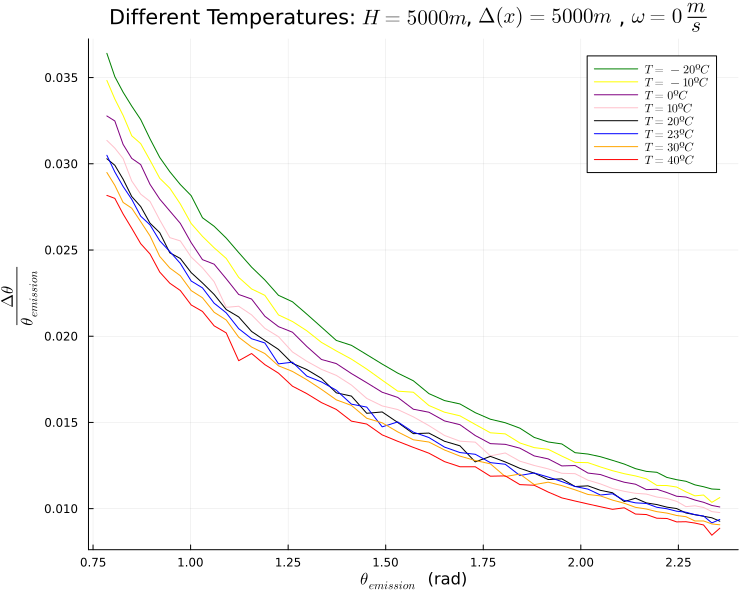

In [97]:
y18=(angulo_real_5000_5000_Tl20 - angulo_recta_5000_5000_Tl20)./angulo_recta_5000_5000_Tl20
p=plot(deg2rad.(angulo_recta_5000_5000_Tl20), y18, xlabel=raw"$\theta_{emission}$  (rad)", 
         ylabel=raw"$\frac{\Delta \theta}{\theta_{emission}}$ ",
         title=raw"Different Temperatures: $H=5000m$, $\Delta (x)=5000m$ , $\omega=0 \frac{m}{s}$ ",size=(750,600), color=:green,
         label=raw"$T=-20ºC$")
y19=(angulo_real_5000_5000_Tl10 - angulo_recta_5000_5000_Tl10)./angulo_recta_5000_5000_Tl10
plot!(deg2rad.(angulo_recta_5000_5000_Tl10), y19, color=:yellow,
         label=raw"$T=-10ºC$")
y20=(angulo_real_5000_5000_T0 - angulo_recta_5000_5000_T0)./angulo_recta_5000_5000_T0
plot!(deg2rad.(angulo_recta_5000_5000_T0), y20, color=:purple,
         label=raw"$T=0ºC$")
y21=(angulo_real_5000_5000_T10 - angulo_recta_5000_5000_T10)./angulo_recta_5000_5000_T10
plot!(deg2rad.(angulo_recta_5000_5000_T10), y21, color=:pink,
         label=raw"$T=10ºC$")
y22=(angulo_real_5000_5000_T20 - angulo_recta_5000_5000_T20)./angulo_recta_5000_5000_T20
plot!(deg2rad.(angulo_recta_5000_5000_T20), y22, color=:black,
         label=raw"$T=20ºC$")
#y8=(angulo_real_5000_5000 - angulo_recta_5000_5000)./angulo_recta_5000_5000 #ya estaba definido
plot!(deg2rad.(angulo_recta_5000_5000), y8, color=:blue,
         label=raw"$T=23ºC$") 
y23=(angulo_real_5000_5000_T30 - angulo_recta_5000_5000_T30)./angulo_recta_5000_5000_T30
plot!(deg2rad.(angulo_recta_5000_5000_T30), y23, color=:orange,
         label=raw"$T=30ºC$")
y24=(angulo_real_5000_5000_T40 - angulo_recta_5000_5000_T40)./angulo_recta_5000_5000_T40
plot!(deg2rad.(angulo_recta_5000_5000_T40), y24, color=:red,
         label=raw"$T=40ºC$")


# Guardar la gráfica en un archivo
savefig(p, "C:\\Users\\Miguel\\Desktop\\TFM\\Ángulos_Probables_Theta\\ComparativaTemperaturas.png")
p


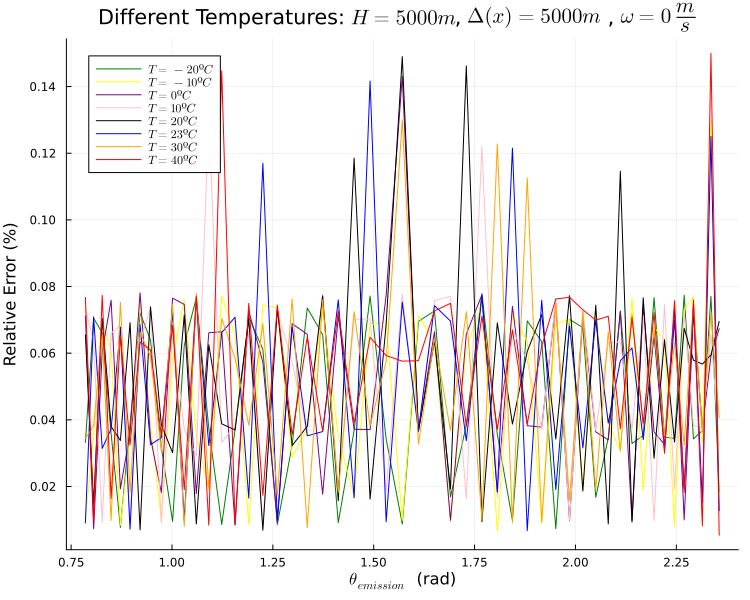

In [98]:

q=plot(deg2rad.(angulo_recta_5000_5000_Tl20), errores_relativos_5000_5000_Tl20, xlabel=raw"$\theta_{emission}$  (rad)", 
         ylabel=raw"Relative Error (%)",
         title=raw"Different Temperatures: $H=5000m$, $\Delta (x)=5000m$ , $\omega=0 \frac{m}{s}$ ",size=(750,600), color=:green,
         label=raw"$T=-20ºC$")
plot!(deg2rad.(angulo_recta_5000_5000_Tl10), errores_relativos_5000_5000_Tl10, color=:yellow,
         label=raw"$T=-10ºC$")
plot!(deg2rad.(angulo_recta_5000_5000_T0), errores_relativos_5000_5000_T0, color=:purple,
         label=raw"$T=0ºC$")

plot!(deg2rad.(angulo_recta_5000_5000_T10), errores_relativos_5000_5000_T10, color=:pink,
         label=raw"$T=10ºC$")
plot!(deg2rad.(angulo_recta_5000_5000_T20), errores_relativos_5000_5000_T20, color=:black,
         label=raw"$T=20ºC$")
#y8=(angulo_real_5000_5000 - angulo_recta_5000_5000)./angulo_recta_5000_5000 #ya estaba definido
plot!(deg2rad.(angulo_recta_5000_5000), errores_relativos_5000_5000, color=:blue,
         label=raw"$T=23ºC$") 
plot!(deg2rad.(angulo_recta_5000_5000_T30), errores_relativos_5000_5000_T30, color=:orange,
         label=raw"$T=30ºC$")
plot!(deg2rad.(angulo_recta_5000_5000_T40), errores_relativos_5000_5000_T40, color=:red,
         label=raw"$T=40ºC$")


# Guardar la gráfica en un archivo
savefig(q, "C:\\Users\\Miguel\\Desktop\\TFM\\Ángulos_Probables_Theta\\Errores_ComparativaTemperaturas.png")
q